Classifying White Blood Cells

HU Extension | CSCI E89 Deep Learning | Final Project

Jonak, Paul

Submitted May 8, 2018

=================================================

About the code contained within:

This portion of code is intended to cover data preparation and model building.



=================================================

Section 0: Set Environment Parameters

In [124]:
# load system packages
import copy
import os
import shutil
import sys

# Load third-party packages
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas
import PIL


import cv2
print("\nOpenCV version " + cv2.__version__)


import keras
from keras import backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


OpenCV version 3.4.1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2528154415344074191
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 75431936
locality {
  bus_id: 1
}
incarnation: 13738892814467432695
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:0b:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 245301248
locality {
  bus_id: 1
}
incarnation: 11363451965614557070
physical_device_desc: "device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:41:00.0, compute capability: 6.1"
]


In [125]:
# Identify where data will be stored
#   root dir
fpRoot = 'C:/Users/Paul/Documents/Courses/2018_1_HarExt_CSCI_E89__DeepLearning'
if not os.path.exists(fpRoot):
    fpRoot = 'C:/Users/Paul Jonak/Documents/Courses/2018_1_HarExt_CSCI_E89__DeepLearning'

#   dir for source images
fpSrc = os.path.join(fpRoot, 'data', 'FinalProject', 'src')
#   dir for prepared images
fpPrep = os.path.join(fpRoot, 'data', 'FinalProject', 'prep')
#   dir for dataset, small exploratory set
fpDatSmall = os.path.join(fpRoot, 'data', 'FinalProject', 'dat_small')
#   dir for dataset, medium set
fpDatMedium = os.path.join(fpRoot, 'data', 'FinalProject', 'dat_medium')
#   dir for dataset, full final set
fpDatFull = os.path.join(fpRoot, 'data', 'FinalProject', 'dat_full')

=================================================

Section 1: Investigate Source Data

Along with images, the source data inludes a label file. The label file matches each image to its appropriate class. In some instances, no class is given or multiple classes are listed. We will ignore both cases. For the remainder, let's see what classes we have and their respective frequencies.

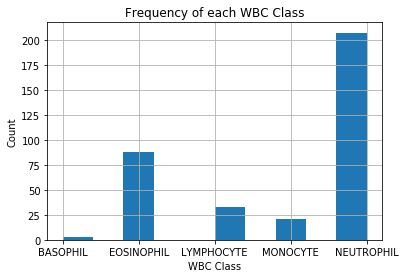

In [126]:
# load labels.csv file
fpLabels_src = os.path.join(fpSrc, 'labels.csv')

if not os.path.exists(fpLabels_src):
    print("Unable to proceed | Cannot find source labels | " + fpLabels_src)
else:
    ### Load labels.csv from folder Src
    dfLabels = pandas.read_csv(fpLabels_src,
                               sep=',', usecols=['Image', 'Category'])
    ### Get listing with only 1 identified cell type per file
    # Remove entries with no label
    dfLabels = dfLabels[pandas.notnull(dfLabels['Category'])]
    # Remove entries with multiple labels
    dfLabels = dfLabels[~dfLabels['Category'].str.contains(",")]

    # Plot histogram to show frequency of each class
    dfLabels['Category'].hist()
    plt.title('Frequency of each WBC Class')
    plt.xlabel('WBC Class')
    plt.ylabel('Count')
    plt.show()

We see that NEUTROPHIL is by far the most common, followed by EOSINOPHIL. We are concerned with the comparatively small count for BASOPHIL. We will remove BASOPHIL from consideration

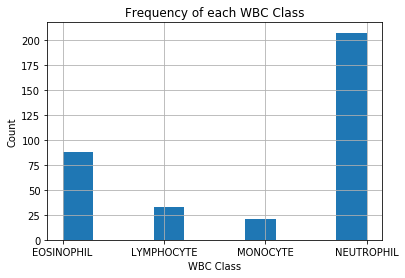

In [127]:
# Remove BASOPHIL
dfLabels = dfLabels[dfLabels['Category']!='BASOPHIL']

# Plot histogram again
dfLabels['Category'].hist()
plt.title('Frequency of each WBC Class')
plt.xlabel('WBC Class')
plt.ylabel('Count')
plt.show()

We are concerned by the small counts for MONOCYTE and even LYMPHOCYTE. We will keep these classes and augment the data using ImageDataGenerator as in Week6.

Gather details of the data

In [128]:
def filename_build__source(imgID):
    fn = 'BloodImage_' + ''.join(np.repeat('0', 5-len(str(imgID))) ) + str(imgID) + '.jpg'
    return fn
def filepath_build__source(fpSrc, imgID):
    fp = os.path.join(fpSrc, filename_build__source(imgID=imgID))
    return fp

In [6]:
# Final list of classes we will focus on
listClass = dfLabels['Category'].unique()
nClass = len(listClass)

# Record number of source images per class
dictClass = {sClass: {'nImg_src': sum(dfLabels['Category']==sClass)}
             for sClass in listClass}

# Get image properties
#   Image dimensions
#   Max pixel value

dim_name_fullsize = 'fullsize'
dim_name_downsample = 'downsample'

fp = filepath_build__source(fpSrc=fpSrc,
                            imgID=dfLabels['Image'].iloc[0])
img = cv2.imread(fp)

dictImgProp = {'img_dim': {dim_name_fullsize: list(img.shape)},
               'max_pixel_val': np.iinfo(img.dtype).max}

Determine size of our down-sampled images

In [7]:
# Image resolution for down-sampled images
#   480 x 640   - original
#   240 x 320   - /2
#   120 x 160   - /4
#    96 x 128   - /5

dictImgProp['img_dim'][dim_name_downsample] = copy.copy(
    dictImgProp['img_dim'][dim_name_fullsize] )
for i in range(2):
    dictImgProp['img_dim'][dim_name_downsample][i] = int(
        dictImgProp['img_dim'][dim_name_fullsize][i] / 4 )

In [8]:
print(dictImgProp['img_dim'][dim_name_fullsize])
print(dictImgProp['img_dim'][dim_name_downsample])

[480, 640, 3]
[120, 160, 3]


Determine the size of our datasets

In [9]:
order_of_magnitude = 100

nImg_small = int( np.ceil(max(
    [dictClass[sClass]['nImg_src'] for sClass in dictClass.keys()]
) / order_of_magnitude ) * order_of_magnitude )

nImg_medium = nImg_small*3

nImg_full = nImg_small*10

=================================================

Section 2: Prepare Datasets

In [10]:
### Copy files from folder Src to folder Prep
###   Change filenames to fit convention: class.ID.jpg
###   Organize files into class folders

# Does folder Prep exist?
if not os.path.exists(fpPrep):
    # Create folder
    os.mkdir(fpPrep)
    
    # Focusing on full-size images first
    dim_name = dim_name_fullsize
    
    os.mkdir(os.path.join(fpPrep, dim_name))
    
    #   Create sub-folders for each class and fill with source images
    listInvalidID = []
    for sClass in listClass:
        print(sClass)
        # Create folder
        os.mkdir(os.path.join(fpPrep, dim_name, sClass))
        # Copy over files
        for i, imgID in enumerate(dfLabels['Image'][dfLabels['Category']==sClass]):
            # Buid paths
            #   source path
            fp_src = filepath_build__source(fpSrc=fpSrc, imgID=imgID)
            #   target path
            fn_tar = sClass + '.' + str(i+1) + '.jpg'
            fp_tar = os.path.join(fpPrep, dim_name, sClass, fn_tar)
            # Copy
            if not os.path.exists(fp_src):
                # Record invalid img ID
                listInvalidID.append(imgID)
            else:
                # Copy
                shutil.copyfile(fp_src, fp_tar)
    # Remove invalid entries from listing and save dfLabels
    #   Remove invalid entries
    if len(listInvalidID) != 0:
        dfLabels = dfLabels[~dfLabels['Image'].isin(listInvalidID)]
    #   Save
    dfLabels.to_csv(os.path.join(fpPrep, 'labels.csv'),
                    sep='|', index=False)

In [11]:
### Augment images
if os.path.exists(fpPrep) and os.path.exists(
      os.path.join(fpPrep, dim_name_fullsize)):
    dim_name = dim_name_fullsize
    
    # Open ImageDataGen
    #   From W6
    hImgGen = ImageDataGenerator(rotation_range=180,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 shear_range=0.15,
                                 horizontal_flip=True,
                                 vertical_flip=True)
    
    # Loop through each class to generate appropriate images
    for sClass in dictClass.keys():
        print("Augmenting images for class " + sClass)
        
        # Get list of files
        fpClass = os.path.join(fpPrep, dim_name, sClass)
        listFiles = [fn for fn in os.listdir(fpClass)
                     if os.path.isfile(os.path.join(fpClass, fn))]
        
        if len(listFiles) > dictClass[sClass]['nImg_src']:
            # Images already prepared
            print("\tAugmented images found - Skipping")
            break
        
        # Hold all source images in memory
        #   Initialize
        hImg_all = np.zeros((len(listFiles),
                             dictImgProp['img_dim'][dim_name][0],
                             dictImgProp['img_dim'][dim_name][1],
                             dictImgProp['img_dim'][dim_name][2]))
        #   Grab each image
        for idx, fn in enumerate(listFiles):
            # Load image file
            hImg = PIL.Image.open(os.path.join(fpClass, fn))
            # Store
            hImg_all[idx,:,:,:] = hImg
            # Close image file
            hImg.close()
        
        # Generate new images
        for iImg in range(len(listFiles), nImg_full):
            # Select a random source image
            #   Get random index
            ###idx = np.random.choice(dictClass[sClass]['nImg_src'])
            idx = np.random.choice(len(listFiles))
            # Build path to new file
            fp = os.path.join(fpClass, sClass + '.' + str(iImg+1) + '.jpg')
            # Change image
            for batch in hImgGen.flow(hImg_all[[idx],:,:,:], batch_size=1):
                img3 = image.array_to_img(batch[0])
                img3 = image.img_to_array(img3)

                hImg = PIL.Image.fromarray((img3).astype(np.uint8))
                hImg.save(fp)

                break

Augmenting images for class NEUTROPHIL
	Augmented images found - Skipping


In [12]:
### Get dowmsampled images
if os.path.exists(fpPrep) and os.path.exists(
      os.path.join(fpPrep, dim_name_fullsize)):
    if not os.path.exists(os.path.join(fpPrep, dim_name_downsample)):
        # Create folder
        os.mkdir(os.path.join(fpPrep, dim_name_downsample))
        
        # Loop through each class to generate appropriate images
        for sClass in dictClass.keys():
            print("Down-sampling images for class " + sClass)
            
            # Define source and target folders
            fpClass_src = os.path.join(fpPrep, dim_name_fullsize, sClass)
            fpClass_tar = os.path.join(fpPrep, dim_name_downsample, sClass)
            
            # Prepare target folder
            os.mkdir(fpClass_tar)
            
            # Get list of files in source to be down-sampled
            listFiles = [fn for fn in os.listdir(fpClass_src)
                         if os.path.isfile(os.path.join(fpClass_src, fn))]
            # Down-sample files
            for fn in listFiles:
                # Define paths
                fp_src = os.path.join(fpClass_src, fn)
                fp_tar = os.path.join(fpClass_tar, fn)
                
                # Load image using CV2, as done in W7
                hImg = cv2.imread(fp_src)[:, :, ::-1]
                # Down-sample
                hImg = cv2.resize(hImg,
                                  (dictImgProp['img_dim'][dim_name_downsample][0],
                                   dictImgProp['img_dim'][dim_name_downsample][1]))
                # Save down-sampled image
                cv2.imwrite(fp_tar, hImg)

In [13]:
### Build out the small, medium and full datasets
###   Also split into training and test images
for dataset in ['small', 'medium', 'full']:
    print("Building dataset " + dataset)
    
    if dataset=='small':
        fpDat = fpDatSmall
        nImg = nImg_small
    elif dataset=='medium':
        fpDat = fpDatMedium
        nImg = nImg_medium
    elif dataset=='full':
        fpDat = fpDatFull
        nImg = nImg_full
    
    if not os.path.exists(fpDat):
        # Create dir
        os.mkdir(fpDat)
        
        # Loop through both image size sets
        for dim_name in dictImgProp['img_dim'].keys():
            # Create dir
            os.mkdir(os.path.join(fpDat, dim_name))
            
            # Create sub-folders for training and tests sets
            os.mkdir(os.path.join(fpDat, dim_name, 'train'))
            os.mkdir(os.path.join(fpDat, dim_name, 'test'))
            
            # Generate training and tests sets for each class
            for sClass in dictClass.keys():
                print("Gathering images for class " + sClass + 
                      " (dim " + dim_name + ")")
                
                # Create class sub-folders
                fpClass_train = os.path.join(fpDat, dim_name, 'train', sClass)
                fpClass_test = os.path.join(fpDat, dim_name, 'test', sClass)
                
                os.mkdir(fpClass_train)
                os.mkdir(fpClass_test)
                
                # Define source folder
                fpClass_src = os.path.join(fpPrep, dim_name, sClass)
                
                # Get list of source files for this class
                listFiles = [fn for fn in os.listdir(fpClass_src)
                             if os.path.isfile(os.path.join(fpClass_src, fn))]
                
                # Identify files to be used for training and testing
                nImg_test = int(round( nImg / 10 ))
                nImg_train = nImg - nImg_test
                
                if len(listFiles) < nImg:
                    print("\t\tNot enough source files found - skipping")
                    print("\t\t\tFound " + str(len(listFiles)) + " of " + str(nImg))
                else:
                    listFiles_train = listFiles[:nImg_train]
                    listFiles_test = listFiles[nImg_train:nImg]
                    
                    for fn in listFiles_train:
                        # Copy file
                        shutil.copy(os.path.join(fpClass_src, fn),
                                    os.path.join(fpClass_train, fn))
                    for fn in listFiles_test:
                        # Copy file
                        shutil.copy(os.path.join(fpClass_src, fn),
                                    os.path.join(fpClass_test, fn))

Building dataset small
Building dataset medium
Building dataset full


=================================================

Section 3: Prepare fundamental functions

In [14]:

def prep_parameters(dataset, I_downsample):
    # Set input image dimensions
    if I_downsample:
        dim_name = dim_name_downsample
    else:
        dim_name = dim_name_fullsize
    img_dim = dictImgProp['img_dim'][dim_name]

    # Set data folder
    if dataset=='small':
        fpDat = fpDatSmall
    elif dataset=='medium':
        fpDat = fpDatMedium
    elif dataset=='full':
        fpDat = fpDatFull

    fpTrain = os.path.join(fpDat, dim_name, 'train')
    fpTest = os.path.join(fpDat, dim_name, 'test')
    
    return dim_name, img_dim, fpTrain, fpTest

def prep_ImageDataGenerator(dictImgProp, ImgDatGen__batch_size,
                            img_dim, fpTrain, fpTest):
    # Initialize
    train_datagen = ImageDataGenerator(rescale=1./dictImgProp['max_pixel_val'])
    test_datagen = ImageDataGenerator(rescale=1./dictImgProp['max_pixel_val'])

    # In Week6, we had only two classes: cat or dog.
    # Subseqently, we had binary labels.
    # Here we have multiple classes therefore we will use categorical labels
    #   Note that the W6 model used binary_crossentropy loss
    #   Here we will need to use categorical_crossentropy loss
    train_generator = train_datagen.flow_from_directory(
            fpTrain,
            target_size=(img_dim[0], img_dim[1]),
            batch_size=ImgDatGen__batch_size,
            shuffle=True,
            classes=None, # will be inferred from subdirectory names
            class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(
            fpTest,
            target_size=(img_dim[0], img_dim[1]),
            batch_size=ImgDatGen__batch_size,
            shuffle=True,
            classes=None, # will be inferred from subdirectory names
            class_mode='categorical')

    for data_batch, labels_batch in train_generator:
        print('data batch shape:', data_batch.shape)
        print('labels batch shape:', labels_batch.shape)
        break
    
    return train_generator, validation_generator

def prep_main(dataset, I_downsample, dictImgProp, ImgDatGen__batch_size):
    
    dim_name, img_dim, fpTrain, fpTest = prep_parameters(
        dataset=dataset, I_downsample=I_downsample)
    
    train_generator, validation_generator = prep_ImageDataGenerator(
        dictImgProp=dictImgProp, ImgDatGen__batch_size=ImgDatGen__batch_size,
        img_dim=img_dim, fpTrain=fpTrain, fpTest=fpTest)
    
    return img_dim, train_generator, validation_generator

=================================================

Section 4: Modeling the Data, First Pass

In [152]:
### 4) Modeling the Data, First Pass
###     Section 4.0) Define functions adapted from W6 hw

def build_model_w6(img_dim, nClass, optimizer='rmsprop',
                   dim_conv2d_1=4, dim_conv2d_2=8,
                   dim_conv2d_3=8, dim_conv2d_4=8,
                   dim_dense=128):
    ### Adapt from W6 hw
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(dim_conv2d_1, (3, 3), activation='relu',
                               input_shape=(img_dim[0], img_dim[1], img_dim[2])))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(dim_conv2d_2, (3, 3), activation='relu'))
    if dim_conv2d_3 != 0:
        model.add(keras.layers.MaxPooling2D((2, 2)))
        model.add(keras.layers.Conv2D(dim_conv2d_3, (3, 3), activation='relu'))
        if dim_conv2d_4 != 0:
            model.add(keras.layers.MaxPooling2D((2, 2)))
            model.add(keras.layers.Conv2D(dim_conv2d_4, (3, 3), activation='relu'))
    
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(dim_dense, activation='relu'))

    model.add(keras.layers.Dense(nClass, activation='softmax'))    
    model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['acc'])
    return model

def fit_model_w6(model,
                 train_generator, validation_generator,
                 epochs, steps_per_epoch, validation_steps,
                 verbose=0):
    model_history = model.fit_generator(train_generator,
                                        epochs=epochs,
                                        steps_per_epoch=steps_per_epoch,
                                        validation_data=validation_generator,
                                        validation_steps=validation_steps,
                                        verbose=verbose)
    return model_history

def eval_model_w6(model_history,
                  nPts__get_avg=None,
                  I_plot__min_acc=None,
                  I_plot__min_val_acc=None):
    
    acc = model_history.history['acc']
    val_acc = model_history.history['val_acc']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    
    epochs = range(len(acc))
    
    if nPts__get_avg is None:
        nPts__get_avg = int(np.ceil(len(acc)*0.15))
    nPts2 = int(np.ceil(nPts__get_avg/2))
        
    acc_final = np.mean(acc[(-nPts__get_avg):])
    val_acc_final = np.mean(val_acc[(-nPts__get_avg):])
    loss_final = np.mean(loss[(-nPts__get_avg):])
    val_loss_final = np.mean(val_loss[(-nPts__get_avg):])
    
    idx_min = np.argmin(val_loss)
    val_loss_lowest = np.mean(val_loss[
        np.max([1, idx_min-nPts2]):np.min([len(val_loss), idx_min+nPts2])])
    
    msg = "acc=%.2f (val_acc=%.2f) | loss=%.2f (val_loss=%.2f) | lowest val_loss=%.2f" % (
              acc_final, val_acc_final, loss_final, val_loss_final, val_loss_lowest)
    
    
    if not I_plot__min_acc is None or not I_plot__min_val_acc is None:
        I_plot = False
        if not I_plot__min_acc is None:
            if any(np.asarray(acc) > I_plot__min_acc):
                I_plot = True
        if not I_plot__min_val_acc is None:
            if any(np.asarray(acc) > I_plot__min_val_acc):
                I_plot = True
    else:
        I_plot = True
                
    if I_plot:
        plt.figure(figsize=(16, 6))
        
        plt.subplot(1,2,1)
        plt.plot(epochs, acc, 'bo', label='Training acc')
        plt.plot(epochs, val_acc, 'b', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.ylim(0, 1.1)
        plt.xlabel('epoch')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(epochs, loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.ylim(0, 3)
        plt.xlabel('epoch')
        plt.legend()

        plt.show()
    return msg, acc_final, val_acc_final, loss_final, val_loss_final, val_loss_lowest

In [155]:
### 4) Modeling the Data, First Pass
###     Section 4.1) Prepare parameters

# User-defined parameters
#   Which dataset
dataset = 'small'
#   Toggle between using down-sampled or full images
I_downsample = True
#   Set ImageDataGenerator batch size
ImgDatGen__batch_size = 32
#   Number of epochs
epochs=30
#   Optimizer and settings
#     Currently not changing optimizer settings, such as learning rate
optimizer='rmsprop'

# Get handles to ImageeDataGenerator objects
img_dim, train_generator, validation_generator = prep_main(
    dataset=dataset, I_downsample=I_downsample, dictImgProp=dictImgProp, 
    ImgDatGen__batch_size=ImgDatGen__batch_size)

Found 1080 images belonging to 4 classes.
Found 120 images belonging to 4 classes.
data batch shape: (32, 120, 160, 3)
labels batch shape: (32, 4)


In [156]:
### 4) Modeling the Data, First Pass
###     Section 4.2) Build model

dim_conv2d_1 = 8
dim_conv2d_2 = 16
dim_conv2d_3 = 16
dim_conv2d_4 = 0
dim_dense = 128

model = build_model_w6(img_dim=img_dim,
                       nClass=len(dictClass.keys()),
                       optimizer=optimizer,
                       dim_conv2d_1=dim_conv2d_1,
                       dim_conv2d_2=dim_conv2d_2,
                       dim_conv2d_3=dim_conv2d_3,
                       dim_conv2d_4=dim_conv2d_4,
                       dim_dense=dim_dense)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_813 (Conv2D)          (None, 118, 158, 8)       224       
_________________________________________________________________
max_pooling2d_562 (MaxPoolin (None, 59, 79, 8)         0         
_________________________________________________________________
conv2d_814 (Conv2D)          (None, 57, 77, 16)        1168      
_________________________________________________________________
max_pooling2d_563 (MaxPoolin (None, 28, 38, 16)        0         
_________________________________________________________________
conv2d_815 (Conv2D)          (None, 26, 36, 16)        2320      
_________________________________________________________________
flatten_252 (Flatten)        (None, 14976)             0         
_________________________________________________________________
dense_503 (Dense)            (None, 128)               1917056   
__________

In [157]:
### 4) Modeling the Data, First Pass
###     Section 4.3) Fit model
model_history = fit_model_w6(model=model,
                             train_generator=train_generator,
                             validation_generator=validation_generator,
                             epochs=epochs,
                             steps_per_epoch=len(train_generator),
                             validation_steps=len(validation_generator),
                             verbose=0)

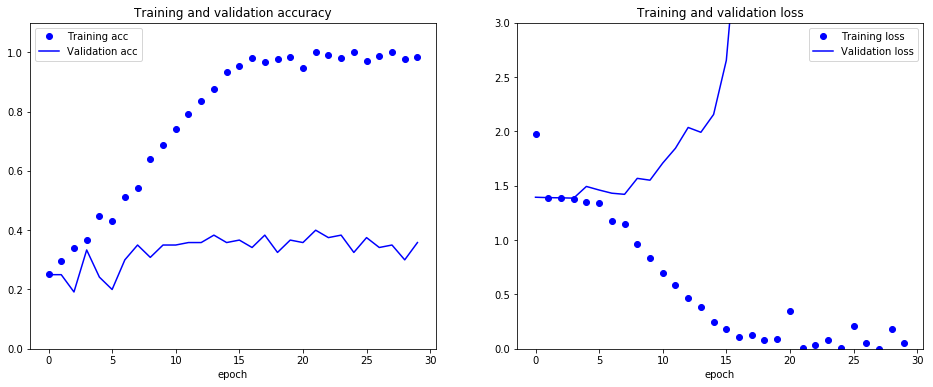

acc=0.98 (val_acc=0.34) | loss=0.10 (val_loss=4.56) | lowest val_loss=1.42


In [158]:
### 4) Modeling the Data, First Pass
###     Section 4.4) Evaluate model
msg, avg_acc, avg_val_acc, avg_loss, avg_val_loss, val_loss_lowest = \
  eval_model_w6(model_history=model_history)
print(msg)

We're happy to see a high training accuracy and low training loss, however the validation accuracy and loss suggest we are over-fitting. We will loop through a matrix of layer parameters in search of a better model.


dim_dense=8 | conv2d_1=4 | conv2d_2=4 | conv2d_3=0 | conv2d_4=0
acc=0.23 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39

dim_dense=8 | conv2d_1=4 | conv2d_2=4 | conv2d_3=4 | conv2d_4=0
acc=0.24 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39

dim_dense=8 | conv2d_1=4 | conv2d_2=4 | conv2d_3=4 | conv2d_4=4
acc=0.74 (val_acc=0.31) | loss=0.67 (val_loss=1.97) | lowest val_loss=1.39

dim_dense=8 | conv2d_1=4 | conv2d_2=8 | conv2d_3=0 | conv2d_4=0
acc=0.23 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39

dim_dense=8 | conv2d_1=4 | conv2d_2=8 | conv2d_3=8 | conv2d_4=0
acc=0.24 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39

dim_dense=8 | conv2d_1=4 | conv2d_2=8 | conv2d_3=8 | conv2d_4=8
acc=0.58 (val_acc=0.36) | loss=0.99 (val_loss=1.60) | lowest val_loss=1.39

dim_dense=8 | conv2d_1=8 | conv2d_2=8 | conv2d_3=0 | conv2d_4=0
acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=12.09

dim_dense=8 | co

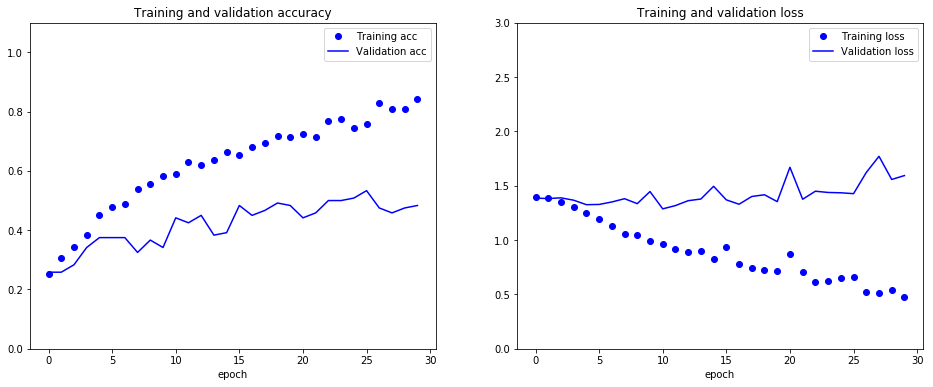

acc=0.81 (val_acc=0.49) | loss=0.54 (val_loss=1.59) | lowest val_loss=1.35

dim_dense=8 | conv2d_1=8 | conv2d_2=8 | conv2d_3=8 | conv2d_4=8
acc=0.24 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39

dim_dense=8 | conv2d_1=8 | conv2d_2=16 | conv2d_3=0 | conv2d_4=0
acc=0.24 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39

dim_dense=8 | conv2d_1=8 | conv2d_2=16 | conv2d_3=16 | conv2d_4=0
acc=0.23 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39

dim_dense=8 | conv2d_1=8 | conv2d_2=16 | conv2d_3=16 | conv2d_4=16
acc=0.24 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39

dim_dense=8 | conv2d_1=16 | conv2d_2=16 | conv2d_3=0 | conv2d_4=0


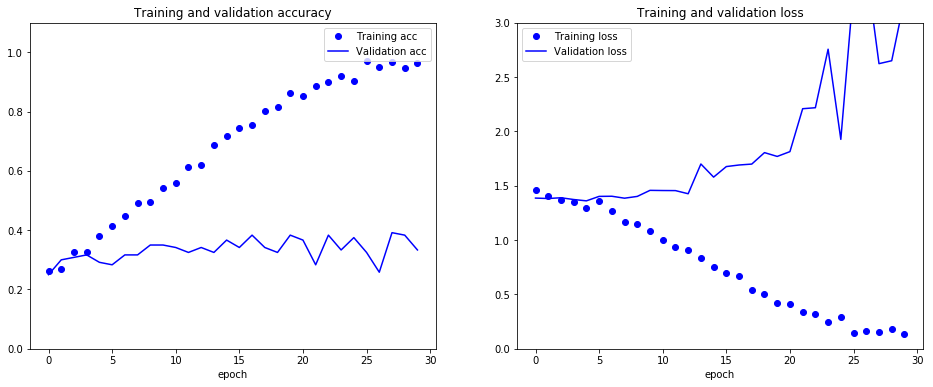

acc=0.96 (val_acc=0.34) | loss=0.16 (val_loss=3.06) | lowest val_loss=1.39

dim_dense=8 | conv2d_1=16 | conv2d_2=16 | conv2d_3=16 | conv2d_4=0
acc=0.23 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39

dim_dense=8 | conv2d_1=16 | conv2d_2=16 | conv2d_3=16 | conv2d_4=16
acc=0.24 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39

dim_dense=8 | conv2d_1=16 | conv2d_2=32 | conv2d_3=0 | conv2d_4=0


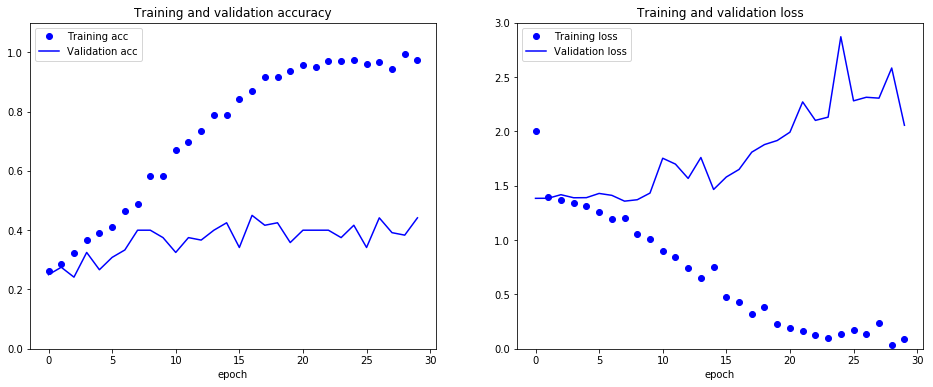

acc=0.97 (val_acc=0.40) | loss=0.14 (val_loss=2.31) | lowest val_loss=1.40

dim_dense=8 | conv2d_1=16 | conv2d_2=32 | conv2d_3=32 | conv2d_4=0
acc=0.53 (val_acc=0.38) | loss=1.10 (val_loss=1.40) | lowest val_loss=1.58

dim_dense=8 | conv2d_1=16 | conv2d_2=32 | conv2d_3=32 | conv2d_4=32
acc=0.24 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39

dim_dense=16 | conv2d_1=4 | conv2d_2=4 | conv2d_3=0 | conv2d_4=0


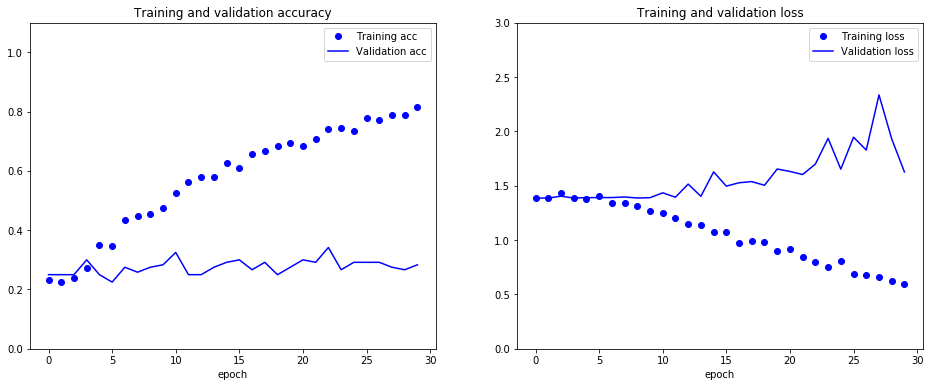

acc=0.79 (val_acc=0.28) | loss=0.65 (val_loss=1.93) | lowest val_loss=1.40

dim_dense=16 | conv2d_1=4 | conv2d_2=4 | conv2d_3=4 | conv2d_4=0
acc=0.72 (val_acc=0.43) | loss=0.72 (val_loss=1.48) | lowest val_loss=1.37

dim_dense=16 | conv2d_1=4 | conv2d_2=4 | conv2d_3=4 | conv2d_4=4
acc=0.59 (val_acc=0.38) | loss=0.96 (val_loss=1.39) | lowest val_loss=1.38

dim_dense=16 | conv2d_1=4 | conv2d_2=8 | conv2d_3=0 | conv2d_4=0
acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=12.09

dim_dense=16 | conv2d_1=4 | conv2d_2=8 | conv2d_3=8 | conv2d_4=0
acc=0.23 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39

dim_dense=16 | conv2d_1=4 | conv2d_2=8 | conv2d_3=8 | conv2d_4=8
acc=0.66 (val_acc=0.27) | loss=0.84 (val_loss=1.91) | lowest val_loss=1.39

dim_dense=16 | conv2d_1=8 | conv2d_2=8 | conv2d_3=0 | conv2d_4=0
acc=0.24 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39

dim_dense=16 | conv2d_1=8 | conv2d_2=8 | conv2d_3=8 | conv2d_4=0


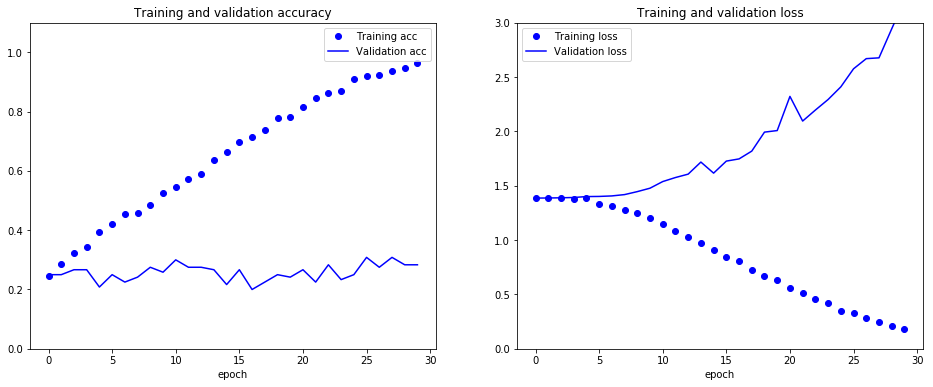

acc=0.94 (val_acc=0.29) | loss=0.25 (val_loss=2.81) | lowest val_loss=1.39

dim_dense=16 | conv2d_1=8 | conv2d_2=8 | conv2d_3=8 | conv2d_4=8
acc=0.54 (val_acc=0.39) | loss=1.04 (val_loss=1.38) | lowest val_loss=1.35

dim_dense=16 | conv2d_1=8 | conv2d_2=16 | conv2d_3=0 | conv2d_4=0


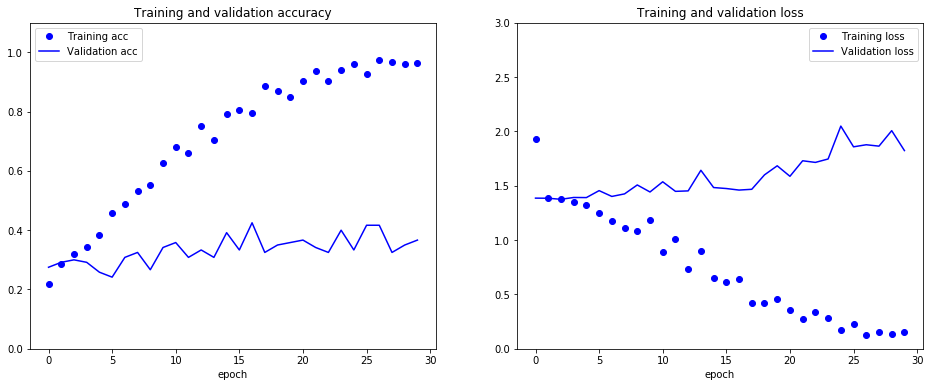

acc=0.96 (val_acc=0.38) | loss=0.16 (val_loss=1.89) | lowest val_loss=1.39

dim_dense=16 | conv2d_1=8 | conv2d_2=16 | conv2d_3=16 | conv2d_4=0


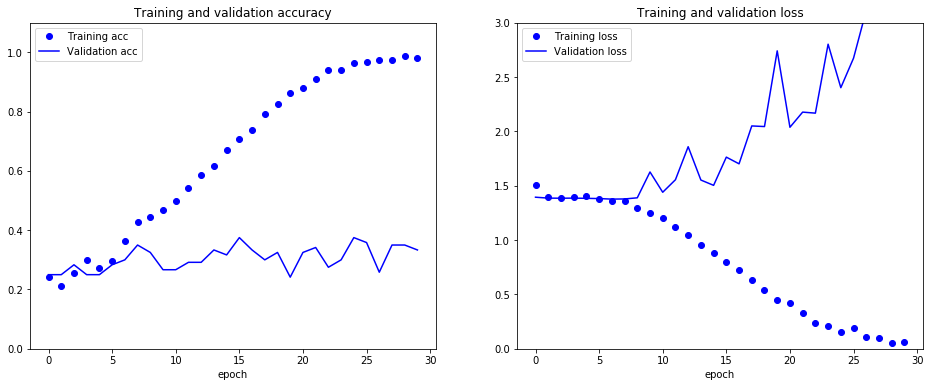

acc=0.98 (val_acc=0.33) | loss=0.11 (val_loss=3.23) | lowest val_loss=1.38

dim_dense=16 | conv2d_1=8 | conv2d_2=16 | conv2d_3=16 | conv2d_4=16


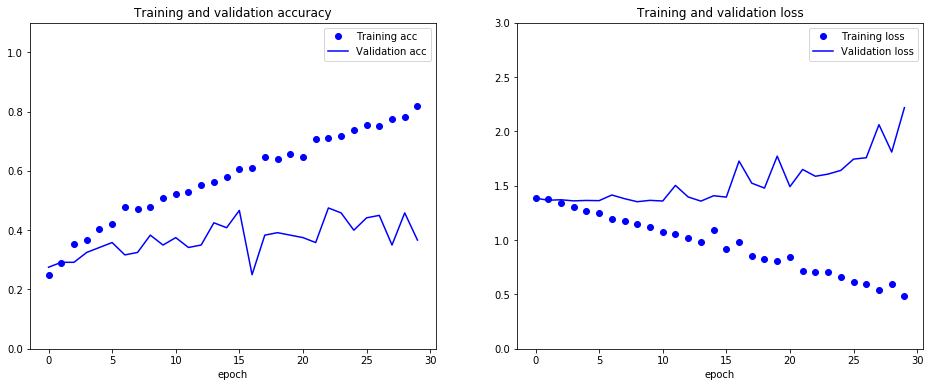

acc=0.78 (val_acc=0.41) | loss=0.57 (val_loss=1.92) | lowest val_loss=1.37

dim_dense=16 | conv2d_1=16 | conv2d_2=16 | conv2d_3=0 | conv2d_4=0


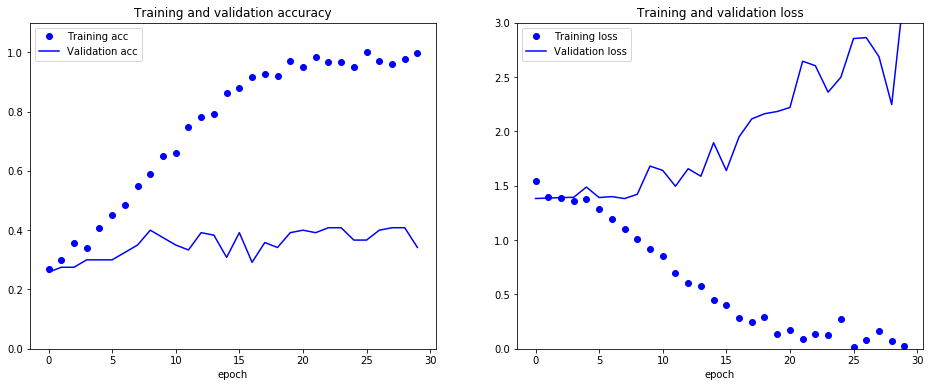

acc=0.98 (val_acc=0.39) | loss=0.07 (val_loss=2.79) | lowest val_loss=1.46

dim_dense=16 | conv2d_1=16 | conv2d_2=16 | conv2d_3=16 | conv2d_4=0
acc=0.25 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39

dim_dense=16 | conv2d_1=16 | conv2d_2=16 | conv2d_3=16 | conv2d_4=16
acc=0.72 (val_acc=0.40) | loss=0.68 (val_loss=1.74) | lowest val_loss=1.43

dim_dense=16 | conv2d_1=16 | conv2d_2=32 | conv2d_3=0 | conv2d_4=0
acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=12.09

dim_dense=16 | conv2d_1=16 | conv2d_2=32 | conv2d_3=32 | conv2d_4=0


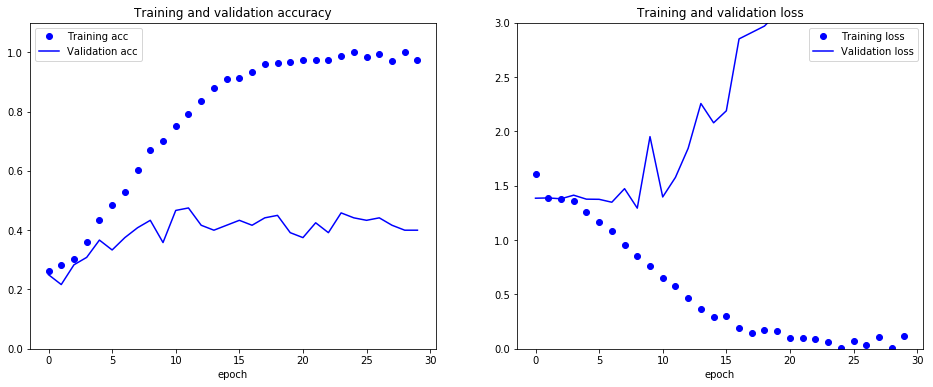

acc=0.98 (val_acc=0.42) | loss=0.07 (val_loss=4.32) | lowest val_loss=1.47

dim_dense=16 | conv2d_1=16 | conv2d_2=32 | conv2d_3=32 | conv2d_4=32
acc=0.23 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39

dim_dense=32 | conv2d_1=4 | conv2d_2=4 | conv2d_3=0 | conv2d_4=0
acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=12.09

dim_dense=32 | conv2d_1=4 | conv2d_2=4 | conv2d_3=4 | conv2d_4=0


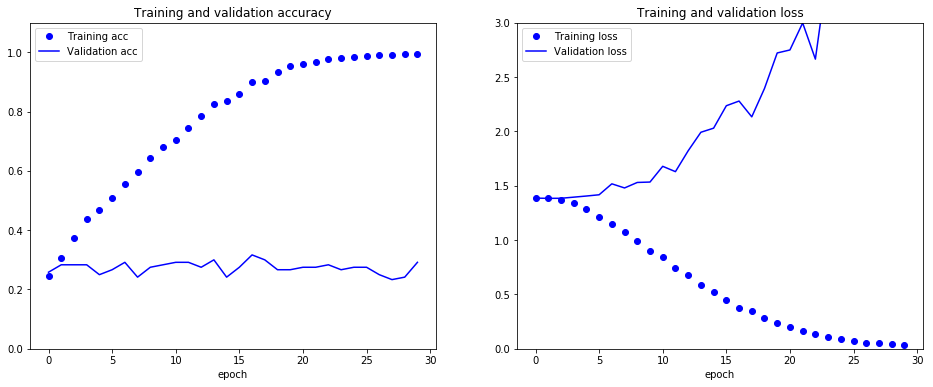

acc=0.99 (val_acc=0.26) | loss=0.05 (val_loss=4.21) | lowest val_loss=1.39

dim_dense=32 | conv2d_1=4 | conv2d_2=4 | conv2d_3=4 | conv2d_4=4
acc=0.23 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39

dim_dense=32 | conv2d_1=4 | conv2d_2=8 | conv2d_3=0 | conv2d_4=0
acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=12.09

dim_dense=32 | conv2d_1=4 | conv2d_2=8 | conv2d_3=8 | conv2d_4=0
acc=0.24 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39

dim_dense=32 | conv2d_1=4 | conv2d_2=8 | conv2d_3=8 | conv2d_4=8
acc=0.66 (val_acc=0.40) | loss=0.88 (val_loss=1.48) | lowest val_loss=1.41

dim_dense=32 | conv2d_1=8 | conv2d_2=8 | conv2d_3=0 | conv2d_4=0


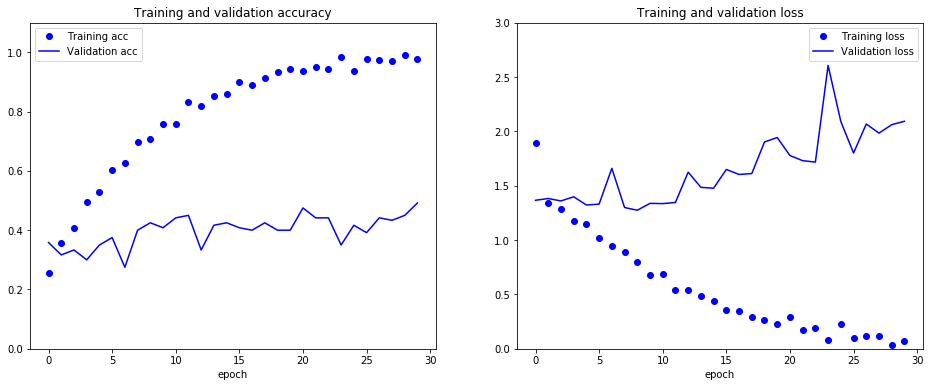

acc=0.98 (val_acc=0.44) | loss=0.09 (val_loss=2.00) | lowest val_loss=1.37

dim_dense=32 | conv2d_1=8 | conv2d_2=8 | conv2d_3=8 | conv2d_4=0


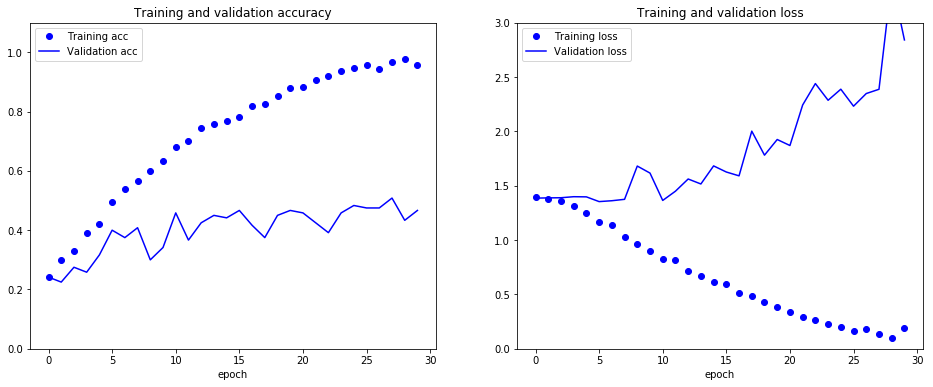

acc=0.96 (val_acc=0.47) | loss=0.15 (val_loss=2.64) | lowest val_loss=1.38

dim_dense=32 | conv2d_1=8 | conv2d_2=8 | conv2d_3=8 | conv2d_4=8


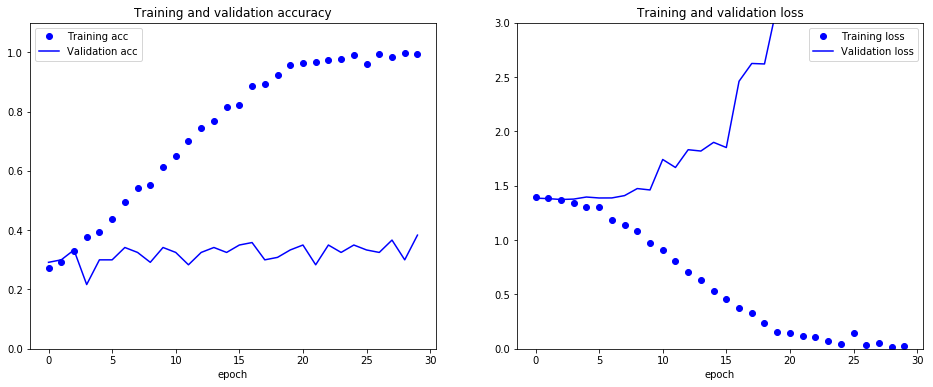

acc=0.99 (val_acc=0.34) | loss=0.06 (val_loss=4.33) | lowest val_loss=1.38

dim_dense=32 | conv2d_1=8 | conv2d_2=16 | conv2d_3=0 | conv2d_4=0
acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=12.09

dim_dense=32 | conv2d_1=8 | conv2d_2=16 | conv2d_3=16 | conv2d_4=0
acc=0.24 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39

dim_dense=32 | conv2d_1=8 | conv2d_2=16 | conv2d_3=16 | conv2d_4=16


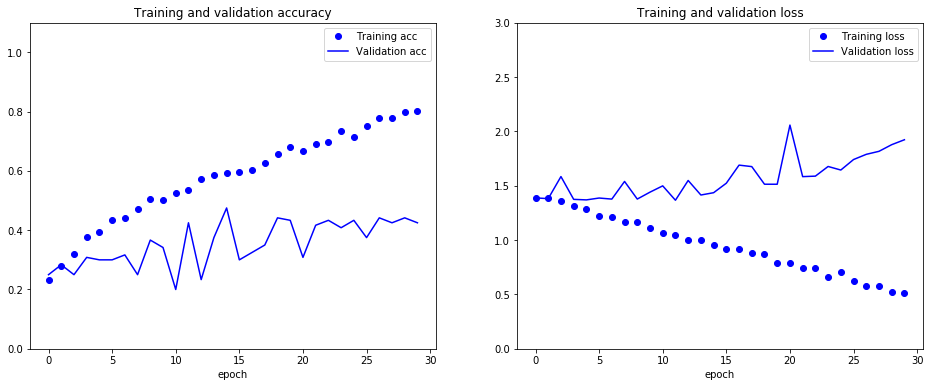

acc=0.78 (val_acc=0.42) | loss=0.56 (val_loss=1.83) | lowest val_loss=1.44

dim_dense=32 | conv2d_1=16 | conv2d_2=16 | conv2d_3=0 | conv2d_4=0


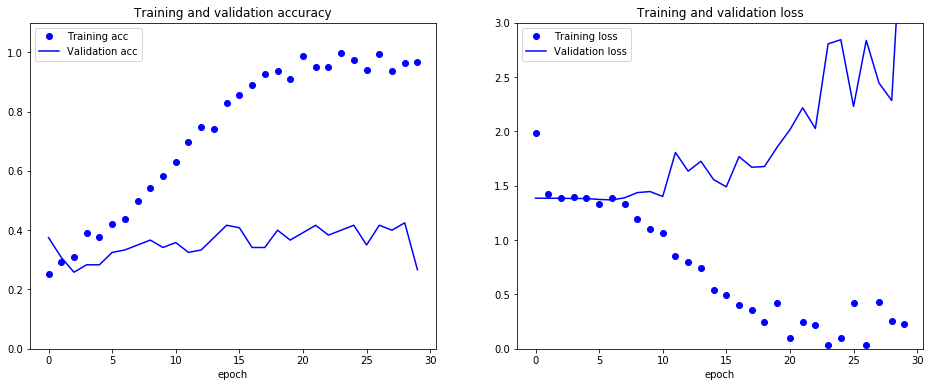

acc=0.96 (val_acc=0.37) | loss=0.27 (val_loss=2.82) | lowest val_loss=1.39

dim_dense=32 | conv2d_1=16 | conv2d_2=16 | conv2d_3=16 | conv2d_4=0


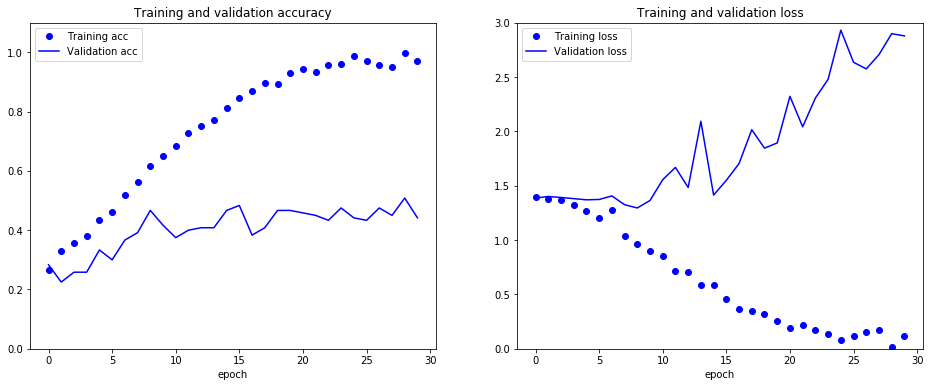

acc=0.97 (val_acc=0.46) | loss=0.12 (val_loss=2.74) | lowest val_loss=1.39

dim_dense=32 | conv2d_1=16 | conv2d_2=16 | conv2d_3=16 | conv2d_4=16


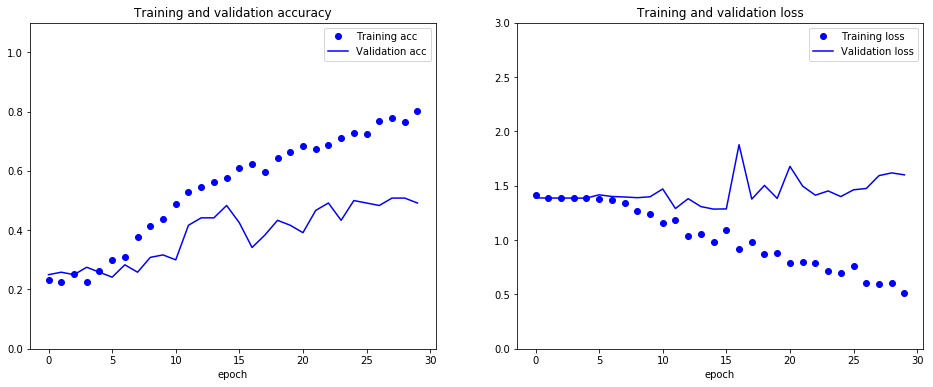

acc=0.77 (val_acc=0.50) | loss=0.62 (val_loss=1.55) | lowest val_loss=1.40

dim_dense=32 | conv2d_1=16 | conv2d_2=32 | conv2d_3=0 | conv2d_4=0
acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=12.09

dim_dense=32 | conv2d_1=16 | conv2d_2=32 | conv2d_3=32 | conv2d_4=0


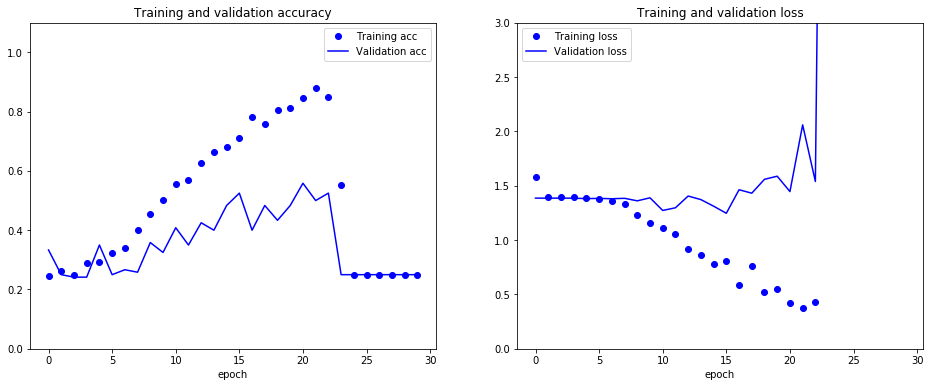

acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=1.37

dim_dense=32 | conv2d_1=16 | conv2d_2=32 | conv2d_3=32 | conv2d_4=32


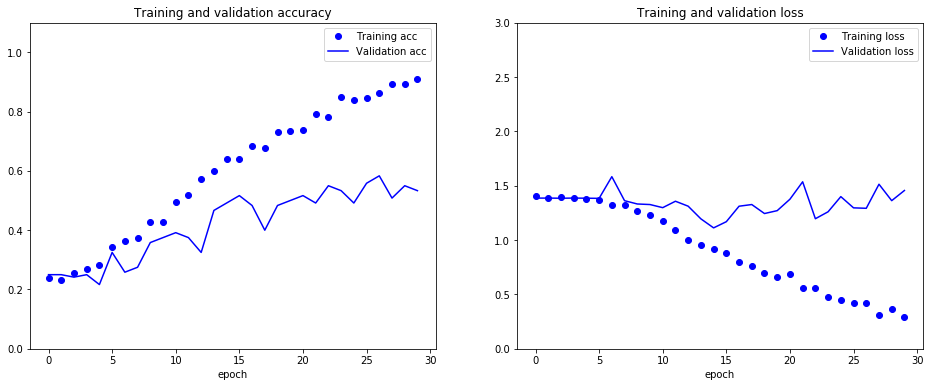

acc=0.88 (val_acc=0.55) | loss=0.36 (val_loss=1.38) | lowest val_loss=1.24

dim_dense=64 | conv2d_1=4 | conv2d_2=4 | conv2d_3=0 | conv2d_4=0


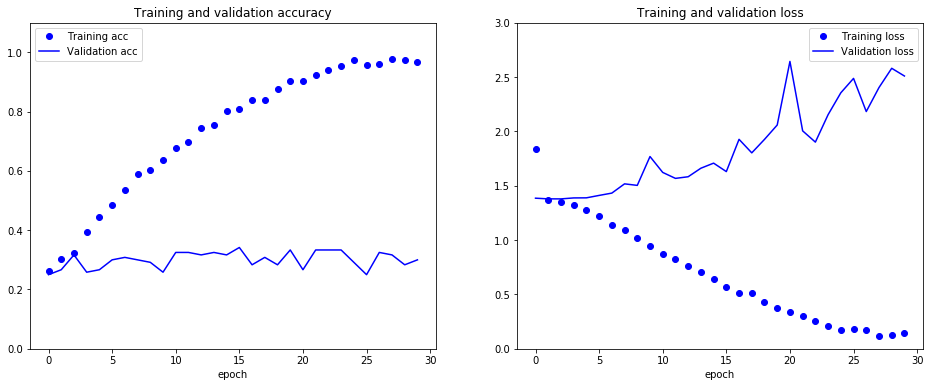

acc=0.97 (val_acc=0.29) | loss=0.15 (val_loss=2.43) | lowest val_loss=1.38

dim_dense=64 | conv2d_1=4 | conv2d_2=4 | conv2d_3=4 | conv2d_4=0


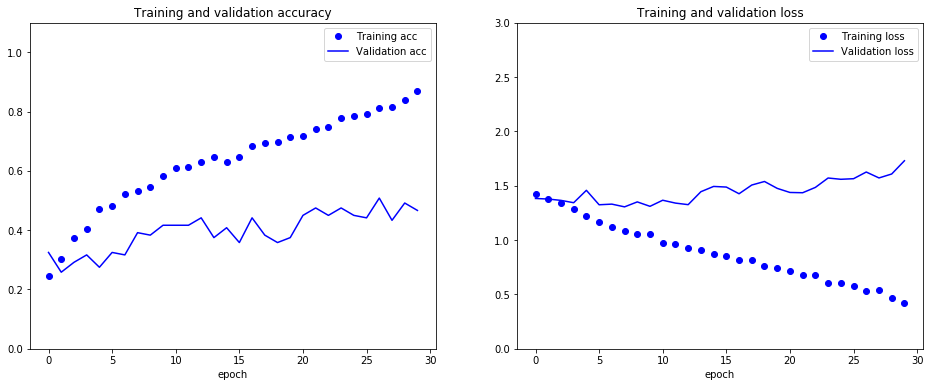

acc=0.83 (val_acc=0.47) | loss=0.51 (val_loss=1.62) | lowest val_loss=1.35

dim_dense=64 | conv2d_1=4 | conv2d_2=4 | conv2d_3=4 | conv2d_4=4


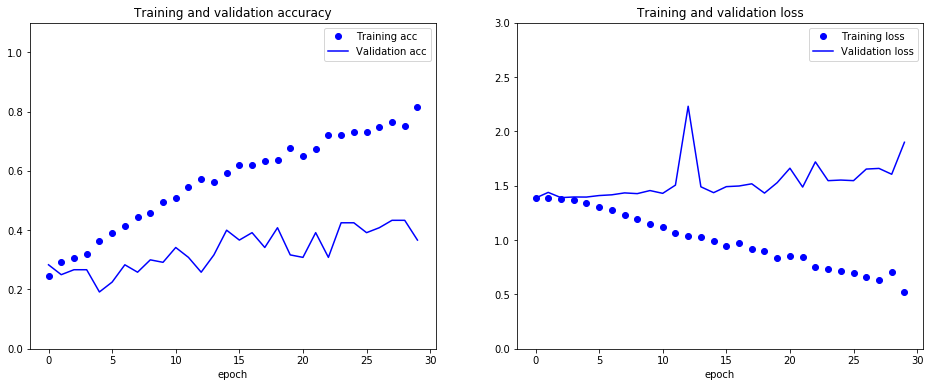

acc=0.76 (val_acc=0.41) | loss=0.64 (val_loss=1.67) | lowest val_loss=1.41

dim_dense=64 | conv2d_1=4 | conv2d_2=8 | conv2d_3=0 | conv2d_4=0
acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=12.09

dim_dense=64 | conv2d_1=4 | conv2d_2=8 | conv2d_3=8 | conv2d_4=0


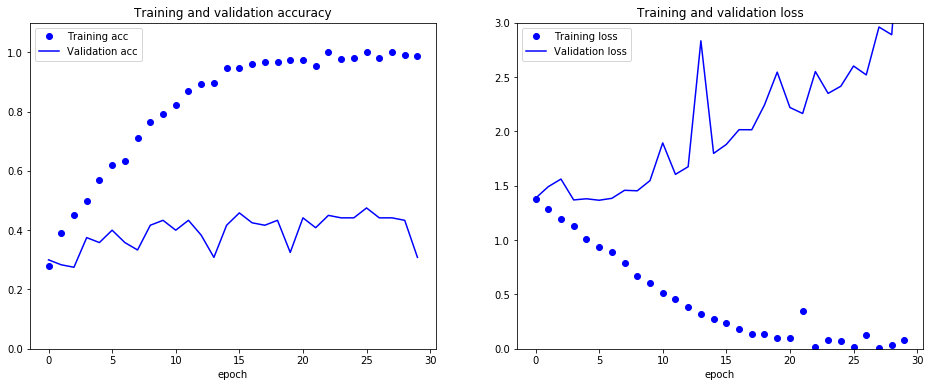

acc=0.99 (val_acc=0.42) | loss=0.05 (val_loss=3.06) | lowest val_loss=1.42

dim_dense=64 | conv2d_1=4 | conv2d_2=8 | conv2d_3=8 | conv2d_4=8


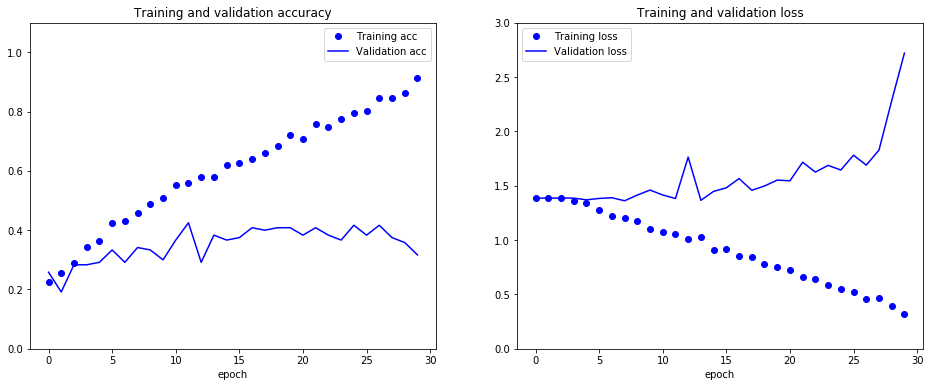

acc=0.85 (val_acc=0.37) | loss=0.43 (val_loss=2.06) | lowest val_loss=1.40

dim_dense=64 | conv2d_1=8 | conv2d_2=8 | conv2d_3=0 | conv2d_4=0
acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=12.09

dim_dense=64 | conv2d_1=8 | conv2d_2=8 | conv2d_3=8 | conv2d_4=0


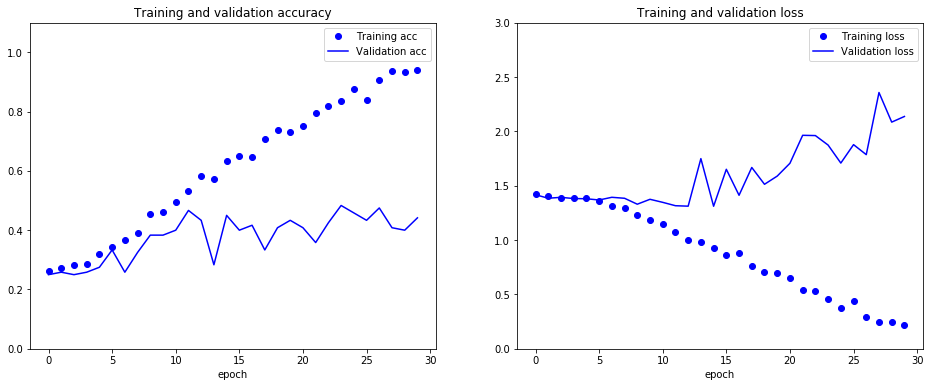

acc=0.91 (val_acc=0.43) | loss=0.29 (val_loss=2.05) | lowest val_loss=1.46

dim_dense=64 | conv2d_1=8 | conv2d_2=8 | conv2d_3=8 | conv2d_4=8


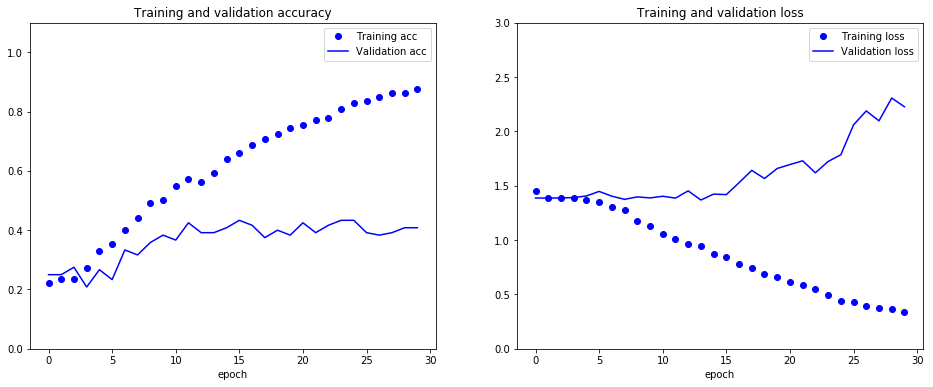

acc=0.86 (val_acc=0.40) | loss=0.38 (val_loss=2.18) | lowest val_loss=1.41

dim_dense=64 | conv2d_1=8 | conv2d_2=16 | conv2d_3=0 | conv2d_4=0
acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=12.09

dim_dense=64 | conv2d_1=8 | conv2d_2=16 | conv2d_3=16 | conv2d_4=0


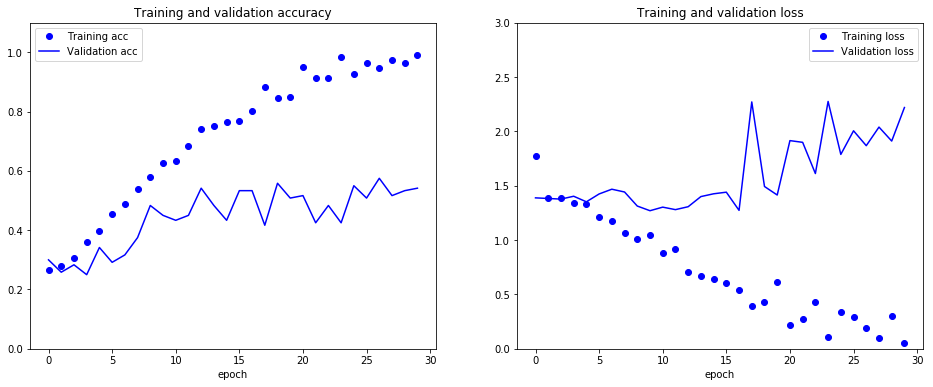

acc=0.97 (val_acc=0.53) | loss=0.19 (val_loss=2.01) | lowest val_loss=1.35

dim_dense=64 | conv2d_1=8 | conv2d_2=16 | conv2d_3=16 | conv2d_4=16


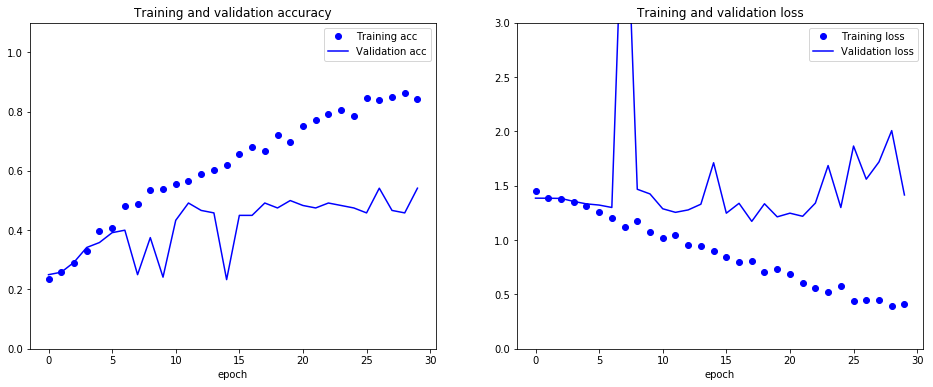

acc=0.85 (val_acc=0.49) | loss=0.43 (val_loss=1.71) | lowest val_loss=1.34

dim_dense=64 | conv2d_1=16 | conv2d_2=16 | conv2d_3=0 | conv2d_4=0
acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=12.09

dim_dense=64 | conv2d_1=16 | conv2d_2=16 | conv2d_3=16 | conv2d_4=0


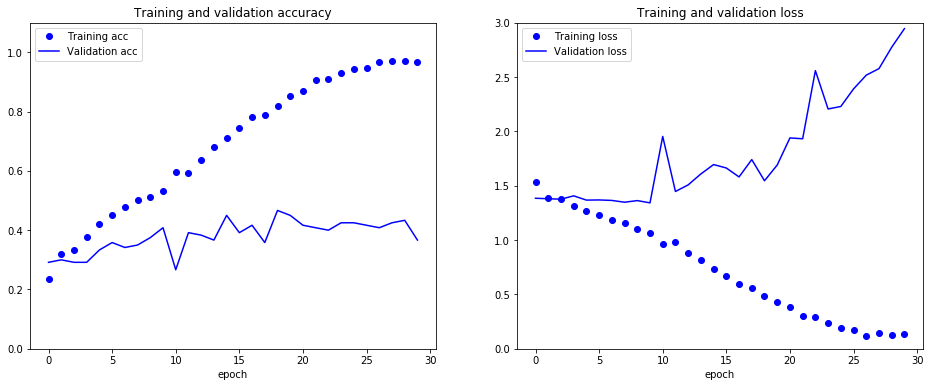

acc=0.96 (val_acc=0.41) | loss=0.14 (val_loss=2.64) | lowest val_loss=1.47

dim_dense=64 | conv2d_1=16 | conv2d_2=16 | conv2d_3=16 | conv2d_4=16


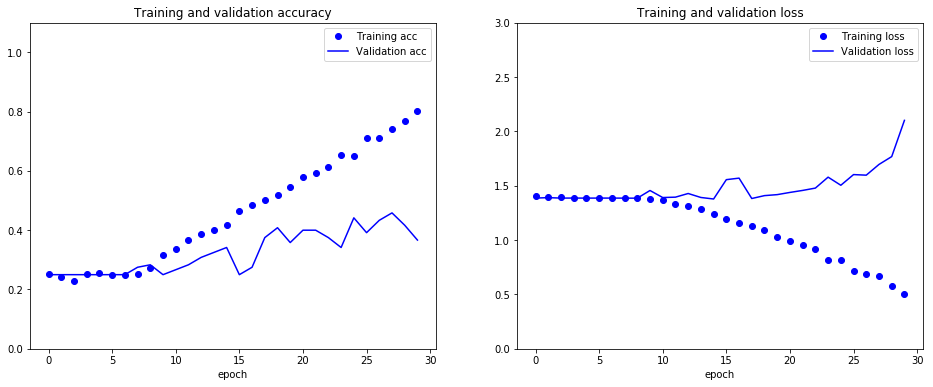

acc=0.75 (val_acc=0.41) | loss=0.63 (val_loss=1.75) | lowest val_loss=1.45

dim_dense=64 | conv2d_1=16 | conv2d_2=32 | conv2d_3=0 | conv2d_4=0
acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=12.09

dim_dense=64 | conv2d_1=16 | conv2d_2=32 | conv2d_3=32 | conv2d_4=0


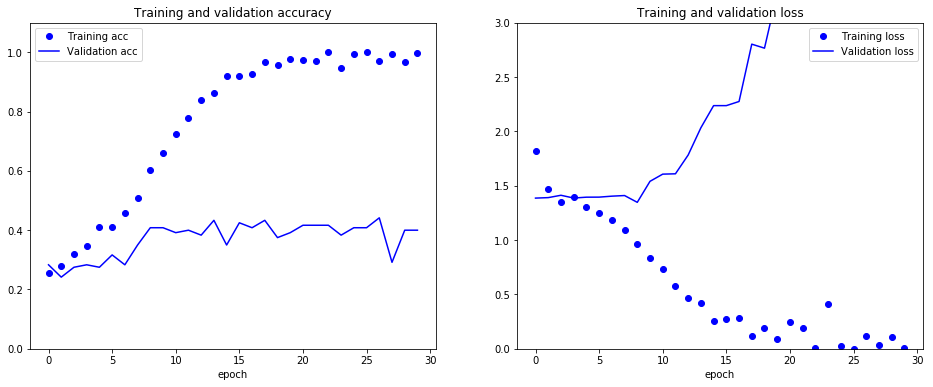

acc=0.99 (val_acc=0.39) | loss=0.05 (val_loss=3.99) | lowest val_loss=1.45

dim_dense=64 | conv2d_1=16 | conv2d_2=32 | conv2d_3=32 | conv2d_4=32


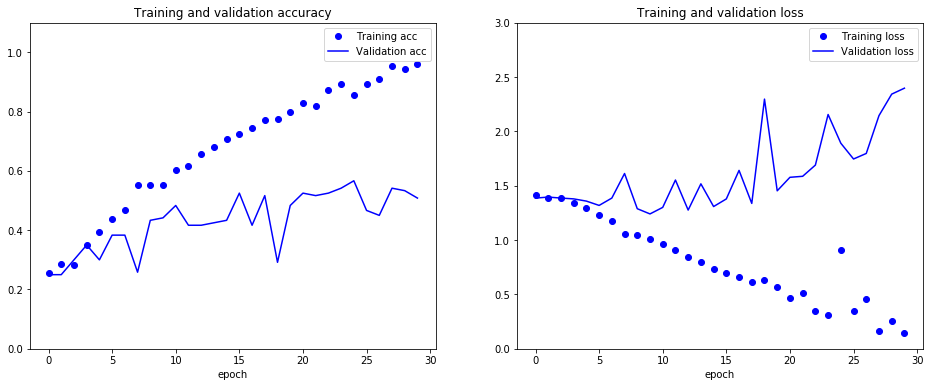

acc=0.93 (val_acc=0.50) | loss=0.27 (val_loss=2.09) | lowest val_loss=1.40

dim_dense=128 | conv2d_1=4 | conv2d_2=4 | conv2d_3=0 | conv2d_4=0


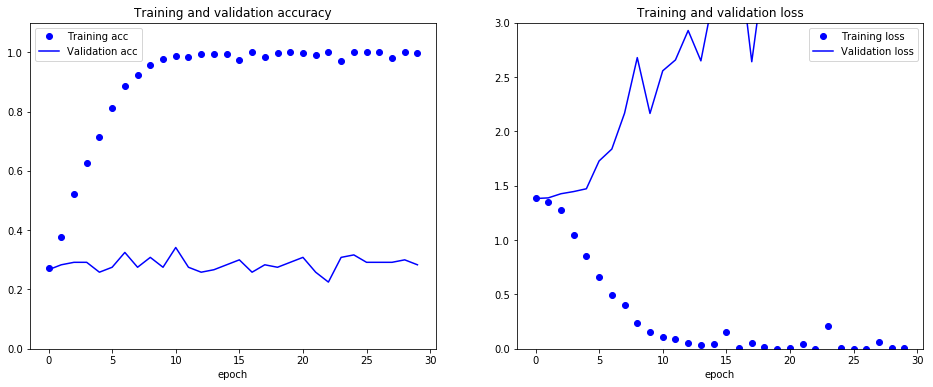

acc=1.00 (val_acc=0.29) | loss=0.02 (val_loss=3.97) | lowest val_loss=1.41

dim_dense=128 | conv2d_1=4 | conv2d_2=4 | conv2d_3=4 | conv2d_4=0


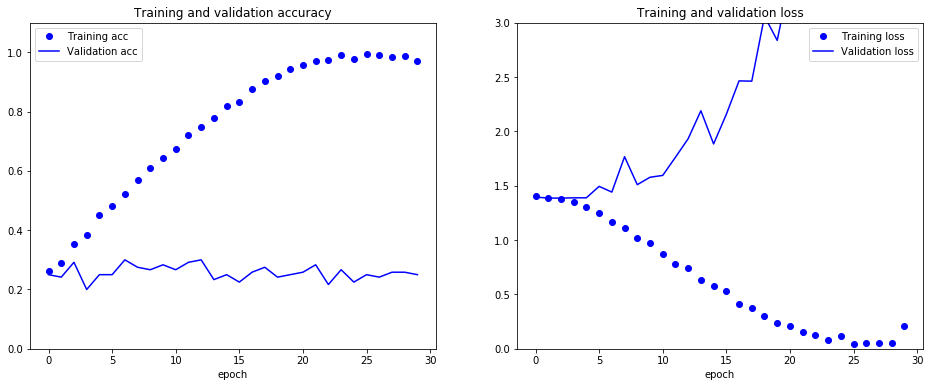

acc=0.99 (val_acc=0.25) | loss=0.09 (val_loss=4.52) | lowest val_loss=1.39

dim_dense=128 | conv2d_1=4 | conv2d_2=4 | conv2d_3=4 | conv2d_4=4


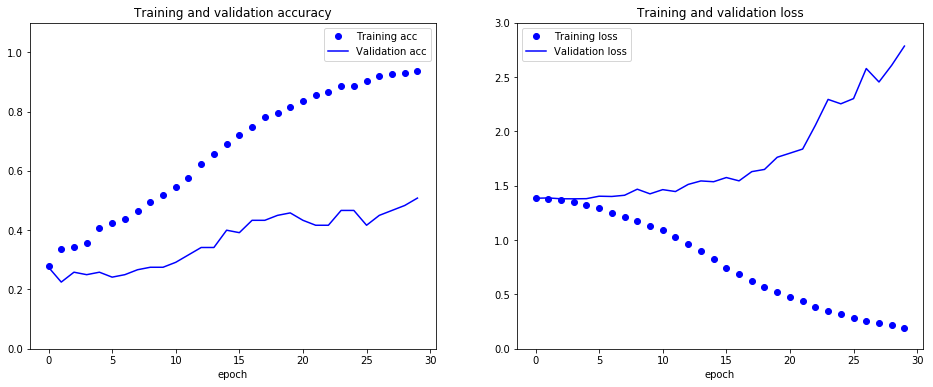

acc=0.92 (val_acc=0.47) | loss=0.24 (val_loss=2.55) | lowest val_loss=1.39

dim_dense=128 | conv2d_1=4 | conv2d_2=8 | conv2d_3=0 | conv2d_4=0
acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=12.09

dim_dense=128 | conv2d_1=4 | conv2d_2=8 | conv2d_3=8 | conv2d_4=0


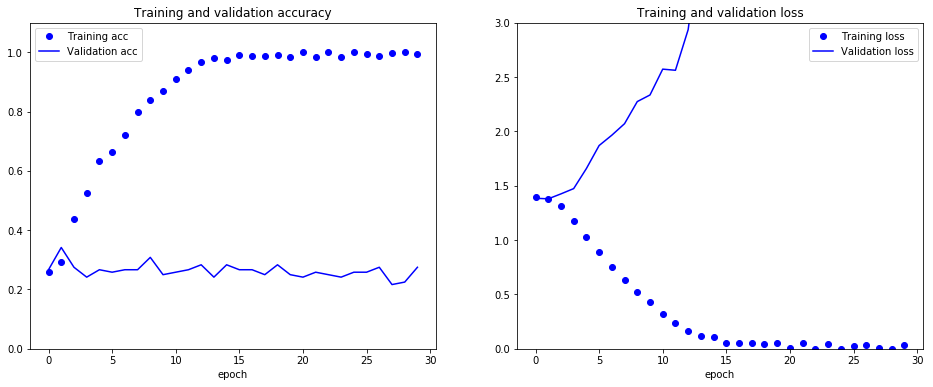

acc=0.99 (val_acc=0.25) | loss=0.02 (val_loss=6.05) | lowest val_loss=1.43

dim_dense=128 | conv2d_1=4 | conv2d_2=8 | conv2d_3=8 | conv2d_4=8


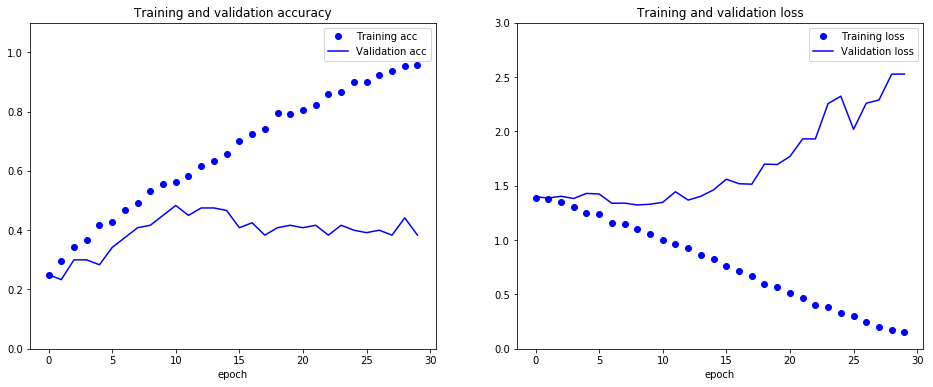

acc=0.93 (val_acc=0.40) | loss=0.21 (val_loss=2.32) | lowest val_loss=1.35

dim_dense=128 | conv2d_1=8 | conv2d_2=8 | conv2d_3=0 | conv2d_4=0
acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=12.09

dim_dense=128 | conv2d_1=8 | conv2d_2=8 | conv2d_3=8 | conv2d_4=0


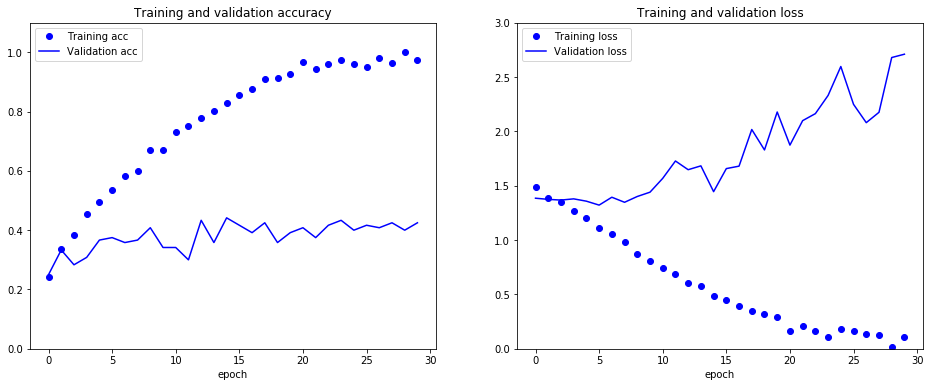

acc=0.97 (val_acc=0.42) | loss=0.11 (val_loss=2.38) | lowest val_loss=1.36

dim_dense=128 | conv2d_1=8 | conv2d_2=8 | conv2d_3=8 | conv2d_4=8


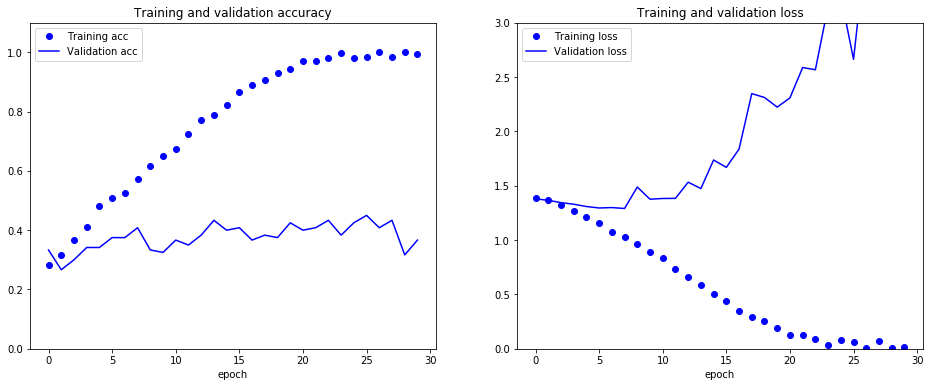

acc=0.99 (val_acc=0.39) | loss=0.03 (val_loss=3.71) | lowest val_loss=1.34

dim_dense=128 | conv2d_1=8 | conv2d_2=16 | conv2d_3=0 | conv2d_4=0
acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=12.09

dim_dense=128 | conv2d_1=8 | conv2d_2=16 | conv2d_3=16 | conv2d_4=0


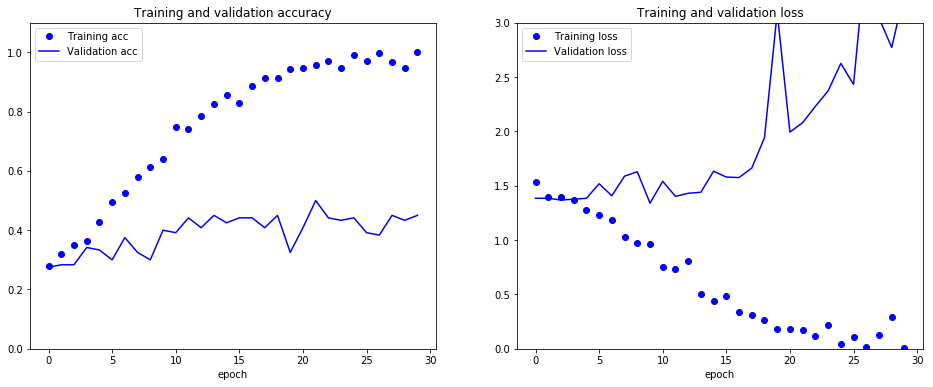

acc=0.98 (val_acc=0.42) | loss=0.11 (val_loss=3.04) | lowest val_loss=1.48

dim_dense=128 | conv2d_1=8 | conv2d_2=16 | conv2d_3=16 | conv2d_4=16


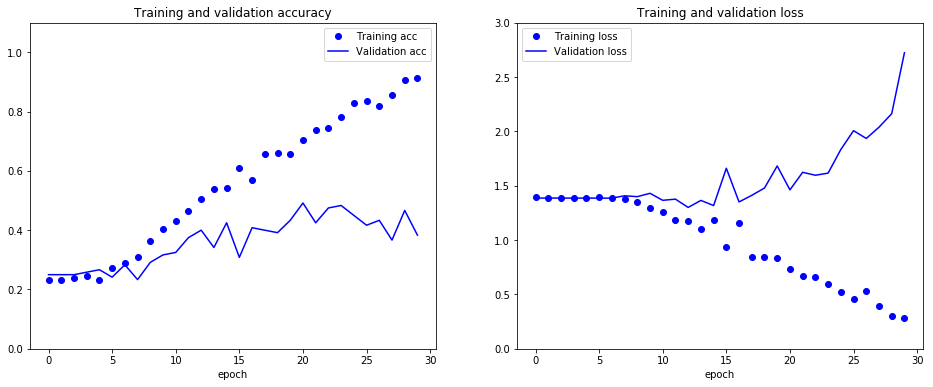

acc=0.87 (val_acc=0.41) | loss=0.40 (val_loss=2.17) | lowest val_loss=1.36

dim_dense=128 | conv2d_1=16 | conv2d_2=16 | conv2d_3=0 | conv2d_4=0
acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=12.09

dim_dense=128 | conv2d_1=16 | conv2d_2=16 | conv2d_3=16 | conv2d_4=0


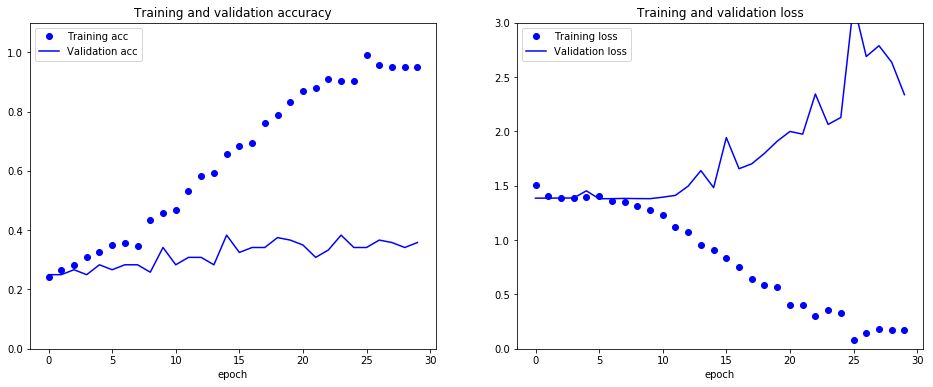

acc=0.96 (val_acc=0.35) | loss=0.15 (val_loss=2.72) | lowest val_loss=1.40

dim_dense=128 | conv2d_1=16 | conv2d_2=16 | conv2d_3=16 | conv2d_4=16


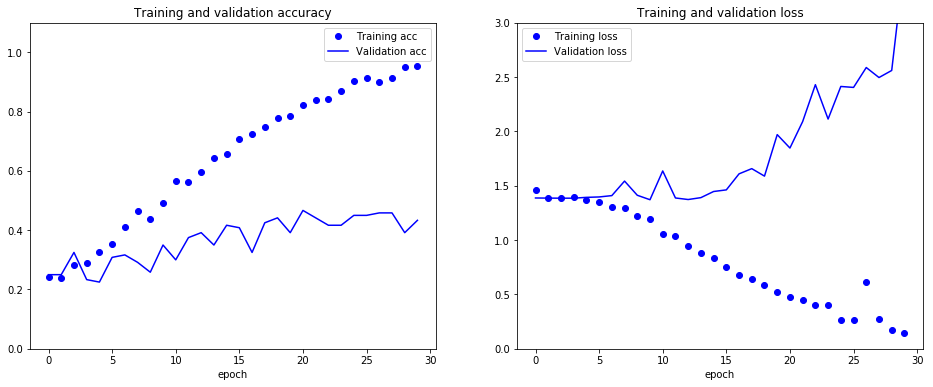

acc=0.93 (val_acc=0.44) | loss=0.30 (val_loss=2.72) | lowest val_loss=1.46

dim_dense=128 | conv2d_1=16 | conv2d_2=32 | conv2d_3=0 | conv2d_4=0
acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=12.09

dim_dense=128 | conv2d_1=16 | conv2d_2=32 | conv2d_3=32 | conv2d_4=0


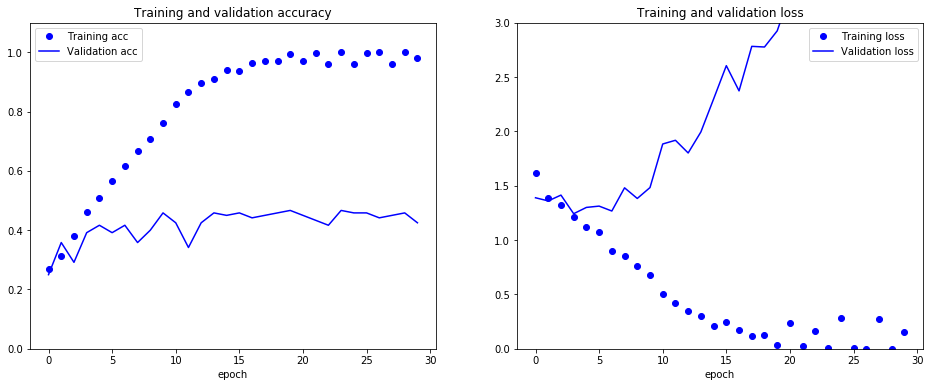

acc=0.99 (val_acc=0.45) | loss=0.09 (val_loss=4.32) | lowest val_loss=1.33

dim_dense=128 | conv2d_1=16 | conv2d_2=32 | conv2d_3=32 | conv2d_4=32


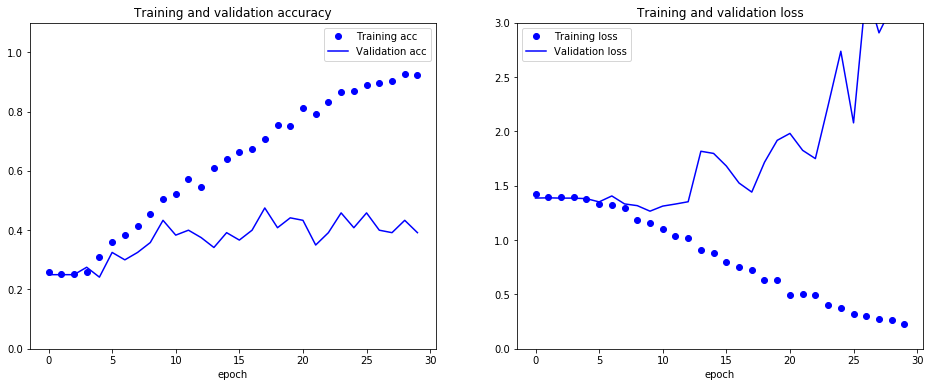

acc=0.91 (val_acc=0.42) | loss=0.28 (val_loss=2.99) | lowest val_loss=1.33


Best models:
         acc  dim_conv2d_1  dim_conv2d_2  dim_conv2d_3  dim_conv2d_4  \
0   0.808519           8.0           8.0           8.0           0.0   
1   0.960000          16.0          16.0           0.0           0.0   
2   0.967963          16.0          32.0           0.0           0.0   
3   0.938519           8.0           8.0           8.0           0.0   
4   0.958889           8.0          16.0           0.0           0.0   
5   0.977037           8.0          16.0          16.0           0.0   
6   0.981667          16.0          16.0           0.0           0.0   
7   0.984259          16.0          32.0          32.0           0.0   
8   0.991296           4.0           4.0           4.0           0.0   
9   0.977407           8.0           8.0           0.0           0.0   
10  0.960556           8.0           8.0           8.0           0.0   
11  0.986111           8.0           8.0      

In [159]:
### 4) Modeling the Data, First Pass
###     Section 4.5) Build matrix of layer parameters

list__dim_dense = [8, 16, 32, 64, 128]
list__dim_conv2d_1 = [4, 8, 16]


I_min_acc = 0.8
dfRes = pandas.DataFrame()

for dim_dense in list__dim_dense:
    for dim_conv2d_1 in list__dim_conv2d_1:
        for dim_conv2d_2 in [dim_conv2d_1, 2*dim_conv2d_1]:
            for dim_conv2d_3 in [0, dim_conv2d_2]:
                
                if dim_conv2d_3 == 0:
                    list__dim_conv2d_4 = [0]
                else:
                    list__dim_conv2d_4 = [0, dim_conv2d_3]
                
                for dim_conv2d_4 in list__dim_conv2d_4:

                    print("\ndim_dense=" + str(dim_dense) + 
                          " | conv2d_1=" + str(dim_conv2d_1) + 
                          " | conv2d_2=" + str(dim_conv2d_2) + 
                          " | conv2d_3=" + str(dim_conv2d_3) + 
                          " | conv2d_4=" + str(dim_conv2d_4))

                    # Build model
                    model = build_model_w6(img_dim=img_dim,
                                           nClass=len(dictClass.keys()),
                                           optimizer=optimizer,
                                           dim_conv2d_1=dim_conv2d_1,
                                           dim_conv2d_2=dim_conv2d_2,
                                           dim_conv2d_3=dim_conv2d_3,
                                           dim_conv2d_4=dim_conv2d_4,
                                           dim_dense=dim_dense)
                    # Fit model
                    model_history = fit_model_w6(model=model,
                         train_generator=train_generator,
                         validation_generator=validation_generator,
                         epochs=epochs,
                         steps_per_epoch=len(train_generator),
                         validation_steps=len(validation_generator),
                         verbose=0)
                    # Evaluate model
                    msg, avg_acc, avg_val_acc, avg_loss, avg_val_loss, val_loss_lowest = \
                      eval_model_w6(model_history=model_history, I_plot__min_acc=I_min_acc)
                    
                    print(msg)
                    
                    if avg_acc >= I_min_acc:
                        dfRes = dfRes.append(
                            {'dim_dense': dim_dense,
                             'dim_conv2d_1': dim_conv2d_1,
                             'dim_conv2d_2': dim_conv2d_2,
                             'dim_conv2d_3': dim_conv2d_3,
                             'dim_conv2d_4': dim_conv2d_4,
                             'acc': avg_acc,
                             'val_acc': avg_val_acc,
                             'loss': avg_loss,
                             'val_loss': avg_val_loss,
                             'val_loss_lowest': val_loss_lowest}, ignore_index=True)

print("\n\nBest models:")
print(dfRes)

In [160]:
# Take results with best 'val_acc' and 'val_loss'
dfRes2 = dfRes[dfRes['val_acc'] >= np.mean(dfRes['val_acc'])]
dfRes2 = dfRes2[dfRes2['val_loss'] <= np.mean(dfRes2['val_loss'])]

# # Gather 'dim_dense' value with greatest count
# dim_dense = np.argmax( dfRes2.groupby('dim_dense').count()['acc'] )
# # Isolate to entries with matching 'dim_dense'
# dfRes2 = dfRes2[dfRes2['dim_dense']==dim_dense]
# # Gather 'dim_conv2d_1' value with greatest count
# dim_conv2d_1 = np.argmax( dfRes2.groupby('dim_conv2d_1').count()['acc'] )
# # Isolate to entries with matching 'dim_conv2d_1'
# dfRes2 = dfRes2[dfRes2['dim_conv2d_1']==dim_conv2d_1]

print(dfRes2)

         acc  dim_conv2d_1  dim_conv2d_2  dim_conv2d_3  dim_conv2d_4  \
0   0.808519           8.0           8.0           8.0           0.0   
2   0.967963          16.0          32.0           0.0           0.0   
9   0.977407           8.0           8.0           0.0           0.0   
14  0.881111          16.0          32.0          32.0          32.0   
16  0.825185           4.0           4.0           4.0           0.0   
19  0.911296           8.0           8.0           8.0           0.0   
21  0.967407           8.0          16.0          16.0           0.0   
22  0.847593           8.0          16.0          16.0          16.0   
25  0.931481          16.0          32.0          32.0          32.0   
30  0.934259           4.0           8.0           8.0           8.0   
31  0.974630           8.0           8.0           8.0           0.0   
34  0.865741           8.0          16.0          16.0          16.0   

    dim_dense      loss   val_acc  val_loss  val_loss_lowest  


It is not clear if there is a particular setting which stands out. The results do allow us to at least through some configurations out. As there is only one entry with dim_conv2d_1 = 4, we can remove this from consideration. Given that all values of dim_dense are represented, we can remove the smallest and largest values, which are 8 and 128, respectively.

We will now narrow the possible configurations and run the same test with the medium dataset. We will restrict

- dim_dense to 16, 32, and 64

- dim_conv2d_1 to 8 and 16.

In [161]:
list__dim_dense = [16, 32, 64]
list__dim_conv2d_1 = [8, 16]

In [162]:
### 4) Modeling the Data, First Pass
###     Section 4.6) Prepare run on medium set

# User-defined parameters
#   Which dataset
dataset = 'medium'
#   Toggle between using down-sampled or full images
I_downsample = True
#   Set ImageDataGenerator batch size
ImgDatGen__batch_size = 32
#   Number of epochs
epochs=100
#   Optimizer and settings
#     Currently not changing optimizer settings, such as learning rate
optimizer='rmsprop'

# Get handles to ImageeDataGenerator objects
img_dim, train_generator, validation_generator = prep_main(
    dataset=dataset, I_downsample=I_downsample, dictImgProp=dictImgProp, 
    ImgDatGen__batch_size=ImgDatGen__batch_size)

Found 3240 images belonging to 4 classes.
Found 360 images belonging to 4 classes.
data batch shape: (32, 120, 160, 3)
labels batch shape: (32, 4)




dim_dense=16 | conv2d_1=8 | conv2d_2=8 | conv2d_3=0 | conv2d_4=0
acc=0.24 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39


dim_dense=16 | conv2d_1=8 | conv2d_2=8 | conv2d_3=8 | conv2d_4=0


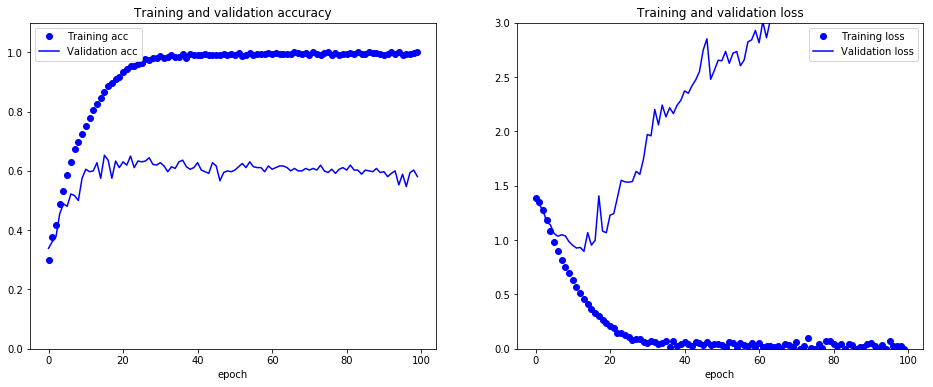

acc=1.00 (val_acc=0.59) | loss=0.03 (val_loss=3.82) | lowest val_loss=1.04


dim_dense=16 | conv2d_1=8 | conv2d_2=8 | conv2d_3=8 | conv2d_4=8


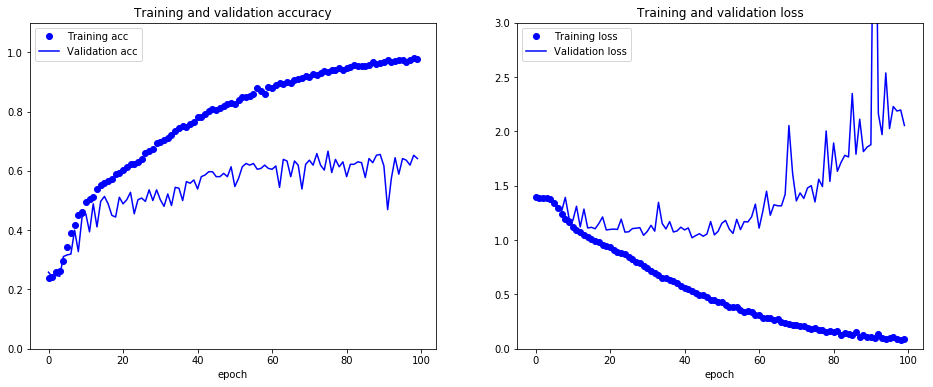

acc=0.97 (val_acc=0.62) | loss=0.11 (val_loss=2.30) | lowest val_loss=1.09


dim_dense=16 | conv2d_1=8 | conv2d_2=16 | conv2d_3=0 | conv2d_4=0
acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=12.09


dim_dense=16 | conv2d_1=8 | conv2d_2=16 | conv2d_3=16 | conv2d_4=0
acc=0.24 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39


dim_dense=16 | conv2d_1=8 | conv2d_2=16 | conv2d_3=16 | conv2d_4=16


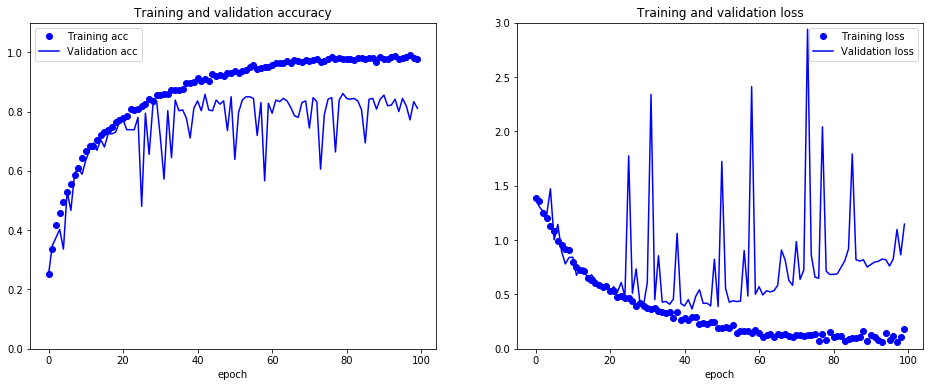

acc=0.98 (val_acc=0.82) | loss=0.11 (val_loss=0.91) | lowest val_loss=0.49


dim_dense=16 | conv2d_1=16 | conv2d_2=16 | conv2d_3=0 | conv2d_4=0
acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=12.09


dim_dense=16 | conv2d_1=16 | conv2d_2=16 | conv2d_3=16 | conv2d_4=0
acc=0.24 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39


dim_dense=16 | conv2d_1=16 | conv2d_2=16 | conv2d_3=16 | conv2d_4=16
acc=0.24 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39


dim_dense=16 | conv2d_1=16 | conv2d_2=32 | conv2d_3=0 | conv2d_4=0


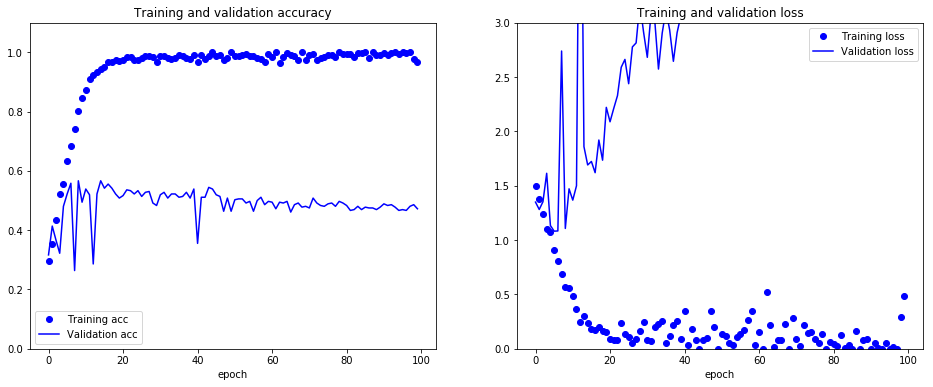

acc=0.99 (val_acc=0.48) | loss=0.08 (val_loss=5.01) | lowest val_loss=1.78


dim_dense=16 | conv2d_1=16 | conv2d_2=32 | conv2d_3=32 | conv2d_4=0
acc=0.24 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39


dim_dense=16 | conv2d_1=16 | conv2d_2=32 | conv2d_3=32 | conv2d_4=32
acc=0.24 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39


dim_dense=32 | conv2d_1=8 | conv2d_2=8 | conv2d_3=0 | conv2d_4=0


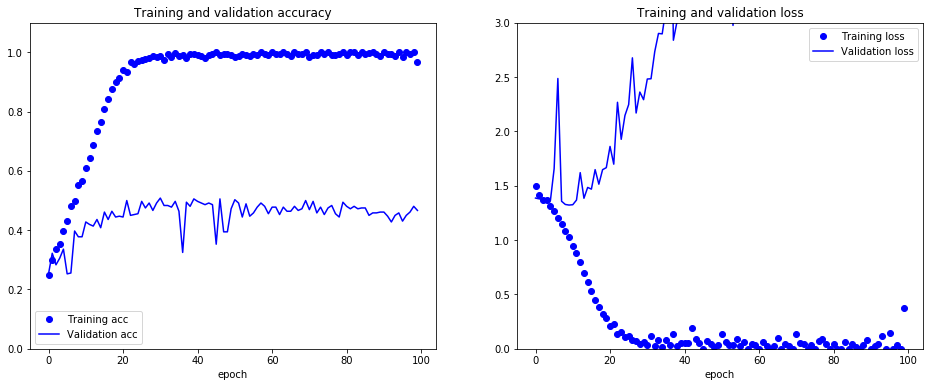

acc=0.99 (val_acc=0.46) | loss=0.06 (val_loss=4.86) | lowest val_loss=1.50


dim_dense=32 | conv2d_1=8 | conv2d_2=8 | conv2d_3=8 | conv2d_4=0


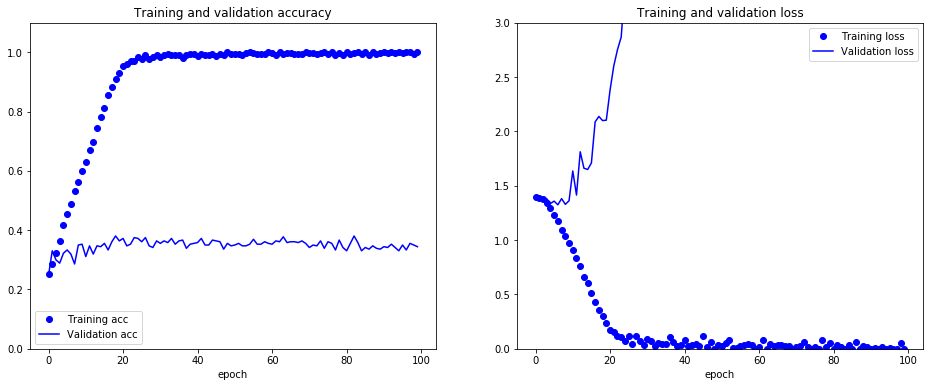

acc=1.00 (val_acc=0.34) | loss=0.01 (val_loss=6.45) | lowest val_loss=1.44


dim_dense=32 | conv2d_1=8 | conv2d_2=8 | conv2d_3=8 | conv2d_4=8


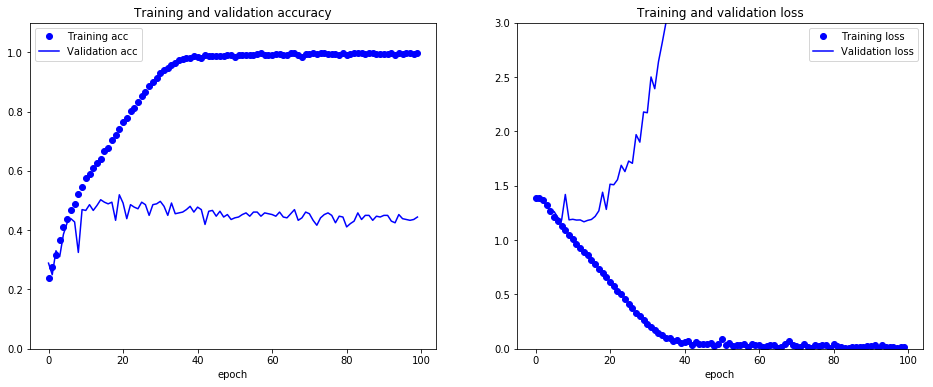

acc=1.00 (val_acc=0.44) | loss=0.02 (val_loss=5.39) | lowest val_loss=1.25


dim_dense=32 | conv2d_1=8 | conv2d_2=16 | conv2d_3=0 | conv2d_4=0
acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=12.09


dim_dense=32 | conv2d_1=8 | conv2d_2=16 | conv2d_3=16 | conv2d_4=0


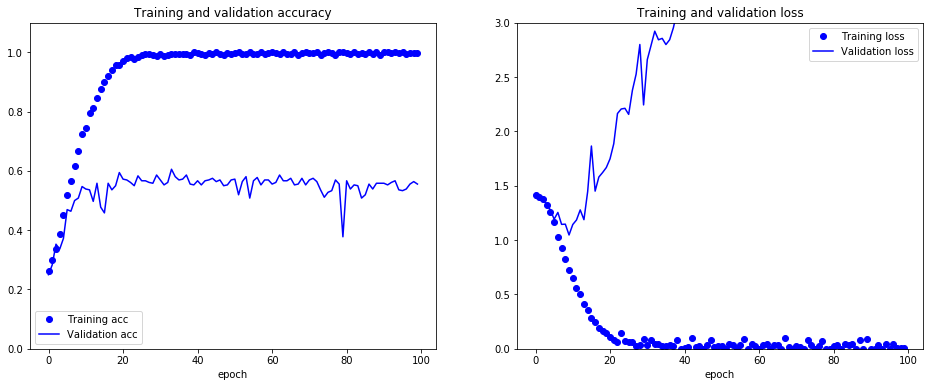

acc=1.00 (val_acc=0.55) | loss=0.02 (val_loss=4.50) | lowest val_loss=1.29


dim_dense=32 | conv2d_1=8 | conv2d_2=16 | conv2d_3=16 | conv2d_4=16


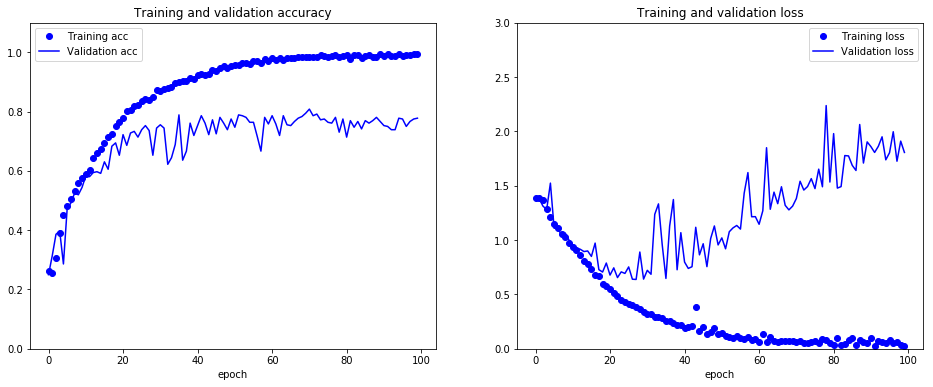

acc=0.99 (val_acc=0.76) | loss=0.06 (val_loss=1.83) | lowest val_loss=0.80


dim_dense=32 | conv2d_1=16 | conv2d_2=16 | conv2d_3=0 | conv2d_4=0


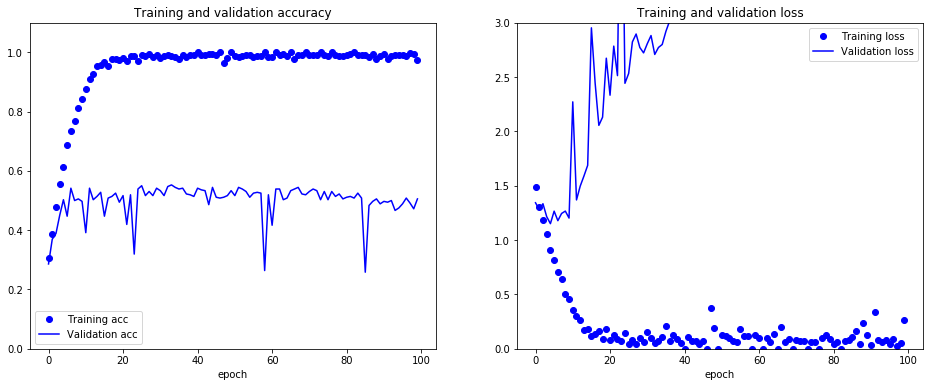

acc=0.99 (val_acc=0.48) | loss=0.12 (val_loss=5.01) | lowest val_loss=1.34


dim_dense=32 | conv2d_1=16 | conv2d_2=16 | conv2d_3=16 | conv2d_4=0


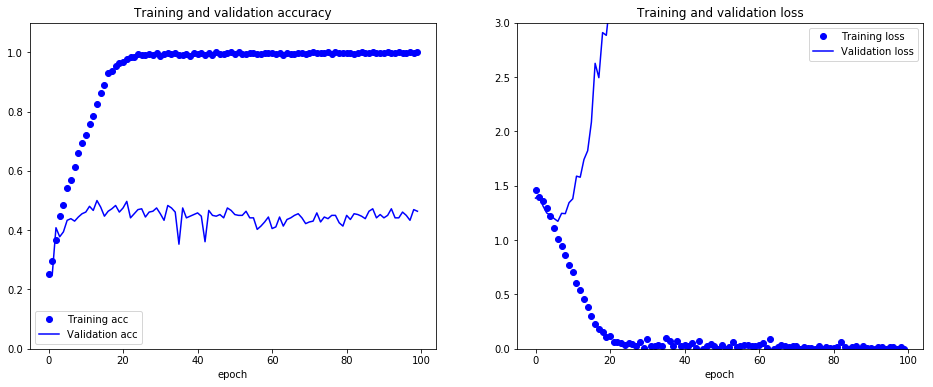

acc=1.00 (val_acc=0.45) | loss=0.01 (val_loss=6.31) | lowest val_loss=1.36


dim_dense=32 | conv2d_1=16 | conv2d_2=16 | conv2d_3=16 | conv2d_4=16


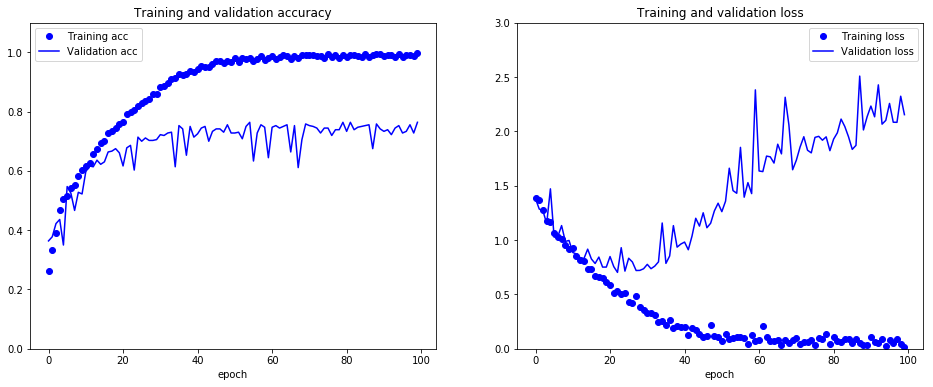

acc=0.99 (val_acc=0.74) | loss=0.06 (val_loss=2.15) | lowest val_loss=0.79


dim_dense=32 | conv2d_1=16 | conv2d_2=32 | conv2d_3=0 | conv2d_4=0


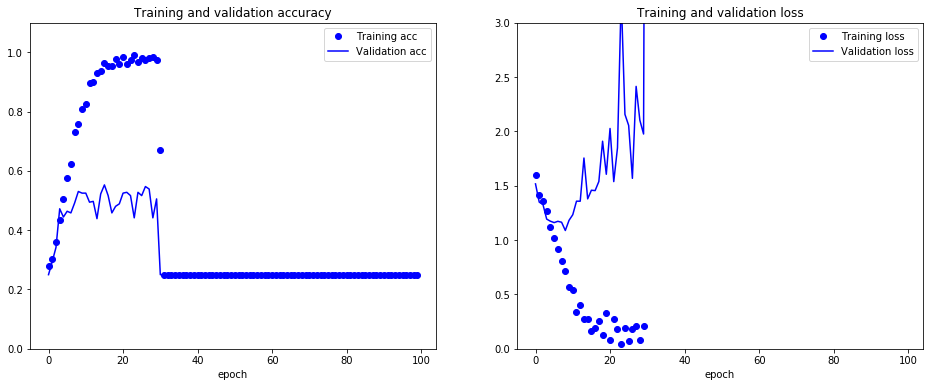

acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=1.29


dim_dense=32 | conv2d_1=16 | conv2d_2=32 | conv2d_3=32 | conv2d_4=0


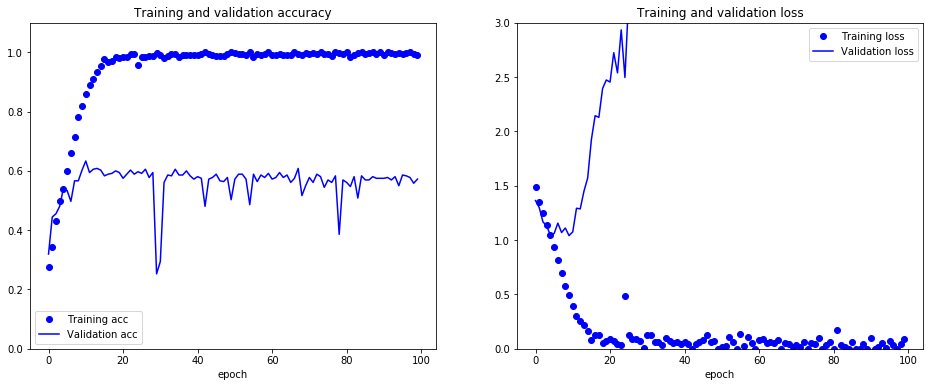

acc=1.00 (val_acc=0.57) | loss=0.03 (val_loss=4.78) | lowest val_loss=1.30


dim_dense=32 | conv2d_1=16 | conv2d_2=32 | conv2d_3=32 | conv2d_4=32


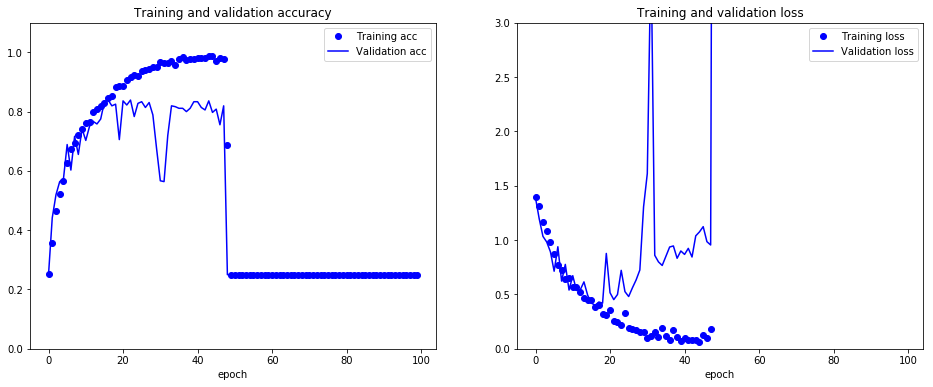

acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=0.56


dim_dense=64 | conv2d_1=8 | conv2d_2=8 | conv2d_3=0 | conv2d_4=0


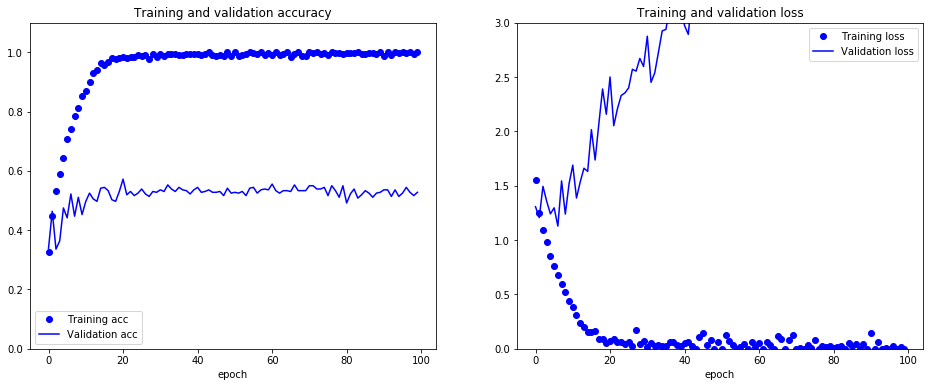

acc=1.00 (val_acc=0.53) | loss=0.02 (val_loss=4.25) | lowest val_loss=1.41


dim_dense=64 | conv2d_1=8 | conv2d_2=8 | conv2d_3=8 | conv2d_4=0


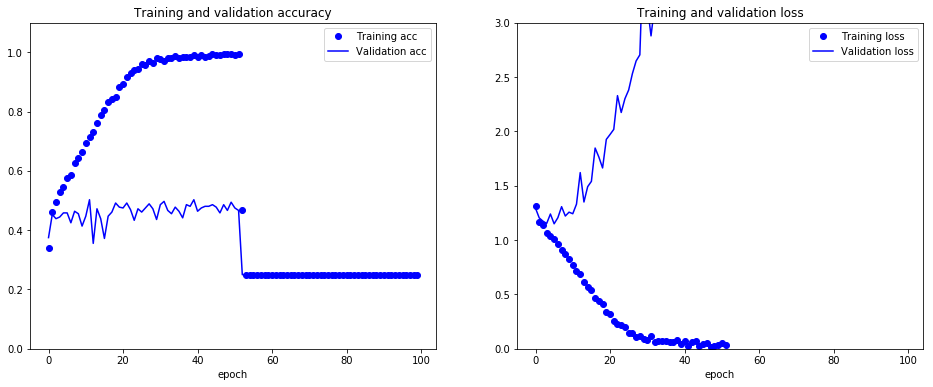

acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=1.26


dim_dense=64 | conv2d_1=8 | conv2d_2=8 | conv2d_3=8 | conv2d_4=8


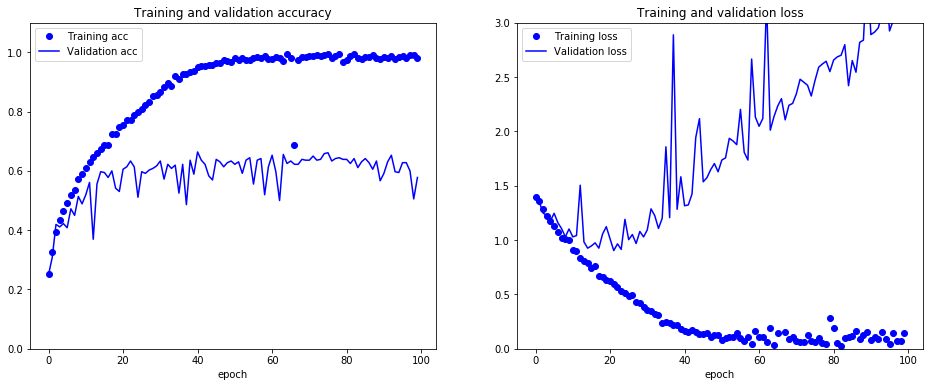

acc=0.98 (val_acc=0.61) | loss=0.11 (val_loss=3.10) | lowest val_loss=1.00


dim_dense=64 | conv2d_1=8 | conv2d_2=16 | conv2d_3=0 | conv2d_4=0
acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=12.09


dim_dense=64 | conv2d_1=8 | conv2d_2=16 | conv2d_3=16 | conv2d_4=0


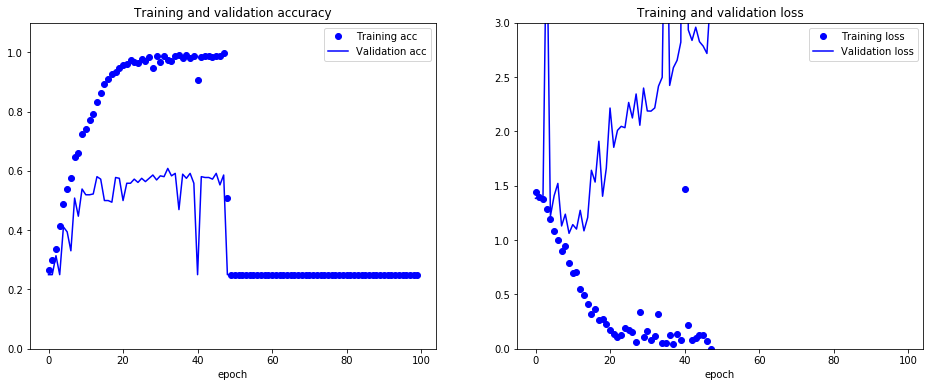

acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=1.46


dim_dense=64 | conv2d_1=8 | conv2d_2=16 | conv2d_3=16 | conv2d_4=16


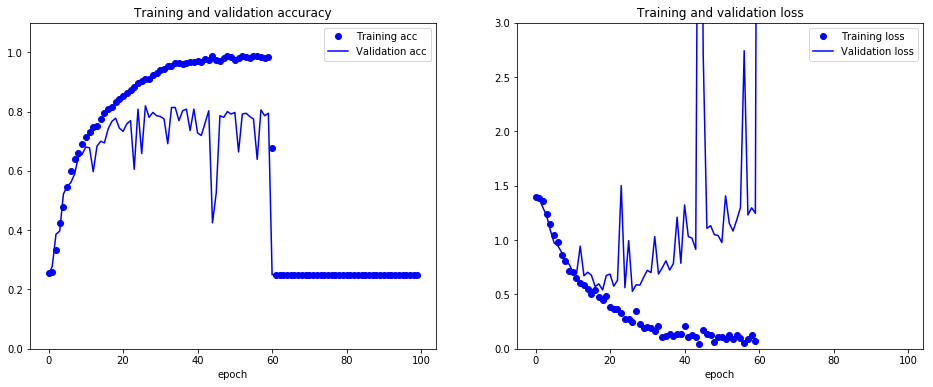

acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=0.73


dim_dense=64 | conv2d_1=16 | conv2d_2=16 | conv2d_3=0 | conv2d_4=0
acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=12.09


dim_dense=64 | conv2d_1=16 | conv2d_2=16 | conv2d_3=16 | conv2d_4=0


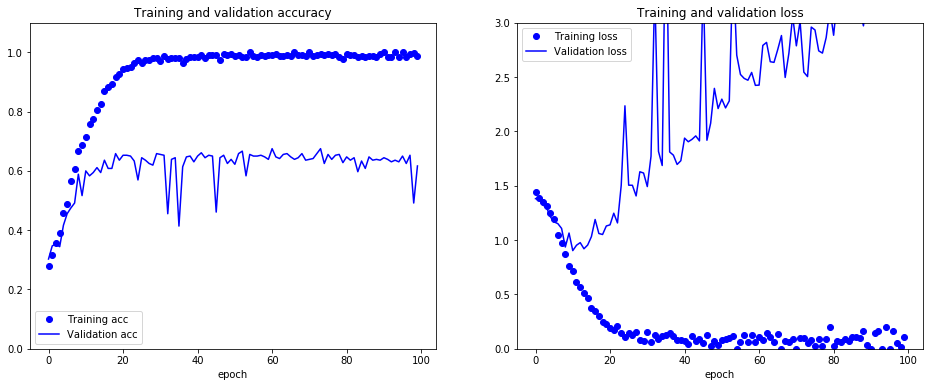

acc=0.99 (val_acc=0.63) | loss=0.09 (val_loss=3.43) | lowest val_loss=1.08


dim_dense=64 | conv2d_1=16 | conv2d_2=16 | conv2d_3=16 | conv2d_4=16


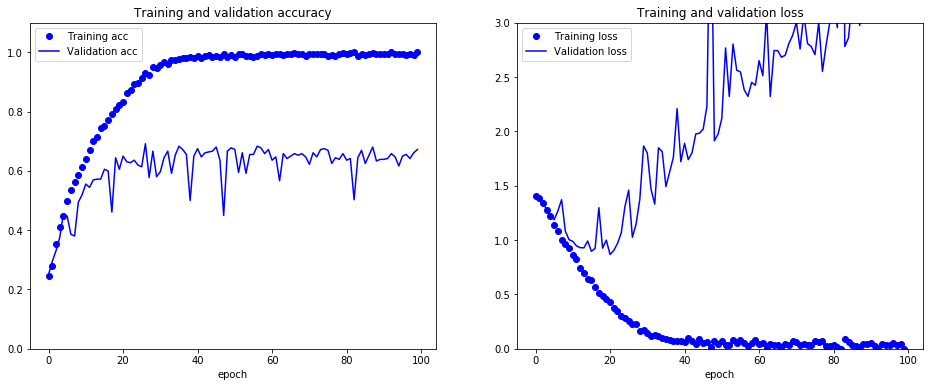

acc=0.99 (val_acc=0.65) | loss=0.03 (val_loss=3.22) | lowest val_loss=1.04


dim_dense=64 | conv2d_1=16 | conv2d_2=32 | conv2d_3=0 | conv2d_4=0
acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=12.09


dim_dense=64 | conv2d_1=16 | conv2d_2=32 | conv2d_3=32 | conv2d_4=0


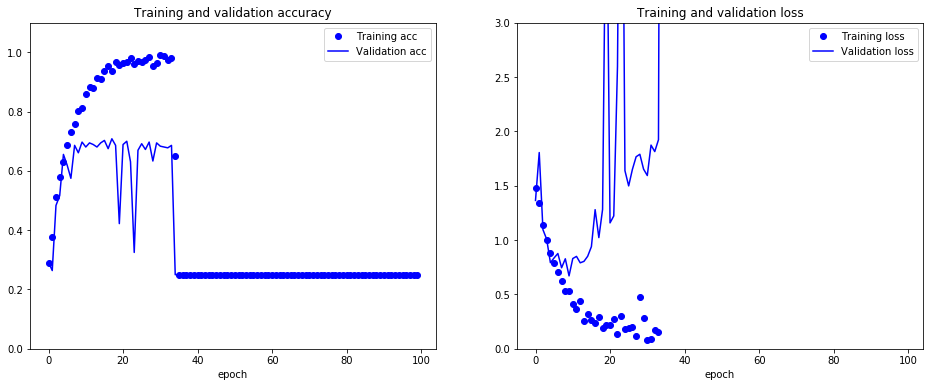

acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=0.94


dim_dense=64 | conv2d_1=16 | conv2d_2=32 | conv2d_3=32 | conv2d_4=32


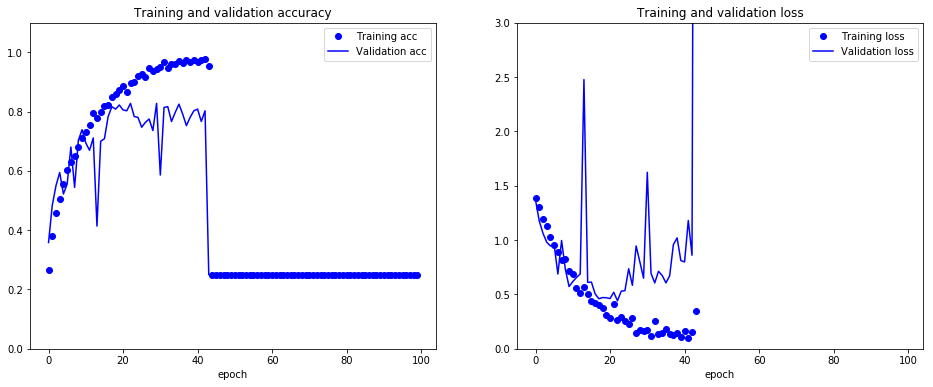

acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=0.58


Best models:
         acc  dim_conv2d_1  dim_conv2d_2  dim_conv2d_3  dim_conv2d_4  \
0   0.995802           8.0           8.0           8.0           0.0   
1   0.968580           8.0           8.0           8.0           8.0   
2   0.980617           8.0          16.0          16.0          16.0   
3   0.992366          16.0          32.0           0.0           0.0   
4   0.992716           8.0           8.0           0.0           0.0   
5   0.998066           8.0           8.0           8.0           0.0   
6   0.995556           8.0           8.0           8.0           8.0   
7   0.997428           8.0          16.0          16.0           0.0   
8   0.989897           8.0          16.0          16.0          16.0   
9   0.987901          16.0          16.0           0.0           0.0   
10  0.998333          16.0          16.0          16.0           0.0   
11  0.990309          16.0          16.0    

In [163]:
### 4) Modeling the Data, First Pass
###     Section 4.7) Build, fit and evaluate with medium set

I_min_acc = 0.9
dfRes = pandas.DataFrame()

for dim_dense in list__dim_dense:
    for dim_conv2d_1 in list__dim_conv2d_1:
        for dim_conv2d_2 in [dim_conv2d_1, 2*dim_conv2d_1]:
            for dim_conv2d_3 in [0, dim_conv2d_2]:
                
                if dim_conv2d_3 == 0:
                    list__dim_conv2d_4 = [0]
                else:
                    list__dim_conv2d_4 = [0, dim_conv2d_3]
                
                for dim_conv2d_4 in list__dim_conv2d_4:

                    print("\n\ndim_dense=" + str(dim_dense) + 
                          " | conv2d_1=" + str(dim_conv2d_1) + 
                          " | conv2d_2=" + str(dim_conv2d_2) + 
                          " | conv2d_3=" + str(dim_conv2d_3) + 
                          " | conv2d_4=" + str(dim_conv2d_4))

                    # Build model
                    model = build_model_w6(img_dim=img_dim,
                                           nClass=len(dictClass.keys()),
                                           optimizer=optimizer,
                                           dim_conv2d_1=dim_conv2d_1,
                                           dim_conv2d_2=dim_conv2d_2,
                                           dim_conv2d_3=dim_conv2d_3,
                                           dim_conv2d_4=dim_conv2d_4,
                                           dim_dense=dim_dense)
                    # Fit model
                    model_history = fit_model_w6(model=model,
                         train_generator=train_generator,
                         validation_generator=validation_generator,
                         epochs=epochs,
                         steps_per_epoch=len(train_generator),
                         validation_steps=len(validation_generator),
                         verbose=0)
                    # Evaluate model
                    msg, avg_acc, avg_val_acc, avg_loss, avg_val_loss, val_loss_lowest = \
                      eval_model_w6(model_history=model_history, I_plot__min_acc=I_min_acc)
                    
                    print(msg)
                    
                    if avg_acc >= I_min_acc:
                        dfRes = dfRes.append(
                            {'dim_dense': dim_dense,
                             'dim_conv2d_1': dim_conv2d_1,
                             'dim_conv2d_2': dim_conv2d_2,
                             'dim_conv2d_3': dim_conv2d_3,
                             'dim_conv2d_4': dim_conv2d_4,
                             'acc': avg_acc,
                             'val_acc': avg_val_acc,
                             'loss': avg_loss,
                             'val_loss': avg_val_loss,
                             'val_loss_lowest': val_loss_lowest}, ignore_index=True)

print("\n\nBest models:")
print(dfRes)

In [164]:
# Take results with best 'val_acc' and 'val_loss'
dfRes2 = dfRes[dfRes['val_acc'] >= np.mean(dfRes['val_acc'])]
dfRes2 = dfRes2[dfRes2['val_loss'] <= np.mean(dfRes2['val_loss'])]
print(dfRes2)

         acc  dim_conv2d_1  dim_conv2d_2  dim_conv2d_3  dim_conv2d_4  \
1   0.968580           8.0           8.0           8.0           8.0   
2   0.980617           8.0          16.0          16.0          16.0   
8   0.989897           8.0          16.0          16.0          16.0   
11  0.990309          16.0          16.0          16.0          16.0   

    dim_dense      loss   val_acc  val_loss  val_loss_lowest  
1        16.0  0.109379  0.616111  2.301240         1.088633  
2        16.0  0.107267  0.816667  0.913931         0.493481  
8        32.0  0.059273  0.763333  1.830691         0.797873  
11       32.0  0.058825  0.738889  2.148324         0.789703  


There is no clear selection to be made at this point. The configuration which appears to be the most "in the middle" is:

- dim_dense = 32

- dim_conv2d_1 = 8

- dim_conv2d_2 = 16 = dim_conv2d_3 = dim_conv2d_4

We will use this configuration to look at the impact of other parameters.

=================================================

Section 5: Looking at Steps-Per-Epoch and Batch-Size (Image Data Generator)

In [165]:
### 5) Looking at Steps-Per-Epoch and Batch-Size (Image Data Generator)
###     Section 5.0) Set user-defined parameters

# Define list of Steps-Per-Epochs to try
#   As factor of length( handle_data_generator )
list_step_factor = [1, 2, 5, 10]

# Define list of Batch-Sizes (Image Data Generator) to try
list_batch_size = [8, 16, 32, 64, 96, 128]


# Layer parameters found in (4)
dim_dense = 32
dim_conv2d_1 = 8
dim_conv2d_2 = 16
dim_conv2d_3 = 16
dim_conv2d_4 = 16


# Which dataset
dataset = 'medium'

# Toggle between using down-sampled or full images
I_downsample = True
#   Set ImageDataGenerator batch size
ImgDatGen__batch_size = 32
# Number of epochs
epochs=50
#   Optimizer
optimizer='rmsprop'


I_min_acc = 0.9

Found 3240 images belonging to 4 classes.
Found 360 images belonging to 4 classes.
data batch shape: (32, 120, 160, 3)
labels batch shape: (32, 4)


step_factor=1


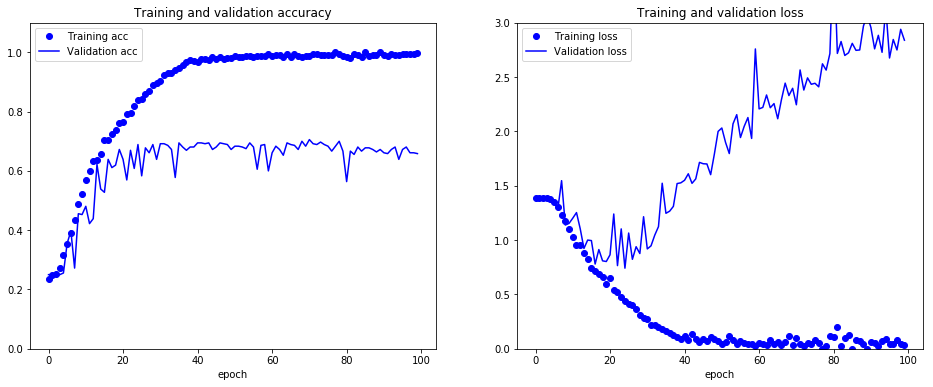

acc=0.99 (val_acc=0.67) | loss=0.05 (val_loss=2.86) | lowest val_loss=0.93


step_factor=2


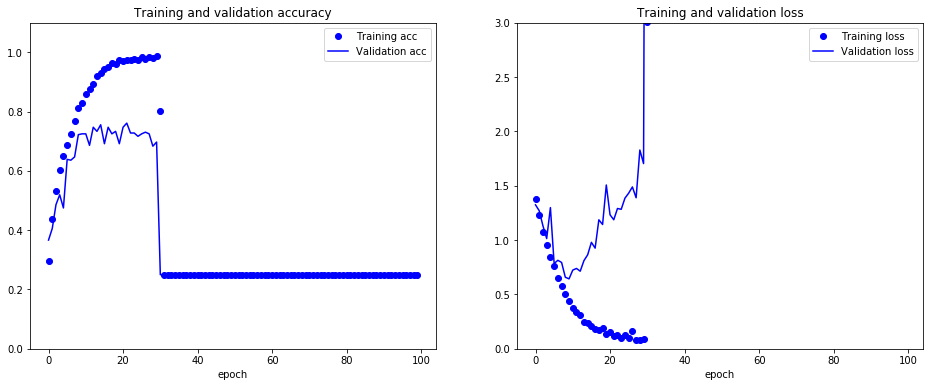

acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=0.89


step_factor=5


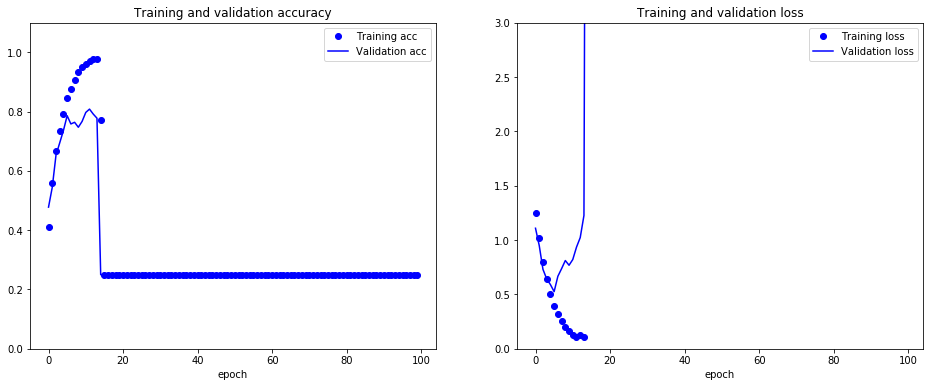

acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=0.77


step_factor=10


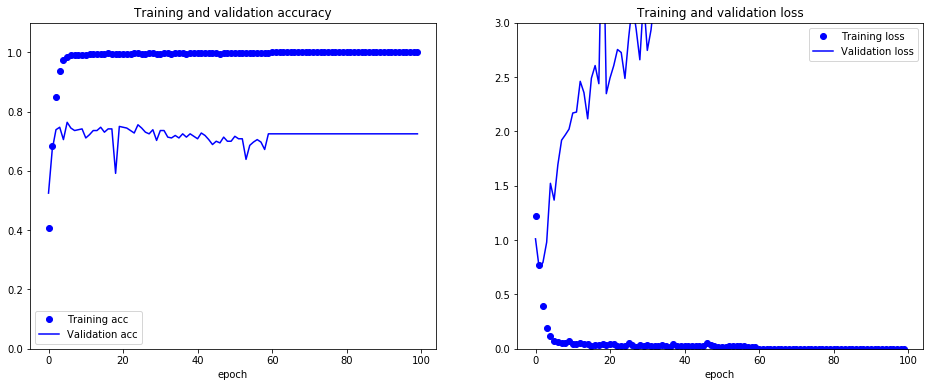

acc=1.00 (val_acc=0.72) | loss=0.00 (val_loss=3.79) | lowest val_loss=1.37


Models with acc > 0.9:
        acc          loss  step_factor   val_acc  val_loss  val_loss_lowest
0  0.993107  4.909481e-02          1.0  0.667222  2.856451         0.925135
1  1.000000  1.192093e-07         10.0  0.725000  3.790751         1.373095


In [166]:
### 5) Looking at Steps Per Epoch and Batch-Size (Image Data Generator)
###     Section 5.1) Investigate Steps-Per-Epoch

img_dim, train_generator, validation_generator = prep_main(
    dataset=dataset, I_downsample=I_downsample, dictImgProp=dictImgProp, 
    ImgDatGen__batch_size=ImgDatGen__batch_size)

dfRes__step = pandas.DataFrame()

for step_factor in list_step_factor:
    print("\n\nstep_factor=" + str(step_factor))

    # Build model
    model = build_model_w6(img_dim=img_dim,
                           nClass=len(dictClass.keys()),
                           optimizer=optimizer,
                           dim_conv2d_1=dim_conv2d_1,
                           dim_conv2d_2=dim_conv2d_2,
                           dim_conv2d_3=dim_conv2d_3,
                           dim_conv2d_4=dim_conv2d_4,
                           dim_dense=dim_dense)
    # Fit model
    model_history = fit_model_w6(model=model,
         train_generator=train_generator,
         validation_generator=validation_generator,
         epochs=epochs,
         steps_per_epoch=step_factor*len(train_generator),
         validation_steps=step_factor*len(validation_generator),
         verbose=0)
    # Evaluate model
    msg, avg_acc, avg_val_acc, avg_loss, avg_val_loss, val_loss_lowest = \
      eval_model_w6(model_history=model_history, I_plot__min_acc=I_min_acc)

    print(msg)

    if avg_acc >= I_min_acc:
        dfRes__step = dfRes__step.append(
            {'step_factor': step_factor,
             'acc': avg_acc,
             'val_acc': avg_val_acc,
             'loss': avg_loss,
             'val_loss': avg_val_loss,
             'val_loss_lowest': val_loss_lowest}, ignore_index=True)

print("\n\nModels with acc > " + str(I_min_acc) + ":")
print(dfRes__step)

We find the best Steps-Per-Epoch to be length( ImageDataGenerator ). As we increase Steps-Per-Epoch, we get faster convergence but also see the effects of over-fitting sooner. If our run does not reach convergence for a given number of epochs, then we will simply increase the number of epochs.

In [167]:
step_factor = 1



batch_size=8
Found 3240 images belonging to 4 classes.
Found 360 images belonging to 4 classes.
data batch shape: (8, 120, 160, 3)
labels batch shape: (8, 4)


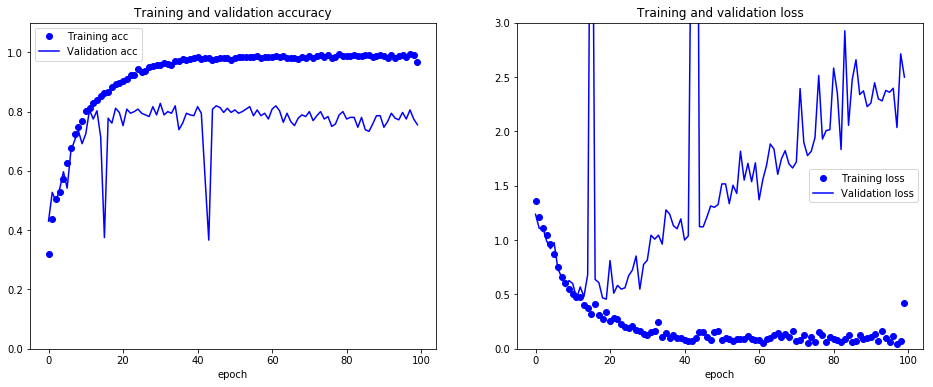

acc=0.99 (val_acc=0.77) | loss=0.12 (val_loss=2.38) | lowest val_loss=0.94


batch_size=16
Found 3240 images belonging to 4 classes.
Found 360 images belonging to 4 classes.
data batch shape: (16, 120, 160, 3)
labels batch shape: (16, 4)
acc=0.24 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39


batch_size=32
Found 3240 images belonging to 4 classes.
Found 360 images belonging to 4 classes.
data batch shape: (32, 120, 160, 3)
labels batch shape: (32, 4)


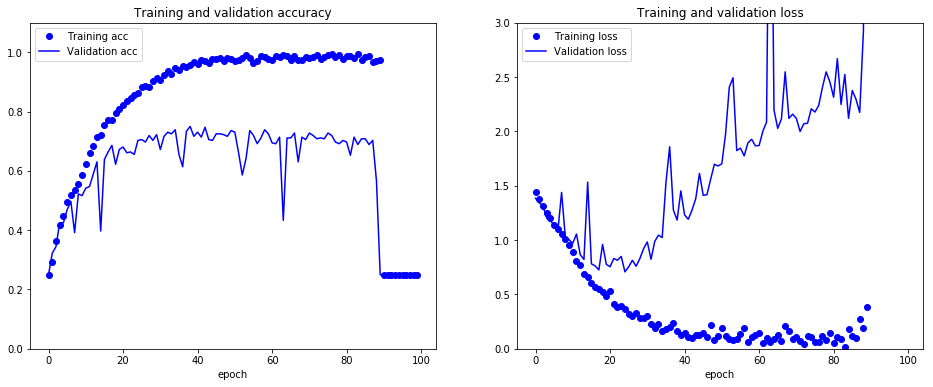

acc=0.49 (val_acc=0.36) | loss=8.13 (val_loss=9.52) | lowest val_loss=0.82


batch_size=64
Found 3240 images belonging to 4 classes.
Found 360 images belonging to 4 classes.
data batch shape: (64, 120, 160, 3)
labels batch shape: (64, 4)


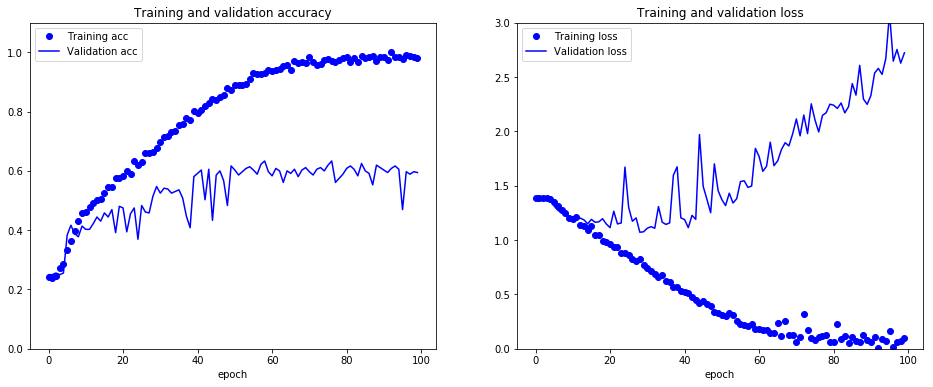

acc=0.98 (val_acc=0.59) | loss=0.08 (val_loss=2.56) | lowest val_loss=1.20


batch_size=96
Found 3240 images belonging to 4 classes.
Found 360 images belonging to 4 classes.
data batch shape: (96, 120, 160, 3)
labels batch shape: (96, 4)


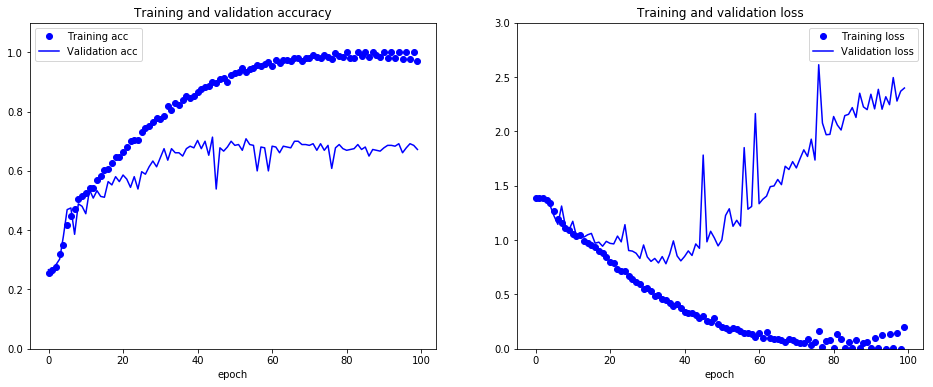

acc=0.99 (val_acc=0.68) | loss=0.06 (val_loss=2.29) | lowest val_loss=0.86


batch_size=128
Found 3240 images belonging to 4 classes.
Found 360 images belonging to 4 classes.
data batch shape: (128, 120, 160, 3)
labels batch shape: (128, 4)


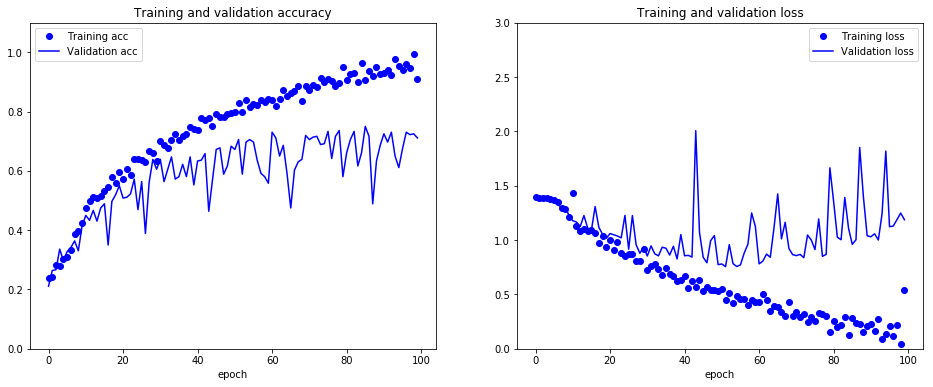

acc=0.94 (val_acc=0.68) | loss=0.21 (val_loss=1.22) | lowest val_loss=0.96


Models with acc > 0.9:
        acc  batch_size      loss   val_acc  val_loss  val_loss_lowest
0  0.986523         8.0  0.117458  0.771296  2.382771         0.940725
1  0.983539        64.0  0.079677  0.590000  2.560048         1.196256
2  0.989753        96.0  0.061966  0.676852  2.291086         0.856225
3  0.940885       128.0  0.209356  0.683519  1.218316         0.963734


In [168]:
### 5) Looking at Steps Per Epoch and Batch-Size (Image Data Generator)
###     Section 5.2) Investigate Batch-Size (Image Data Generator)

dfRes__batch_size = pandas.DataFrame()

for batch_size in list_batch_size:
    print("\n\nbatch_size=" + str(batch_size))

    img_dim, train_generator, validation_generator = prep_main(
        dataset=dataset, I_downsample=I_downsample, dictImgProp=dictImgProp, 
        ImgDatGen__batch_size=batch_size)

    # Build model
    model = build_model_w6(img_dim=img_dim,
                           nClass=len(dictClass.keys()),
                           optimizer=optimizer,
                           dim_conv2d_1=dim_conv2d_1,
                           dim_conv2d_2=dim_conv2d_2,
                           dim_conv2d_3=dim_conv2d_3,
                           dim_conv2d_4=dim_conv2d_4,
                           dim_dense=dim_dense)
    # Fit model
    model_history = fit_model_w6(model=model,
         train_generator=train_generator,
         validation_generator=validation_generator,
         epochs=epochs,
         steps_per_epoch=step_factor*len(train_generator),
         validation_steps=step_factor*len(validation_generator),
         verbose=0)
    # Evaluate model
    msg, avg_acc, avg_val_acc, avg_loss, avg_val_loss, val_loss_lowest = \
      eval_model_w6(model_history=model_history, I_plot__min_acc=I_min_acc)

    print(msg)

    if avg_acc >= I_min_acc:
        dfRes__batch_size = dfRes__batch_size.append(
            {'batch_size': batch_size,
             'acc': avg_acc,
             'val_acc': avg_val_acc,
             'loss': avg_loss,
             'val_loss': avg_val_loss,
             'val_loss_lowest': val_loss_lowest}, ignore_index=True)

print("\n\nModels with acc > " + str(I_min_acc) + ":")
print(dfRes__batch_size)

The highest validation accuracy and lowest validation loss was seen with a batch size of 16 for the ImageDataGenerator. As we increase batch size, we notice lower overall accuracies and higher losess. When we decrease the batch size from 16 to 8, our results are very poor. We will use a batch size of 16.

=================================================

Section 6: Looking at Optimizer

We will investigate the impact on changing the optimizer. We have been using RMSProp. We will now compare RMSProp against Adam and NAdam.

In [174]:
list_optimizer = ['rmsprop', 'adam', 'nadam']

In [175]:
### 6) Modeling the Data, First Pass
###     Section 6.0) Prepare run on medium set

# User-defined parameters
#   Which dataset
dataset = 'medium'
#   Toggle between using down-sampled or full images
I_downsample = True
#   Set ImageDataGenerator batch size, as per results in (5)
ImgDatGen__batch_size = 16
#   Number of epochs
epochs=50

# Layer parameters found in (4)
dim_dense = 32
dim_conv2d_1 = 8
dim_conv2d_2 = 16
dim_conv2d_3 = 16
dim_conv2d_4 = 16

# Steps-Per-Epoch factor, as per results in (5)
step_factor = 1

# Get handles to ImageeDataGenerator objects
img_dim, train_generator, validation_generator = prep_main(
    dataset=dataset, I_downsample=I_downsample, dictImgProp=dictImgProp, 
    ImgDatGen__batch_size=ImgDatGen__batch_size)

Found 3240 images belonging to 4 classes.
Found 360 images belonging to 4 classes.
data batch shape: (16, 120, 160, 3)
labels batch shape: (16, 4)


Found 3240 images belonging to 4 classes.
Found 360 images belonging to 4 classes.
data batch shape: (16, 120, 160, 3)
labels batch shape: (16, 4)


optimizer=rmsprop


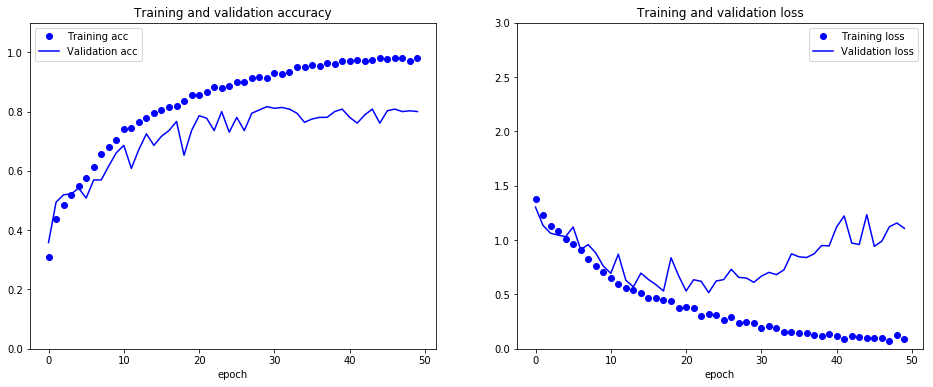

acc=0.98 (val_acc=0.80) | loss=0.10 (val_loss=1.06) | lowest val_loss=0.62


optimizer=adam


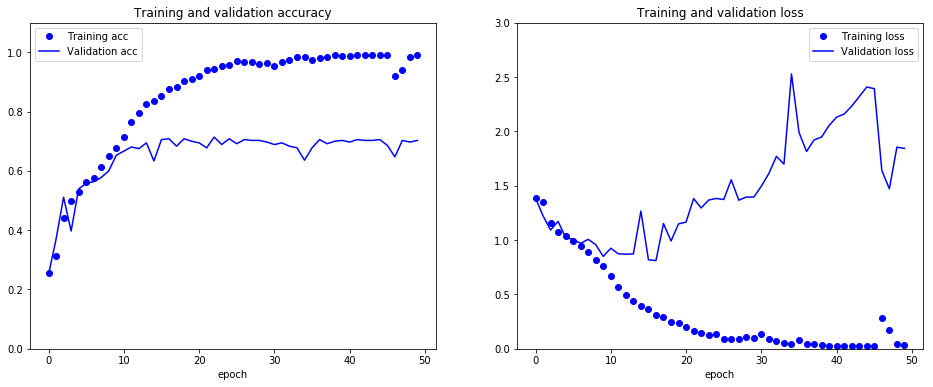

acc=0.97 (val_acc=0.69) | loss=0.08 (val_loss=2.02) | lowest val_loss=0.99


optimizer=nadam


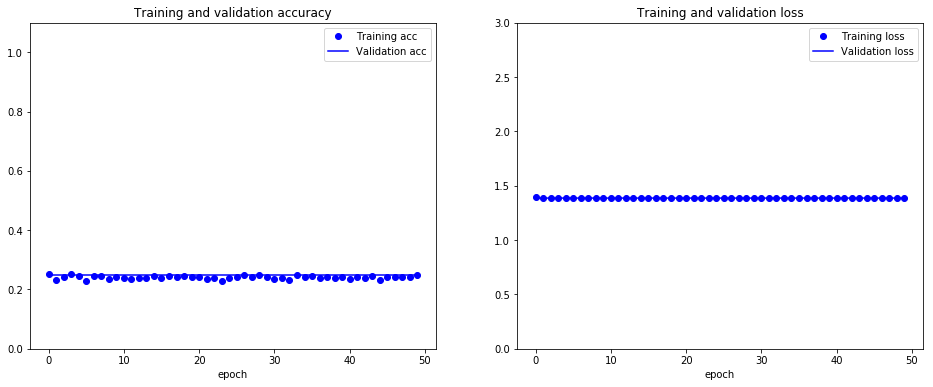

acc=0.24 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39


Results:
        acc      loss optimizer   val_acc  val_loss  val_loss_lowest
0  0.976659  0.100676   rmsprop  0.796528  1.060717         0.621119
1  0.974537  0.079366      adam  0.693403  2.020338         0.991611
2  0.241628  1.386645     nadam  0.250000  1.386306         1.386305


In [176]:
### 6) Looking at Steps Per Epoch and Batch-Size (Image Data Generator)
###     Section 6.1) Investigate Steps-Per-Epoch

img_dim, train_generator, validation_generator = prep_main(
    dataset=dataset, I_downsample=I_downsample, dictImgProp=dictImgProp, 
    ImgDatGen__batch_size=ImgDatGen__batch_size)

dfRes__optimizer = pandas.DataFrame()

for optimizer in list_optimizer:
    print("\n\noptimizer=" + str(optimizer))

    # Build model
    model = build_model_w6(img_dim=img_dim,
                           nClass=len(dictClass.keys()),
                           optimizer=optimizer,
                           dim_conv2d_1=dim_conv2d_1,
                           dim_conv2d_2=dim_conv2d_2,
                           dim_conv2d_3=dim_conv2d_3,
                           dim_conv2d_4=dim_conv2d_4,
                           dim_dense=dim_dense)
    # Fit model
    model_history = fit_model_w6(model=model,
         train_generator=train_generator,
         validation_generator=validation_generator,
         epochs=epochs,
         steps_per_epoch=step_factor*len(train_generator),
         validation_steps=step_factor*len(validation_generator),
         verbose=0)
    # Evaluate model
    msg, avg_acc, avg_val_acc, avg_loss, avg_val_loss, val_loss_lowest = \
      eval_model_w6(model_history=model_history, I_plot__min_acc=None)

    print(msg)

    dfRes__optimizer = dfRes__optimizer.append(
        {'optimizer': optimizer,
         'acc': avg_acc,
         'val_acc': avg_val_acc,
         'loss': avg_loss,
         'val_loss': avg_val_loss,
         'val_loss_lowest': val_loss_lowest}, ignore_index=True)

print("\n\nResults:")
print(dfRes__optimizer)

These results suggest we should stick with the optimizer RMSProp

=================================================

Section 7: L2 Regularization and Dropout

We are now ready to begin tackling the problem of over-fitting. We will try L2 regularization, dropout, and a combination of the two

In [146]:
### 7) L2 Regularization and Dropout
###     Section 7.0) Define model -building functions

def build_model_w6__w_l2_reg(img_dim, nClass, optimizer='rmsprop',
                             dim_conv2d_1=4, dim_conv2d_2=8,
                             dim_conv2d_3=8, dim_conv2d_4=8,
                             dim_dense=128,
                             lambda_l2reg=0.0001):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(dim_conv2d_1, (3, 3), activation='relu',
                               input_shape=(img_dim[0], img_dim[1], img_dim[2])))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(dim_conv2d_2, (3, 3), activation='relu'))
    if dim_conv2d_3 != 0:
        model.add(keras.layers.MaxPooling2D((2, 2)))
        model.add(keras.layers.Conv2D(dim_conv2d_3, (3, 3), activation='relu'))
        if dim_conv2d_4 != 0:
            model.add(keras.layers.MaxPooling2D((2, 2)))
            model.add(keras.layers.Conv2D(dim_conv2d_4, (3, 3), activation='relu'))
    
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(dim_dense, activation='relu',
                                 kernel_regularizer=keras.regularizers.l2(
                                     lambda_l2reg)))

    model.add(keras.layers.Dense(nClass, activation='softmax'))    
    model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['acc'])
    return model

def build_model_w6__w_dropout_1(img_dim, nClass, optimizer='rmsprop',
                                dim_conv2d_1=4, dim_conv2d_2=8,
                                dim_conv2d_3=8, dim_conv2d_4=8,
                                dim_dense=128,
                                dropout=0.5):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(dim_conv2d_1, (3, 3), activation='relu',
                               input_shape=(img_dim[0], img_dim[1], img_dim[2])))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(dim_conv2d_2, (3, 3), activation='relu'))
    if dim_conv2d_3 != 0:
        model.add(keras.layers.MaxPooling2D((2, 2)))
        model.add(keras.layers.Conv2D(dim_conv2d_3, (3, 3), activation='relu'))
        if dim_conv2d_4 != 0:
            model.add(keras.layers.MaxPooling2D((2, 2)))
            model.add(keras.layers.Conv2D(dim_conv2d_4, (3, 3), activation='relu'))
    
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(dim_dense, activation='relu'))
    
    model.add(keras.layers.Dropout(dropout))

    model.add(keras.layers.Dense(nClass, activation='softmax'))    
    model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['acc'])
    return model

def build_model_w6__w_dropout_2_v1(img_dim, nClass, optimizer='rmsprop',
                                   dim_conv2d_1=4, dim_conv2d_2=8,
                                   dim_conv2d_3=8, dim_conv2d_4=8,
                                   dim_dense=128,
                                   dropout=0.5):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(dim_conv2d_1, (3, 3), activation='relu',
                               input_shape=(img_dim[0], img_dim[1], img_dim[2])))
    
    model.add(keras.layers.Dropout(dropout))
    
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(dim_conv2d_2, (3, 3), activation='relu'))
    if dim_conv2d_3 != 0:
        model.add(keras.layers.MaxPooling2D((2, 2)))
        model.add(keras.layers.Conv2D(dim_conv2d_3, (3, 3), activation='relu'))
        if dim_conv2d_4 != 0:
            model.add(keras.layers.MaxPooling2D((2, 2)))
            model.add(keras.layers.Conv2D(dim_conv2d_4, (3, 3), activation='relu'))
    
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(dim_dense, activation='relu'))
    
    model.add(keras.layers.Dropout(dropout))

    model.add(keras.layers.Dense(nClass, activation='softmax'))    
    model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['acc'])
    return model

def build_model_w6__w_dropout_2_v2(img_dim, nClass, optimizer='rmsprop',
                                   dim_conv2d_1=4, dim_conv2d_2=8,
                                   dim_conv2d_3=8, dim_conv2d_4=8,
                                   dim_dense=128,
                                   dropout=0.5):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(dim_conv2d_1, (3, 3), activation='relu',
                               input_shape=(img_dim[0], img_dim[1], img_dim[2])))
    
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(dim_conv2d_2, (3, 3), activation='relu'))
    if dim_conv2d_3 != 0:
        model.add(keras.layers.MaxPooling2D((2, 2)))
        model.add(keras.layers.Conv2D(dim_conv2d_3, (3, 3), activation='relu'))
        if dim_conv2d_4 != 0:
            model.add(keras.layers.MaxPooling2D((2, 2)))
            model.add(keras.layers.Conv2D(dim_conv2d_4, (3, 3), activation='relu'))
    
    model.add(keras.layers.Flatten())
    
    model.add(keras.layers.Dropout(dropout))

    model.add(keras.layers.Dense(dim_dense, activation='relu'))
    
    model.add(keras.layers.Dropout(dropout))

    model.add(keras.layers.Dense(nClass, activation='softmax'))    
    model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['acc'])
    return model

def build_model_w6__w_dropout_mult(img_dim, nClass, optimizer='rmsprop',
                                   dim_conv2d_1=4, dim_conv2d_2=8,
                                   dim_conv2d_3=8, dim_conv2d_4=8,
                                   dim_dense=128,
                                   dropout=0.5):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(dim_conv2d_1, (3, 3), activation='relu',
                               input_shape=(img_dim[0], img_dim[1], img_dim[2])))
    
    model.add(keras.layers.Dropout(dropout))
    
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(dim_conv2d_2, (3, 3), activation='relu'))
    
    model.add(keras.layers.Dropout(dropout))
    
    if dim_conv2d_3 != 0:
        model.add(keras.layers.MaxPooling2D((2, 2)))
        model.add(keras.layers.Conv2D(dim_conv2d_3, (3, 3), activation='relu'))
        if dim_conv2d_4 != 0:
            model.add(keras.layers.MaxPooling2D((2, 2)))
            model.add(keras.layers.Conv2D(dim_conv2d_4, (3, 3), activation='relu'))
    
    model.add(keras.layers.Flatten())
    
    model.add(keras.layers.Dropout(dropout))

    model.add(keras.layers.Dense(dim_dense, activation='relu'))
    
    model.add(keras.layers.Dropout(dropout))

    model.add(keras.layers.Dense(nClass, activation='softmax'))    
    model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['acc'])
    return model

In [177]:
### 7) L2 Regularization and Dropout
###     Section 7.1) Set parameters

list_lambda_l2reg = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
list_dropout = [0.1, 0.4, 0.6, 0.8]

# User-defined parameters
#   Which dataset
dataset = 'medium'
#   Toggle between using down-sampled or full images
I_downsample = True
#   Set ImageDataGenerator batch size, as per results in (5)
ImgDatGen__batch_size = 16
#   Number of epochs
epochs=150
#   Optimizer, as per results in (6)
optimizer='rmsprop'

# Layer parameters found in (4)
dim_dense = 32
dim_conv2d_1 = 8
dim_conv2d_2 = 16
dim_conv2d_3 = 16
dim_conv2d_4 = 16

# Steps-Per-Epoch factor, as per results in (5)
step_factor = 1

# Get handles to ImageeDataGenerator objects
img_dim, train_generator, validation_generator = prep_main(
    dataset=dataset, I_downsample=I_downsample, dictImgProp=dictImgProp, 
    ImgDatGen__batch_size=ImgDatGen__batch_size)

Found 3240 images belonging to 4 classes.
Found 360 images belonging to 4 classes.
data batch shape: (16, 120, 160, 3)
labels batch shape: (16, 4)




lambda_l2reg=0.01


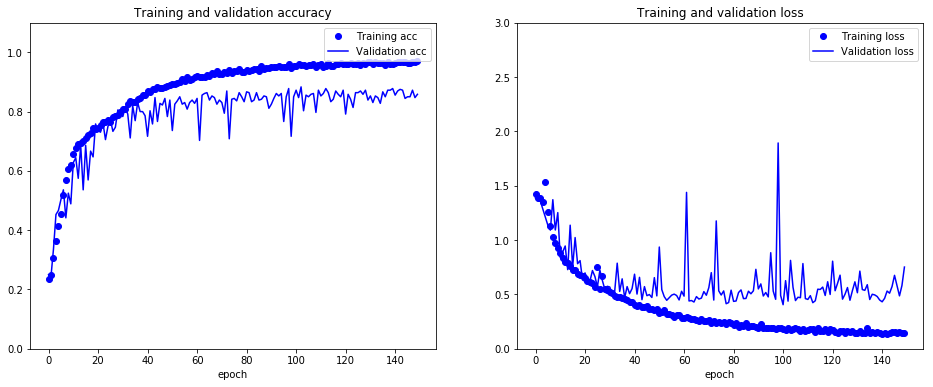

acc=0.96 (val_acc=0.86) | loss=0.15 (val_loss=0.54) | lowest val_loss=0.61


lambda_l2reg=0.001


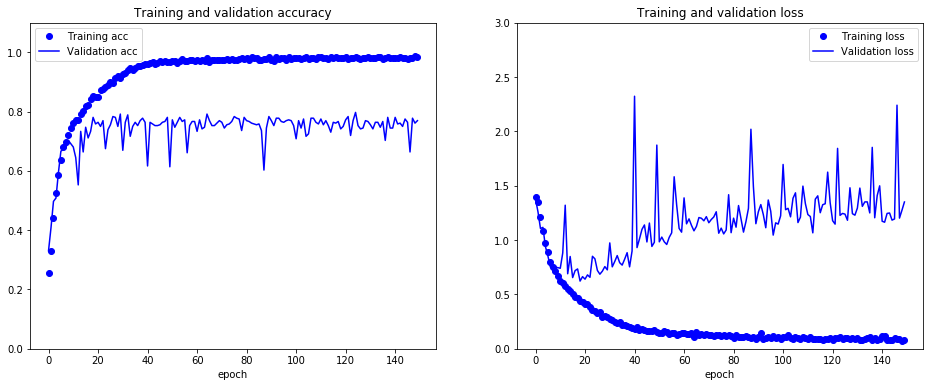

acc=0.98 (val_acc=0.75) | loss=0.09 (val_loss=1.36) | lowest val_loss=0.76


lambda_l2reg=0.0001


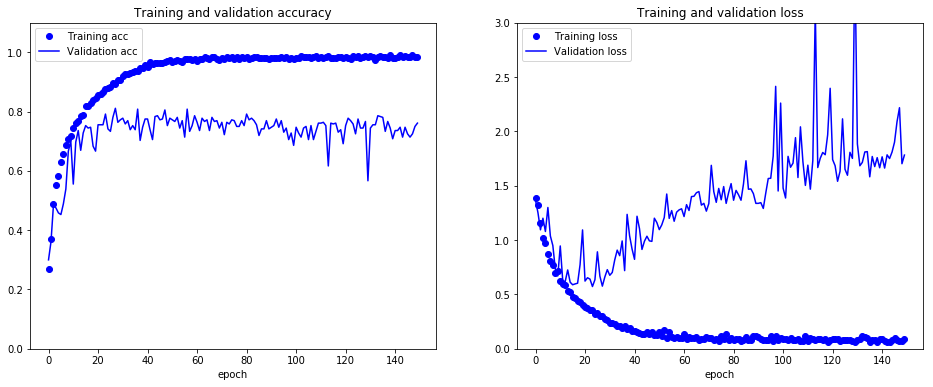

acc=0.98 (val_acc=0.74) | loss=0.08 (val_loss=1.87) | lowest val_loss=0.70


lambda_l2reg=1e-05


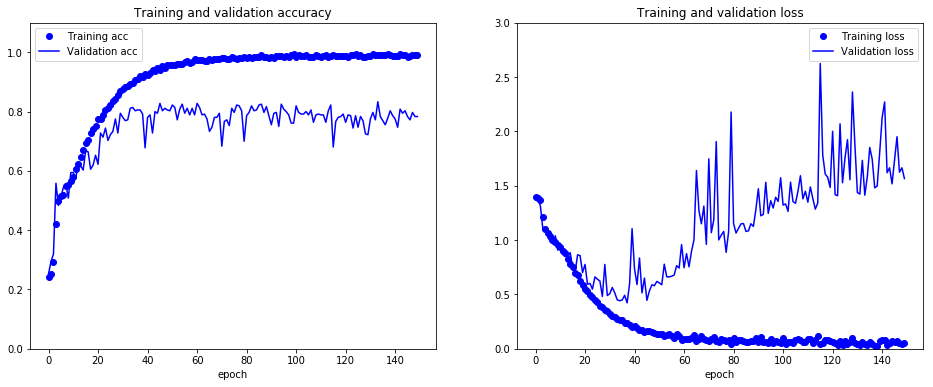

acc=0.99 (val_acc=0.78) | loss=0.06 (val_loss=1.72) | lowest val_loss=0.58


lambda_l2reg=1e-06


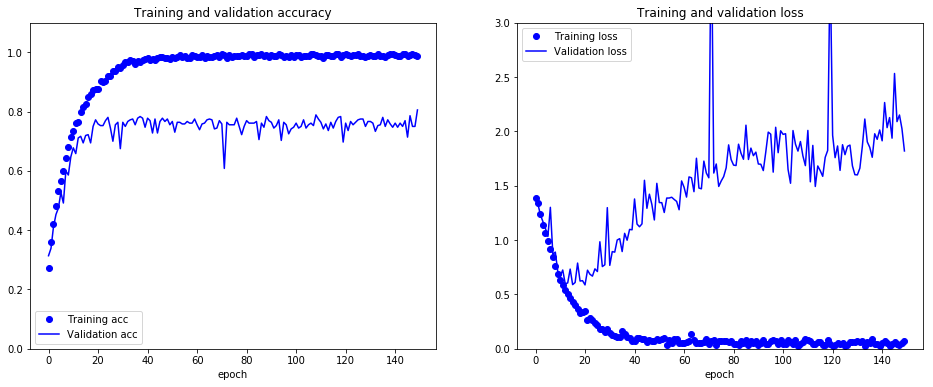

acc=0.99 (val_acc=0.76) | loss=0.05 (val_loss=1.94) | lowest val_loss=0.74


Results:
        acc  lambda_l2reg      loss   val_acc  val_loss
0  0.964466      0.010000  0.150202  0.857126  0.542290
1  0.981736      0.001000  0.091084  0.754469  1.357901
2  0.984595      0.000100  0.082195  0.738768  1.868175
3  0.989868      0.000010  0.056053  0.778986  1.716924
4  0.989748      0.000001  0.053083  0.759300  1.944424


In [153]:
### 7) L2 Regularization and Dropout
###     Section 7.2) Build, fit and evaluate for L2 regularization

dfRes__l2reg = pandas.DataFrame()

for lambda_l2reg in list_lambda_l2reg:
    print("\n\nlambda_l2reg=" + str(lambda_l2reg))

    # Build model
    model = build_model_w6__w_l2_reg(img_dim=img_dim,
                                     nClass=len(dictClass.keys()),
                                     optimizer=optimizer,
                                     dim_conv2d_1=dim_conv2d_1,
                                     dim_conv2d_2=dim_conv2d_2,
                                     dim_conv2d_3=dim_conv2d_3,
                                     dim_conv2d_4=dim_conv2d_4,
                                     dim_dense=dim_dense,
                                     lambda_l2reg=lambda_l2reg)
    # Fit model
    model_history = fit_model_w6(model=model,
         train_generator=train_generator,
         validation_generator=validation_generator,
         epochs=epochs,
         steps_per_epoch=step_factor*len(train_generator),
         validation_steps=step_factor*len(validation_generator),
         verbose=0)
    # Evaluate model
    msg, avg_acc, avg_val_acc, avg_loss, avg_val_loss, val_loss_lowest = \
      eval_model_w6(model_history=model_history, I_plot__min_acc=None)

    print(msg)

    dfRes__l2reg = dfRes__l2reg.append(
        {'lambda_l2reg': lambda_l2reg,
         'acc': avg_acc,
         'val_acc': avg_val_acc,
         'loss': avg_loss,
         'val_loss': avg_val_loss,
         'val_loss_lowest': val_loss_lowest}, ignore_index=True)

print("\n\nResults:")
print(dfRes__l2reg)

We find the best correction for over-fitting occurs at high lambda values. Specifically, here we see that a lambda of 0.01 out performs the others. This is seen by the manner in which the validation loss does not grow after it's reach its minimum.

We will now look at how effective dropout can be.



dropout_1=0.1


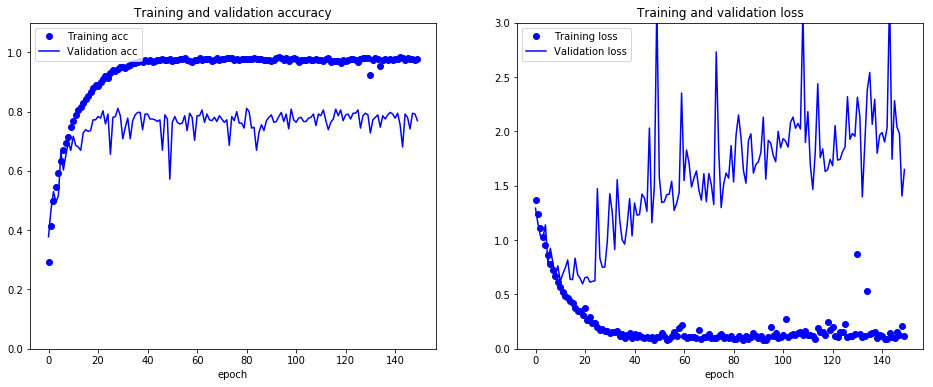

acc=0.97 (val_acc=0.77) | loss=0.18 (val_loss=2.04) | lowest val_loss=0.77


dropout_2_v1=0.1


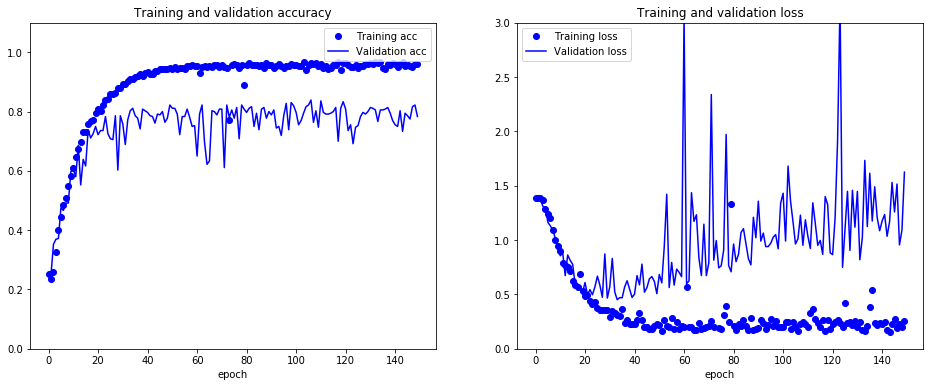

acc=0.96 (val_acc=0.79) | loss=0.24 (val_loss=1.25) | lowest val_loss=0.57


dropout_2_v2=0.1


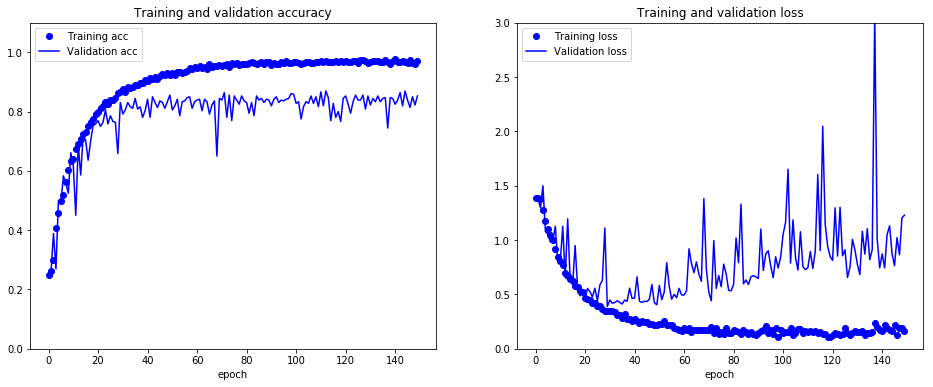

acc=0.97 (val_acc=0.84) | loss=0.17 (val_loss=1.02) | lowest val_loss=0.51


dropout_mult=0.1


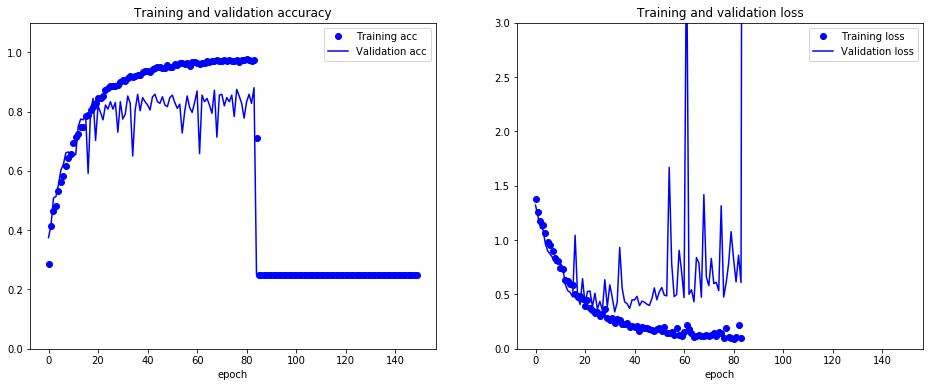

acc=0.25 (val_acc=0.25) | loss=12.09 (val_loss=12.09) | lowest val_loss=0.47


dropout_1=0.4


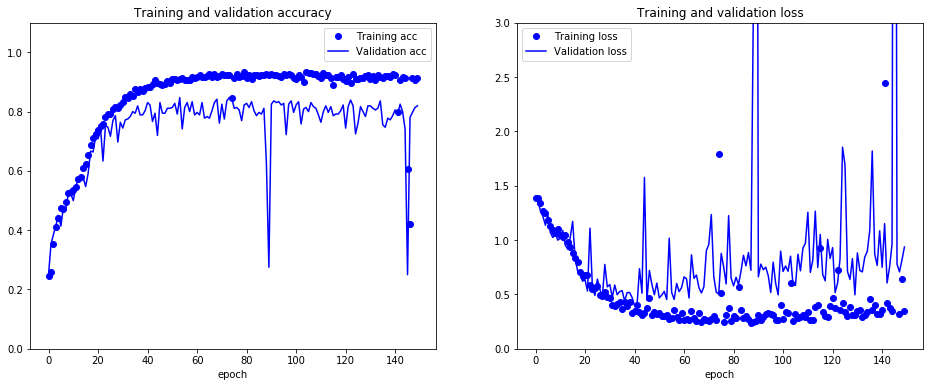

acc=0.88 (val_acc=0.77) | loss=1.06 (val_loss=1.36) | lowest val_loss=0.57


dropout_2_v1=0.4


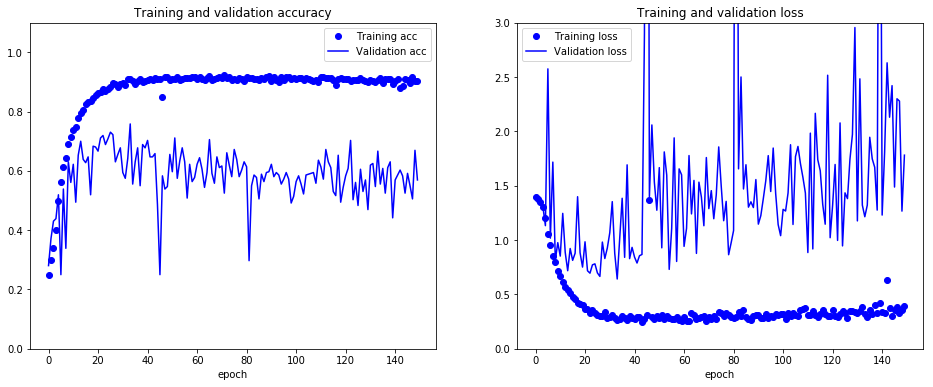

acc=0.90 (val_acc=0.57) | loss=0.36 (val_loss=2.05) | lowest val_loss=1.00


dropout_2_v2=0.4


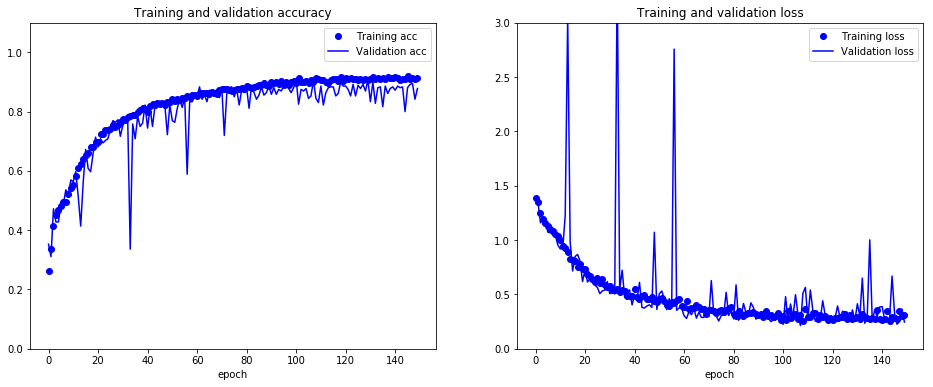

acc=0.91 (val_acc=0.87) | loss=0.29 (val_loss=0.36) | lowest val_loss=0.34


dropout_mult=0.4


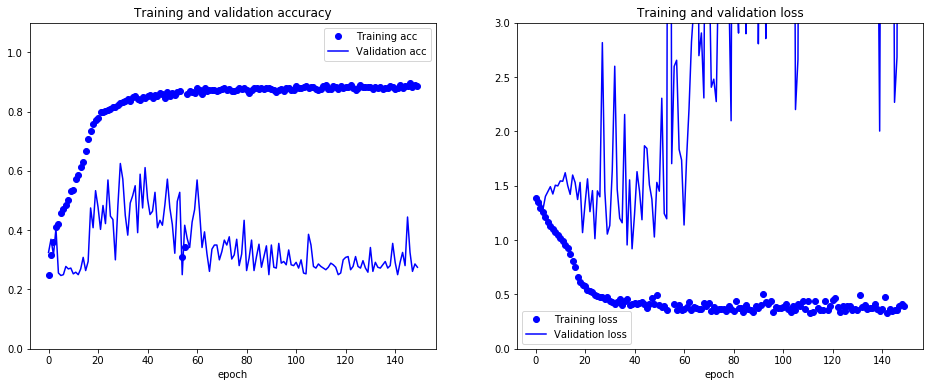

acc=0.88 (val_acc=0.30) | loss=0.38 (val_loss=6.14) | lowest val_loss=1.51


dropout_1=0.6


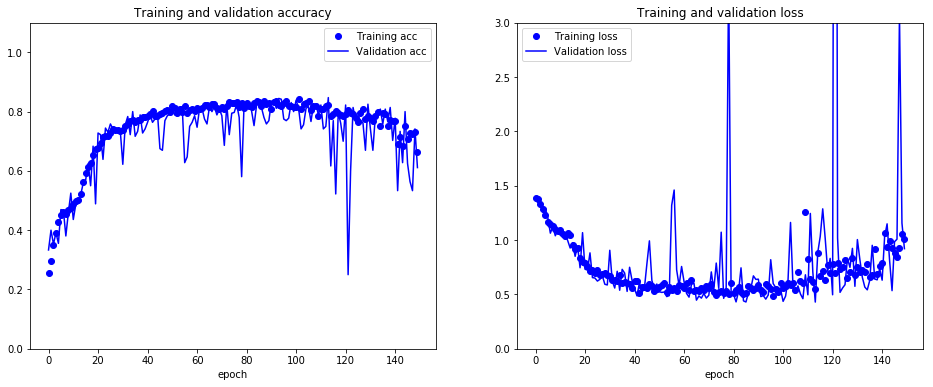

acc=0.75 (val_acc=0.72) | loss=0.83 (val_loss=0.90) | lowest val_loss=1.20


dropout_2_v1=0.6


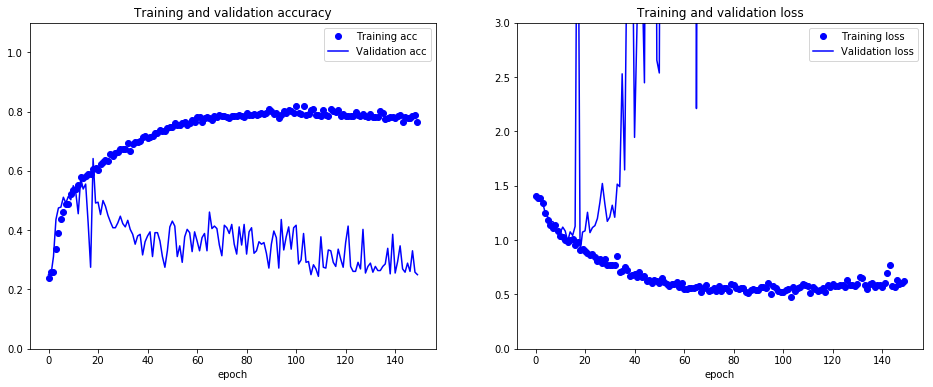

acc=0.78 (val_acc=0.29) | loss=0.61 (val_loss=8.91) | lowest val_loss=1.32


dropout_2_v2=0.6
acc=0.25 (val_acc=0.25) | loss=12.08 (val_loss=12.09) | lowest val_loss=0.58


dropout_mult=0.6
acc=0.68 (val_acc=0.31) | loss=0.84 (val_loss=7.15) | lowest val_loss=2.34


dropout_1=0.8


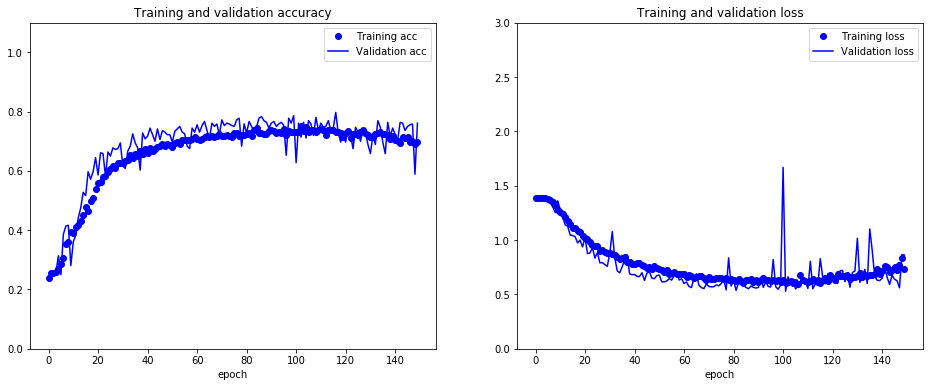

acc=0.71 (val_acc=0.72) | loss=0.71 (val_loss=0.71) | lowest val_loss=0.65


dropout_2_v1=0.8
acc=0.47 (val_acc=0.28) | loss=3.32 (val_loss=3.19) | lowest val_loss=1.61


dropout_2_v2=0.8
acc=0.67 (val_acc=0.71) | loss=0.92 (val_loss=0.98) | lowest val_loss=0.72


dropout_mult=0.8
acc=0.30 (val_acc=0.28) | loss=1.41 (val_loss=1.37) | lowest val_loss=1.35


Results:
         acc  dropout       loss   val_acc   val_loss version
0   0.974262      0.1   0.176279  0.774034   2.040042       1
1   0.958548      0.1   0.239762  0.791425   1.251916    2_v1
2   0.968599      0.1   0.169222  0.835870   1.022097    2_v2
3   0.250000      0.1  12.088572  0.250000  12.088572    mult
4   0.875845      0.4   1.059863  0.771739   1.355346       1
5   0.903086      0.4   0.363904  0.571860   2.054843    2_v1
6   0.911621      0.4   0.293064  0.870652   0.364198    2_v2
7   0.882797      0.4   0.382200  0.295048   6.141152    mult
8   0.751973      0.6   0.826914  0.715338   0.901739       1
9   0.782850

In [154]:
### 7) L2 Regularization and Dropout
###     Section 7.3) Build, fit and evaluate for Dropout

dfRes__dropout = pandas.DataFrame()

for dropout in list_dropout:
    print("\n\ndropout_1=" + str(dropout))
    # Build model
    model = build_model_w6__w_dropout_1(img_dim=img_dim,
                                        nClass=len(dictClass.keys()),
                                        optimizer=optimizer,
                                        dim_conv2d_1=dim_conv2d_1,
                                        dim_conv2d_2=dim_conv2d_2,
                                        dim_conv2d_3=dim_conv2d_3,
                                        dim_conv2d_4=dim_conv2d_4,
                                        dim_dense=dim_dense,
                                        dropout=dropout)
    # Fit model
    model_history = fit_model_w6(model=model,
         train_generator=train_generator,
         validation_generator=validation_generator,
         epochs=epochs,
         steps_per_epoch=step_factor*len(train_generator),
         validation_steps=step_factor*len(validation_generator),
         verbose=0)
    # Evaluate model
    msg, avg_acc, avg_val_acc, avg_loss, avg_val_loss, val_loss_lowest = \
      eval_model_w6(model_history=model_history, I_plot__min_acc=None)
    print(msg)
    dfRes__dropout = dfRes__dropout.append(
        {'dropout': dropout,
         'version': '1',
         'acc': avg_acc,
         'val_acc': avg_val_acc,
         'loss': avg_loss,
         'val_loss': avg_val_loss,
         'val_loss_lowest': val_loss_lowest}, ignore_index=True)
    
    
    print("\n\ndropout_2_v1=" + str(dropout))
    # Build model
    model = build_model_w6__w_dropout_2_v1(img_dim=img_dim,
                                           nClass=len(dictClass.keys()),
                                           optimizer=optimizer,
                                           dim_conv2d_1=dim_conv2d_1,
                                           dim_conv2d_2=dim_conv2d_2,
                                           dim_conv2d_3=dim_conv2d_3,
                                           dim_conv2d_4=dim_conv2d_4,
                                           dim_dense=dim_dense,
                                           dropout=dropout)
    # Fit model
    model_history = fit_model_w6(model=model,
         train_generator=train_generator,
         validation_generator=validation_generator,
         epochs=epochs,
         steps_per_epoch=step_factor*len(train_generator),
         validation_steps=step_factor*len(validation_generator),
         verbose=0)
    # Evaluate model
    msg, avg_acc, avg_val_acc, avg_loss, avg_val_loss, val_loss_lowest = \
      eval_model_w6(model_history=model_history, I_plot__min_acc=I_plot__min_acc)
    print(msg)
    dfRes__dropout = dfRes__dropout.append(
        {'dropout': dropout,
         'version': '2_v1',
         'acc': avg_acc,
         'val_acc': avg_val_acc,
         'loss': avg_loss,
         'val_loss': avg_val_loss,
         'val_loss_lowest': val_loss_lowest}, ignore_index=True)
    
    
    print("\n\ndropout_2_v2=" + str(dropout))
    # Build model
    model = build_model_w6__w_dropout_2_v2(img_dim=img_dim,
                                           nClass=len(dictClass.keys()),
                                           optimizer=optimizer,
                                           dim_conv2d_1=dim_conv2d_1,
                                           dim_conv2d_2=dim_conv2d_2,
                                           dim_conv2d_3=dim_conv2d_3,
                                           dim_conv2d_4=dim_conv2d_4,
                                           dim_dense=dim_dense,
                                           dropout=dropout)
    # Fit model
    model_history = fit_model_w6(model=model,
         train_generator=train_generator,
         validation_generator=validation_generator,
         epochs=epochs,
         steps_per_epoch=step_factor*len(train_generator),
         validation_steps=step_factor*len(validation_generator),
         verbose=0)
    # Evaluate model
    msg, avg_acc, avg_val_acc, avg_loss, avg_val_loss, val_loss_lowest = \
      eval_model_w6(model_history=model_history, I_plot__min_acc=I_plot__min_acc)
    print(msg)
    dfRes__dropout = dfRes__dropout.append(
        {'dropout': dropout,
         'version': '2_v2',
         'acc': avg_acc,
         'val_acc': avg_val_acc,
         'loss': avg_loss,
         'val_loss': avg_val_loss,
         'val_loss_lowest': val_loss_lowest}, ignore_index=True)
    
    
    print("\n\ndropout_mult=" + str(dropout))
    # Build model
    model = build_model_w6__w_dropout_mult(img_dim=img_dim,
                                           nClass=len(dictClass.keys()),
                                           optimizer=optimizer,
                                           dim_conv2d_1=dim_conv2d_1,
                                           dim_conv2d_2=dim_conv2d_2,
                                           dim_conv2d_3=dim_conv2d_3,
                                           dim_conv2d_4=dim_conv2d_4,
                                           dim_dense=dim_dense,
                                           dropout=dropout)
    # Fit model
    model_history = fit_model_w6(model=model,
         train_generator=train_generator,
         validation_generator=validation_generator,
         epochs=epochs,
         steps_per_epoch=step_factor*len(train_generator),
         validation_steps=step_factor*len(validation_generator),
         verbose=0)
    # Evaluate model
    msg, avg_acc, avg_val_acc, avg_loss, avg_val_loss, val_loss_lowest = \
      eval_model_w6(model_history=model_history, I_plot__min_acc=I_plot__min_acc)
    print(msg)
    dfRes__dropout = dfRes__dropout.append(
        {'dropout': dropout,
         'version': 'mult',
         'acc': avg_acc,
         'val_acc': avg_val_acc,
         'loss': avg_loss,
         'val_loss': avg_val_loss,
         'val_loss_lowest': val_loss_lowest}, ignore_index=True)

print("\n\nResults:")
print(dfRes__dropout)

We find that the model with more than two dropout layers (version 'mult') does not perform well for any dropout values. With just one layer (version '1') and a dropout value of 0.4, we see reasonable correction of overfitting. We used two models with two layers. We saw the strongest performance overall with version '2_v2' at 0.4 but the results were reasonably good at 0.1 as well. Given the cost to accuracy at dropout value 0.4, we would be interested in testing values between 0.1 and 0.4 to find a more optimal dropout value. We would want to investigate whether we can combine L2 regularization with dropout.



dropout_2_v2=0.2


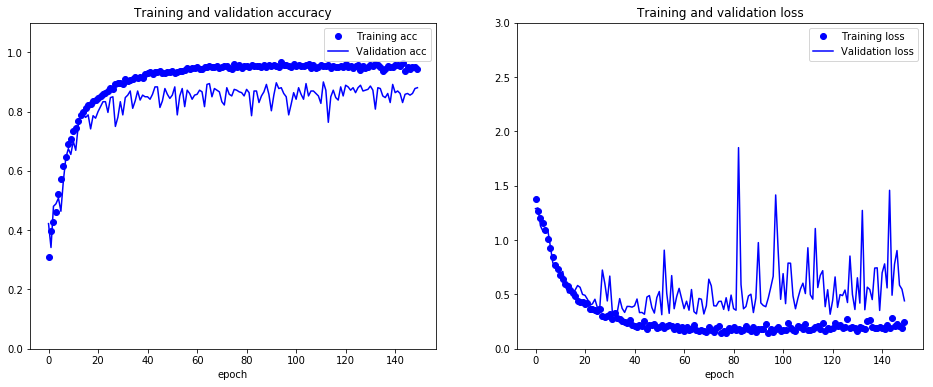

acc=0.95 (val_acc=0.86) | loss=0.21 (val_loss=0.66) | lowest val_loss=0.44


dropout_2_v2=0.3


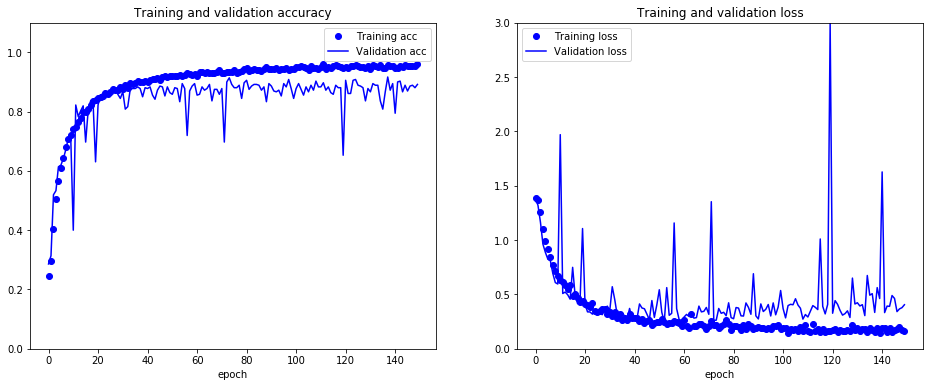

acc=0.95 (val_acc=0.87) | loss=0.18 (val_loss=0.48) | lowest val_loss=0.38


Results:
        acc  dropout       loss   val_acc   val_loss version  val_loss_lowest
0  0.968599      0.1   0.169222  0.835870   1.022097    2_v2              NaN
1  0.911621      0.4   0.293064  0.870652   0.364198    2_v2              NaN
2  0.250470      0.6  12.079194  0.250000  12.088572    2_v2              NaN
3  0.667432      0.8   0.915798  0.705072   0.984713    2_v2              NaN
4  0.951409      0.2   0.208203  0.862802   0.655394    2_v2         0.443902
5  0.952201      0.3   0.176033  0.873792   0.482708    2_v2         0.377983


In [178]:
# Initialize results matrix
dfRes__dropout2 = dfRes__dropout[dfRes__dropout['version']=='2_v2']

for dropout in [0.2, 0.3]:
    print("\n\ndropout_2_v2=" + str(dropout))
    # Build model
    model = build_model_w6__w_dropout_2_v2(img_dim=img_dim,
                                           nClass=len(dictClass.keys()),
                                           optimizer=optimizer,
                                           dim_conv2d_1=dim_conv2d_1,
                                           dim_conv2d_2=dim_conv2d_2,
                                           dim_conv2d_3=dim_conv2d_3,
                                           dim_conv2d_4=dim_conv2d_4,
                                           dim_dense=dim_dense,
                                           dropout=dropout)
    # Fit model
    model_history = fit_model_w6(model=model,
         train_generator=train_generator,
         validation_generator=validation_generator,
         epochs=epochs,
         steps_per_epoch=step_factor*len(train_generator),
         validation_steps=step_factor*len(validation_generator),
         verbose=0)
    # Evaluate model
    msg, avg_acc, avg_val_acc, avg_loss, avg_val_loss, val_loss_lowest = \
      eval_model_w6(model_history=model_history, I_plot__min_acc=I_plot__min_acc)
    print(msg)
    dfRes__dropout2 = dfRes__dropout2.append(
        {'dropout': dropout,
         'version': '2_v2',
         'acc': avg_acc,
         'val_acc': avg_val_acc,
         'loss': avg_loss,
         'val_loss': avg_val_loss,
         'val_loss_lowest': val_loss_lowest}, ignore_index=True)
print("\n\nResults:")
print(dfRes__dropout2)

We had seen that with our version "2_v2" dropout model, using a dropout factor of 0.1 was not quite enough to correct for over-fitting. Increasing to 0.2 does appear to be enough to be effective with only a small hit to accuracy. Arguably the best results occur with 0.3 which sees the highest validation accuracy and lowest validation loss.

We will now investigate combining L2 Regularization and dropout. For L2 Regularization we found higher lambda values to be the most effective, with 0.01 giving the best results. With dropout we see 0.3 to give the best results. We will want to investigate the combination of lambda 0.01 and dropout 0.3, as well as values for both that had given slightly worse results. Similarly, we will incorporate the most effective dropout configuration (version "2_v2") and a simpler configuration (version "1").

In [179]:
### 7) L2 Regularization and Dropout
###     Section 7.4) Define Dropout + L2 Regularization model

def build_model_w6__3_w_L2_reg_and_dropout_1(img_dim, nClass,
                                             optimizer='rmsprop',
                                             dim_conv2d_1=4, dim_conv2d_2=8,
                                             dim_conv2d_3=8, dim_conv2d_4=8,
                                             dim_dense=128,
                                             lambda_l2reg=0.0001,
                                             dropout=0.2):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(4, (3, 3), activation='relu',
                               input_shape=(img_dim[0], img_dim[1], img_dim[2])))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(8, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(8, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(8, (3, 3), activation='relu'))
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(16, activation='relu',
                                 kernel_regularizer=keras.regularizers.l2(
                                     lambda_l2reg)))
    model.add(keras.layers.Dropout(dropout))

    model.add(keras.layers.Dense(nClass, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['acc'])
    return model

def build_model_w6__3_w_L2_reg_and_dropout_2_v2(img_dim, nClass,
                                                optimizer='rmsprop',
                                                dim_conv2d_1=4, dim_conv2d_2=8,
                                                dim_conv2d_3=8, dim_conv2d_4=8,
                                                dim_dense=128,
                                                lambda_l2reg=0.0001,
                                                dropout=0.2):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(4, (3, 3), activation='relu',
                               input_shape=(img_dim[0], img_dim[1], img_dim[2])))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(8, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(8, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(8, (3, 3), activation='relu'))
    model.add(keras.layers.Flatten())
    
    model.add(keras.layers.Dropout(dropout))

    model.add(keras.layers.Dense(16, activation='relu',
                                 kernel_regularizer=keras.regularizers.l2(
                                     lambda_l2reg)))
    model.add(keras.layers.Dropout(dropout))

    model.add(keras.layers.Dense(nClass, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['acc'])
    return model

In [186]:
### 7) L2 Regularization and Dropout
###     Section 7.5) Define parameters

list_lambda_l2reg = [0.01, 0.001]
list_dropout = [0.05, 0.1, 0.3]

# # User-defined parameters
# #   Which dataset
# dataset = 'medium'
# #   Toggle between using down-sampled or full images
# I_downsample = True
# #   Set ImageDataGenerator batch size, as per results in (5)
# ImgDatGen__batch_size = 16
# #   Number of epochs
# epochs=150
# #   Optimizer, as per results in (6)
# optimizer='rmsprop'

# # Layer parameters found in (4)
# dim_dense = 32
# dim_conv2d_1 = 8
# dim_conv2d_2 = 16
# dim_conv2d_3 = 16
# dim_conv2d_4 = 16

# # Steps-Per-Epoch factor, as per results in (5)
# step_factor = 1

# # Get handles to ImageeDataGenerator objects
# img_dim, train_generator, validation_generator = prep_main(
#     dataset=dataset, I_downsample=I_downsample, dictImgProp=dictImgProp, 
#     ImgDatGen__batch_size=ImgDatGen__batch_size)



lambda_l2reg=0.01 | dropout_1=0.05


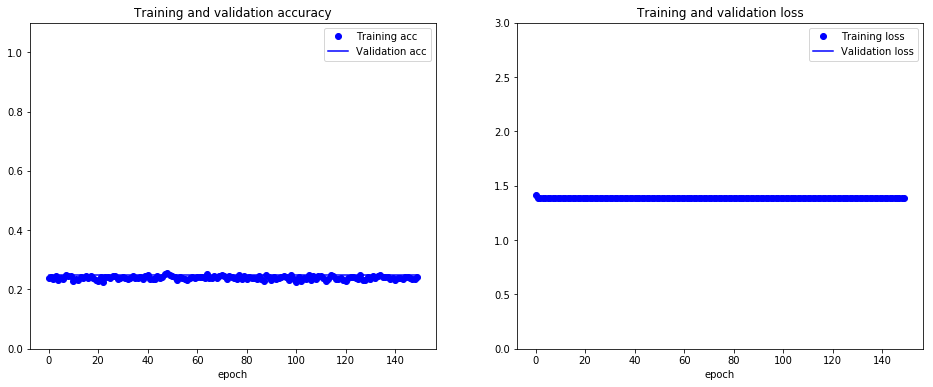

acc=0.24 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39


lambda_l2reg=0.01 | dropout_2_v2=0.05


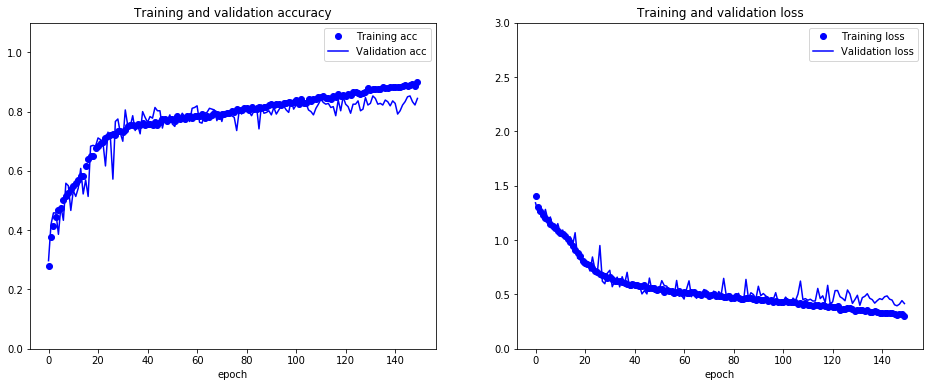

acc=0.88 (val_acc=0.83) | loss=0.34 (val_loss=0.45) | lowest val_loss=0.45


lambda_l2reg=0.01 | dropout_1=0.1


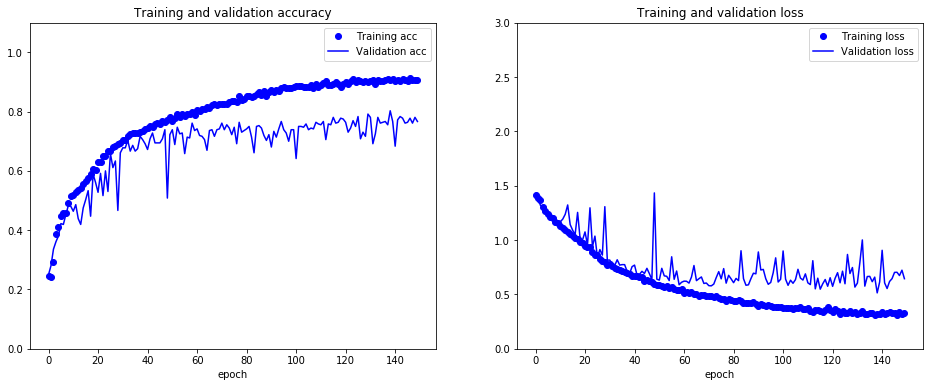

acc=0.91 (val_acc=0.76) | loss=0.33 (val_loss=0.67) | lowest val_loss=0.68


lambda_l2reg=0.01 | dropout_2_v2=0.1


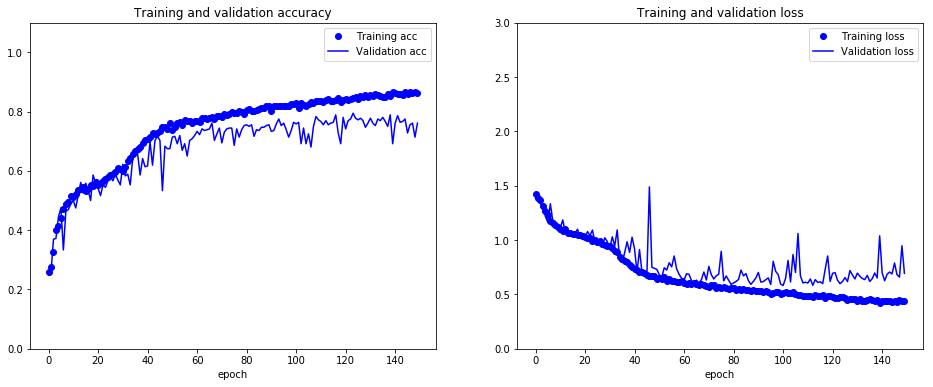

acc=0.86 (val_acc=0.76) | loss=0.44 (val_loss=0.70) | lowest val_loss=0.68


lambda_l2reg=0.01 | dropout_1=0.3


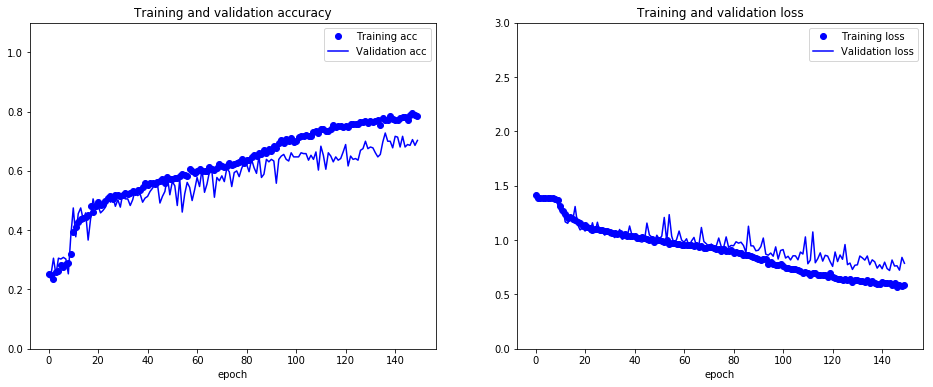

acc=0.77 (val_acc=0.69) | loss=0.61 (val_loss=0.78) | lowest val_loss=0.79


lambda_l2reg=0.01 | dropout_2_v2=0.3


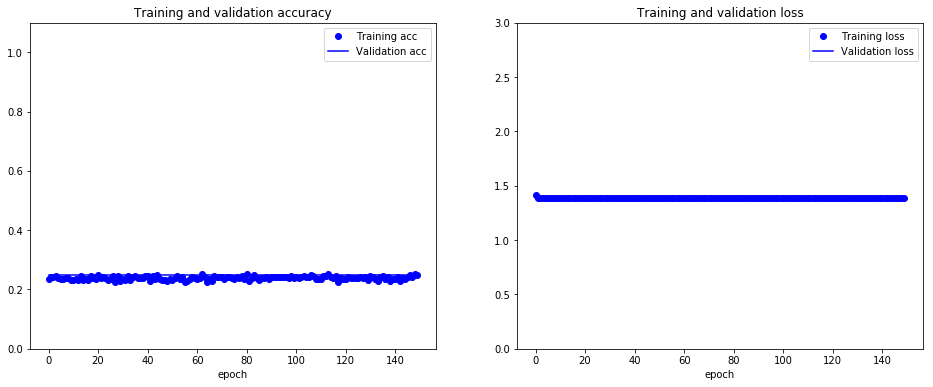

acc=0.24 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39


lambda_l2reg=0.001 | dropout_1=0.05


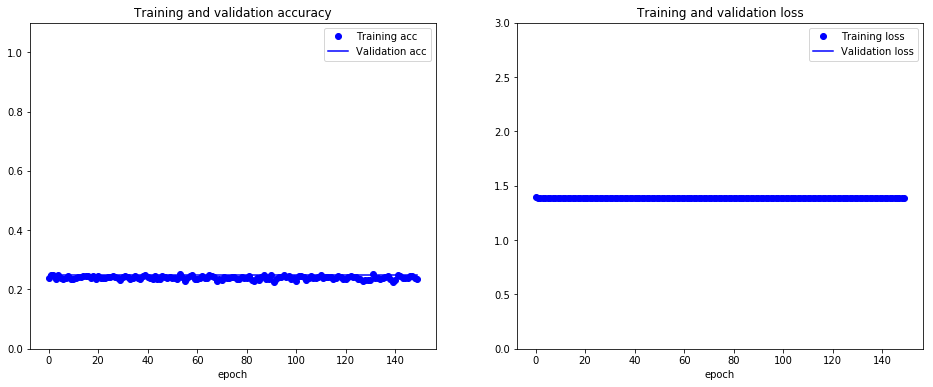

acc=0.24 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39


lambda_l2reg=0.001 | dropout_2_v2=0.05


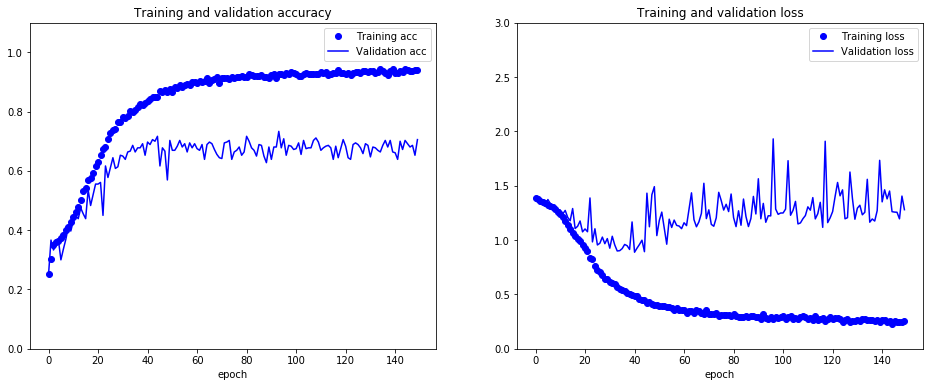

acc=0.94 (val_acc=0.68) | loss=0.26 (val_loss=1.33) | lowest val_loss=1.05


lambda_l2reg=0.001 | dropout_1=0.1


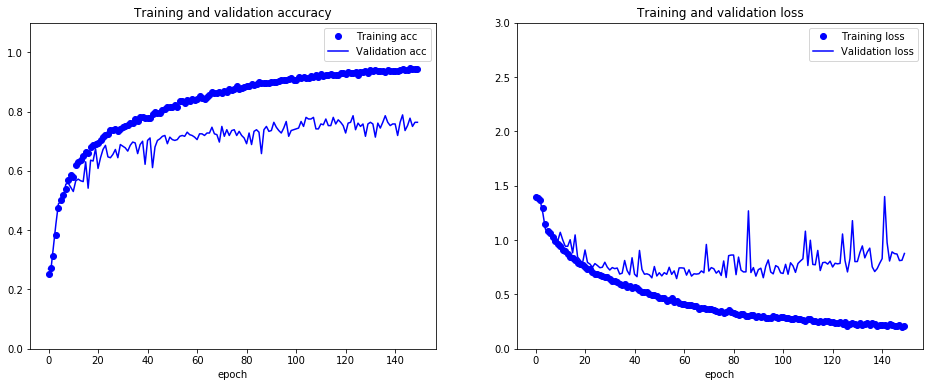

acc=0.94 (val_acc=0.76) | loss=0.22 (val_loss=0.88) | lowest val_loss=0.70


lambda_l2reg=0.001 | dropout_2_v2=0.1


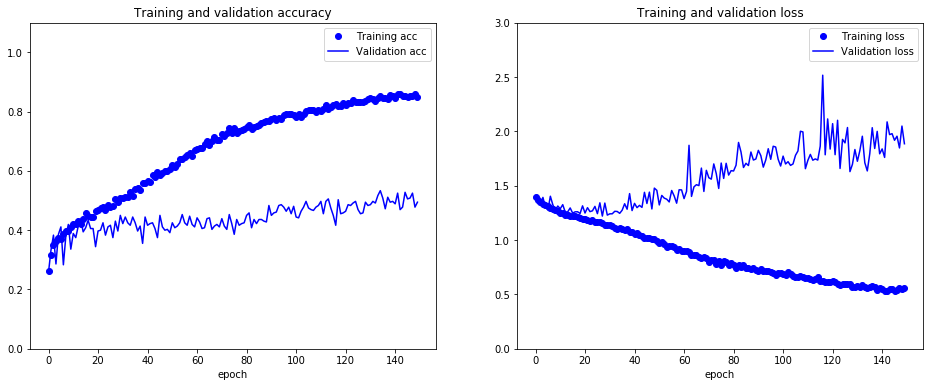

acc=0.85 (val_acc=0.50) | loss=0.56 (val_loss=1.86) | lowest val_loss=1.28


lambda_l2reg=0.001 | dropout_1=0.3


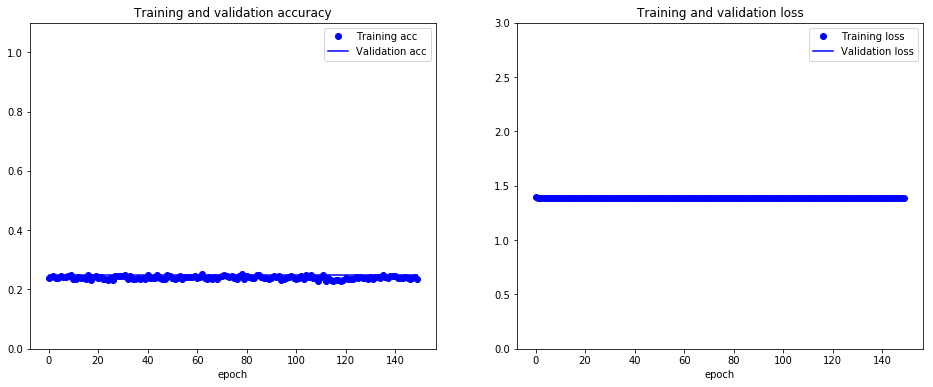

acc=0.24 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39


lambda_l2reg=0.001 | dropout_2_v2=0.3


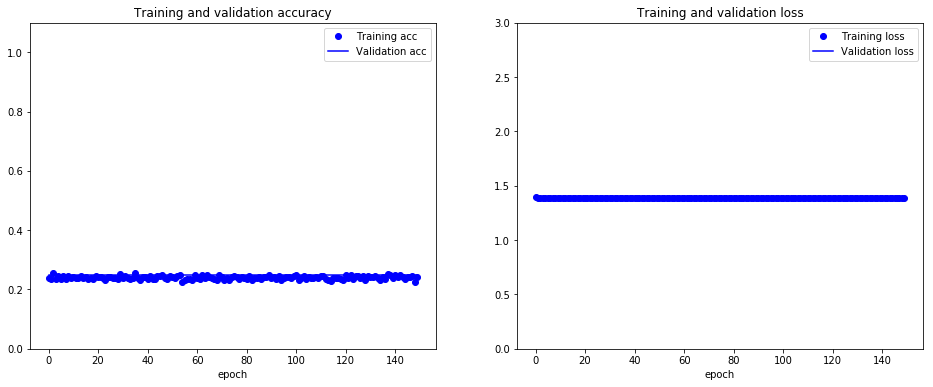

acc=0.24 (val_acc=0.25) | loss=1.39 (val_loss=1.39) | lowest val_loss=1.39


Results:
         acc  dropout  lambda_l2reg      loss   val_acc  val_loss  \
0   0.239184     0.05         0.010  1.386545  0.250000  1.386352   
1   0.881669     0.05         0.010  0.337544  0.829831  0.450484   
2   0.905140     0.10         0.010  0.327965  0.759179  0.673954   
3   0.857689     0.10         0.010  0.443187  0.759300  0.704064   
4   0.774826     0.30         0.010  0.608785  0.689251  0.783056   
5   0.239667     0.30         0.010  1.386545  0.250000  1.386353   
6   0.238688     0.05         0.001  1.386498  0.250000  1.386303   
7   0.936326     0.05         0.001  0.256857  0.678382  1.334710   
8   0.938674     0.10         0.001  0.220424  0.755435  0.879878   
9   0.847866     0.10         0.001  0.559649  0.497585  1.859343   
10  0.240446     0.30         0.001  1.386493  0.250000  1.386302   
11  0.241492     0.30         0.001  1.386494  0.250000  1.386303   

    val_loss_low

In [187]:
### 7) L2 Regularization and Dropout
###     Section 7.6) Build, fit and evaluate for Dropout + L2 Regularization model

dfRes__dropout_l2reg = pandas.DataFrame()

for lambda_l2reg in list_lambda_l2reg:
    for dropout in list_dropout:
        print("\n\nlambda_l2reg=" + str(lambda_l2reg) + " | dropout_1=" + str(dropout))
        # Build model
        model = build_model_w6__3_w_L2_reg_and_dropout_1(img_dim=img_dim,
                                                         nClass=len(dictClass.keys()),
                                                         optimizer=optimizer,
                                                         dim_conv2d_1=dim_conv2d_1,
                                                         dim_conv2d_2=dim_conv2d_2,
                                                         dim_conv2d_3=dim_conv2d_3,
                                                         dim_conv2d_4=dim_conv2d_4,
                                                         dim_dense=dim_dense,
                                                         lambda_l2reg=lambda_l2reg,
                                                         dropout=dropout)
        # Fit model
        model_history = fit_model_w6(model=model,
             train_generator=train_generator,
             validation_generator=validation_generator,
             epochs=epochs,
             steps_per_epoch=step_factor*len(train_generator),
             validation_steps=step_factor*len(validation_generator),
             verbose=0)
        # Evaluate model
        msg, avg_acc, avg_val_acc, avg_loss, avg_val_loss, val_loss_lowest = \
          eval_model_w6(model_history=model_history, I_plot__min_acc=None)
        print(msg)
        dfRes__dropout_l2reg = dfRes__dropout_l2reg.append(
            {'version': '1',
             'lambda_l2reg': lambda_l2reg,
             'dropout': dropout,
             'acc': avg_acc,
             'val_acc': avg_val_acc,
             'loss': avg_loss,
             'val_loss': avg_val_loss,
             'val_loss_lowest': val_loss_lowest}, ignore_index=True)
        
        
        print("\n\nlambda_l2reg=" + str(lambda_l2reg) + " | dropout_2_v2=" + str(dropout))
        # Build model
        model = build_model_w6__3_w_L2_reg_and_dropout_2_v2(img_dim=img_dim,
                                                            nClass=len(dictClass.keys()),
                                                            optimizer=optimizer,
                                                            dim_conv2d_1=dim_conv2d_1,
                                                            dim_conv2d_2=dim_conv2d_2,
                                                            dim_conv2d_3=dim_conv2d_3,
                                                            dim_conv2d_4=dim_conv2d_4,
                                                            dim_dense=dim_dense,
                                                            lambda_l2reg=lambda_l2reg,
                                                            dropout=dropout)
        # Fit model
        model_history = fit_model_w6(model=model,
             train_generator=train_generator,
             validation_generator=validation_generator,
             epochs=epochs,
             steps_per_epoch=step_factor*len(train_generator),
             validation_steps=step_factor*len(validation_generator),
             verbose=0)
        # Evaluate model
        msg, avg_acc, avg_val_acc, avg_loss, avg_val_loss, val_loss_lowest = \
          eval_model_w6(model_history=model_history, I_plot__min_acc=None)
        print(msg)
        dfRes__dropout_l2reg = dfRes__dropout_l2reg.append(
            {'version': '2_v2',
             'lambda_l2reg': lambda_l2reg,
             'dropout': dropout,
             'acc': avg_acc,
             'val_acc': avg_val_acc,
             'loss': avg_loss,
             'val_loss': avg_val_loss,
             'val_loss_lowest': val_loss_lowest}, ignore_index=True)

print("\n\nResults:")
print(dfRes__dropout_l2reg)

The best result found was with lower lambda value of 0.001 and dropout of 0.1 with a single dropout layer. These results are not any better than when we had just L2 regularization with lambda = 0.01 nor are they better than with only dropout (dropout = 0.3 with version "2_v2"). We will test both of these on the final model

=================================================

Section 8: Running with the full dataset

In [196]:
### 8) Running with the full dataset
###     Section 8.0) Set parameters

# User-defined parameters
#   Which dataset
dataset = 'full'
#   Toggle between using down-sampled or full images
I_downsample = True
#   Set ImageDataGenerator batch size, as per results in (5)
ImgDatGen__batch_size = 16
#   Number of epochs
epochs=150
#   Optimizer, as per results in (6)
optimizer='rmsprop'

# Layer parameters found in (4)
dim_dense = 32
dim_conv2d_1 = 8
dim_conv2d_2 = 16
dim_conv2d_3 = 16
dim_conv2d_4 = 16

# Steps-Per-Epoch factor, as per results in (5)
step_factor = 1

# L2 Regularization and Dropout from (7)
lambda_l2reg = 0.01
dropout = 0.3

# Get handles to ImageeDataGenerator objects
img_dim, train_generator, validation_generator = prep_main(
    dataset=dataset, I_downsample=I_downsample, dictImgProp=dictImgProp, 
    ImgDatGen__batch_size=ImgDatGen__batch_size)

Found 10800 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.
data batch shape: (16, 120, 160, 3)
labels batch shape: (16, 4)


In [197]:
dirSaveModel = os.path.join(fpRoot, 'code', 'final_prj')



Standard model


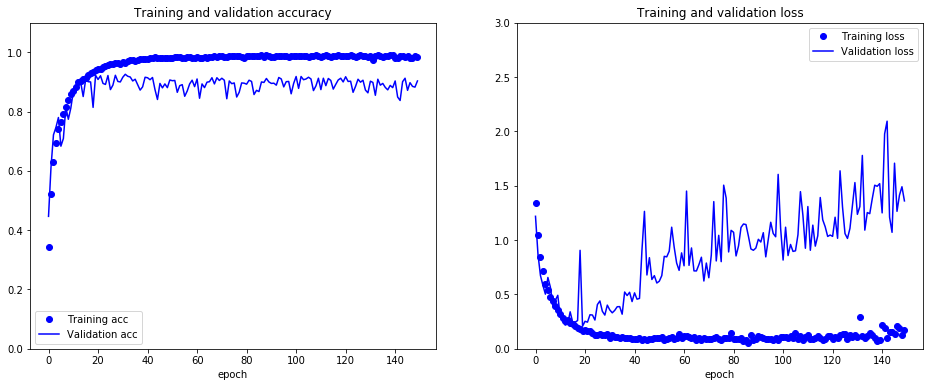

acc=0.99 (val_acc=0.89) | loss=0.14 (val_loss=1.42) | lowest val_loss=0.34


In [199]:
### 8) Running with the full dataset
###     Section 8.1) Build, fit and evaluate

dfRes__full = pandas.DataFrame()


print("\n\nStandard model")
# Build model
model = build_model_w6(img_dim=img_dim,
                       nClass=len(dictClass.keys()),
                       optimizer=optimizer,
                       dim_conv2d_1=dim_conv2d_1,
                       dim_conv2d_2=dim_conv2d_2,
                       dim_conv2d_3=dim_conv2d_3,
                       dim_conv2d_4=dim_conv2d_4,
                       dim_dense=dim_dense)
# Fit model
model_history = fit_model_w6(model=model,
     train_generator=train_generator,
     validation_generator=validation_generator,
     epochs=epochs,
     steps_per_epoch=step_factor*len(train_generator),
     validation_steps=step_factor*len(validation_generator),
     verbose=0)
# Evaluate model
msg, avg_acc, avg_val_acc, avg_loss, avg_val_loss, val_loss_lowest = \
  eval_model_w6(model_history=model_history, I_plot__min_acc=None)
print(msg)
dfRes__full = dfRes__full.append(
    {'lambda_l2reg': np.nan,
     'dropout': np.nan,
     'acc': avg_acc,
     'val_acc': avg_val_acc,
     'loss': avg_loss,
     'val_loss': avg_val_loss,
     'val_loss_lowest': val_loss_lowest}, ignore_index=True)
# Save
model.save(os.path.join(dirSaveModel, 'full_standard.h5'))



lambda_l2reg=0.01


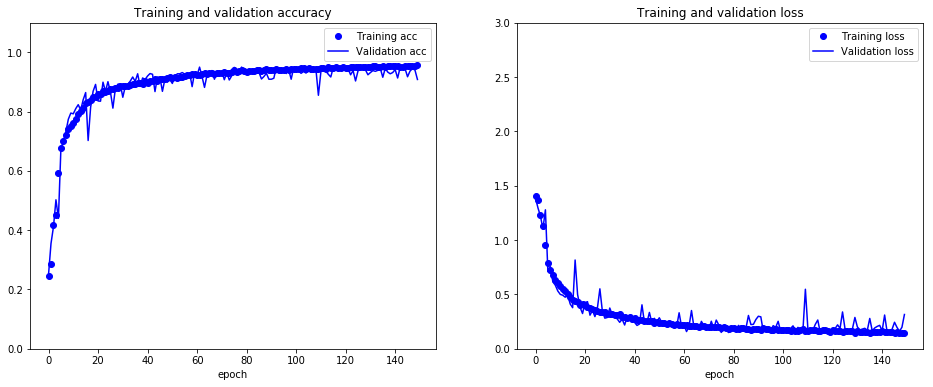

acc=0.95 (val_acc=0.93) | loss=0.15 (val_loss=0.20) | lowest val_loss=0.21


In [200]:
print("\n\nlambda_l2reg=" + str(lambda_l2reg))
# Build model
model = build_model_w6__w_l2_reg(img_dim=img_dim,
                                 nClass=len(dictClass.keys()),
                                 optimizer=optimizer,
                                 dim_conv2d_1=dim_conv2d_1,
                                 dim_conv2d_2=dim_conv2d_2,
                                 dim_conv2d_3=dim_conv2d_3,
                                 dim_conv2d_4=dim_conv2d_4,
                                 dim_dense=dim_dense,
                                 lambda_l2reg=lambda_l2reg)
# Fit model
model_history = fit_model_w6(model=model,
     train_generator=train_generator,
     validation_generator=validation_generator,
     epochs=epochs,
     steps_per_epoch=step_factor*len(train_generator),
     validation_steps=step_factor*len(validation_generator),
     verbose=0)
# Evaluate model
msg, avg_acc, avg_val_acc, avg_loss, avg_val_loss, val_loss_lowest = \
  eval_model_w6(model_history=model_history, I_plot__min_acc=None)
print(msg)
dfRes__full = dfRes__full.append(
    {'lambda_l2reg': lambda_l2reg,
     'dropout': np.nan,
     'acc': avg_acc,
     'val_acc': avg_val_acc,
     'loss': avg_loss,
     'val_loss': avg_val_loss,
     'val_loss_lowest': val_loss_lowest}, ignore_index=True)
# Save
model.save(os.path.join(dirSaveModel, 'full_l2reg_' + str(lambda_l2reg) + '.h5'))



dropout_2_v2=0.3


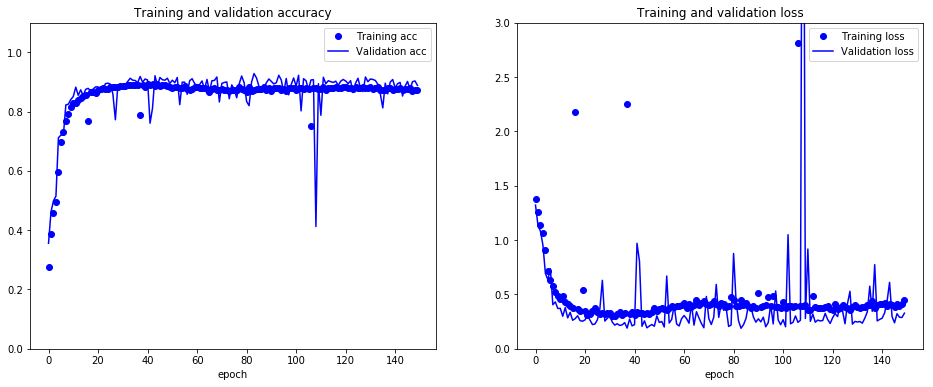

acc=0.88 (val_acc=0.89) | loss=0.40 (val_loss=0.35) | lowest val_loss=0.33


In [201]:
print("\n\ndropout_2_v2=" + str(dropout))
# Build model
model = build_model_w6__w_dropout_2_v2(img_dim=img_dim,
                                       nClass=len(dictClass.keys()),
                                       optimizer=optimizer,
                                       dim_conv2d_1=dim_conv2d_1,
                                       dim_conv2d_2=dim_conv2d_2,
                                       dim_conv2d_3=dim_conv2d_3,
                                       dim_conv2d_4=dim_conv2d_4,
                                       dim_dense=dim_dense,
                                       dropout=dropout)
# Fit model
model_history = fit_model_w6(model=model,
     train_generator=train_generator,
     validation_generator=validation_generator,
     epochs=epochs,
     steps_per_epoch=step_factor*len(train_generator),
     validation_steps=step_factor*len(validation_generator),
     verbose=0)
# Evaluate model
msg, avg_acc, avg_val_acc, avg_loss, avg_val_loss, val_loss_lowest = \
  eval_model_w6(model_history=model_history, I_plot__min_acc=I_plot__min_acc)
print(msg)
dfRes__full = dfRes__full.append(
    {'lambda_l2reg': np.nan,
     'dropout': dropout,
     'version': '2_v2',
     'acc': avg_acc,
     'val_acc': avg_val_acc,
     'loss': avg_loss,
     'val_loss': avg_val_loss,
     'val_loss_lowest': val_loss_lowest}, ignore_index=True)
# Save
model.save(os.path.join(dirSaveModel, 'full_dropout_' + str(dropout) + '.h5'))

In [202]:
print("\n\nResults:")
print(dfRes__full)



Results:
        acc  dropout  lambda_l2reg      loss   val_acc  val_loss  \
0  0.985934      NaN           NaN  0.142643  0.885145  1.417703   
1  0.952903      NaN          0.01  0.153448  0.934493  0.204148   
2  0.876767      0.3           NaN  0.398485  0.887645  0.348279   

   val_loss_lowest version  
0         0.341337     NaN  
1         0.205586     NaN  
2         0.325530    2_v2  


We find that L2 Regularization works much better than Dropout on the full dataset. Our final model therefore will be the L2 Regularization version.